# **Self-RAG com Gradiente Descendente**

In [1]:
import os
import sys
from dotenv import load_dotenv

import uuid
import json

In [2]:
load_dotenv()

True

In [3]:
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "manuals"

In [4]:
from docling.backend.docling_parse_v4_backend import DoclingParseV4DocumentBackend
from docling.datamodel.base_models import ConversionStatus, InputFormat
from docling.datamodel.document import ConversionResult
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

/Users/thaismedeiros/Documents/Mestrado/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from IPython.display import Image, display
from pathlib import Path
import re
import time

from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_milvus import Milvus as LangchainMilvus
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import (
    HumanMessage
)
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import END, StateGraph, START
from langchain.tools import BaseTool, tool

from pymilvus import connections, utility, Collection, MilvusException
from pydantic import BaseModel, Field
from typing import TypedDict, List, Optional, Iterable

import logging


In [6]:
# Configurations for the main logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# Console log (stdout)
console_handler = logging.StreamHandler(sys.stdout)
console_handler.setLevel(logging.INFO)
console_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
console_handler.setFormatter(console_formatter)

# File log with UTF-8 encoding
file_handler = logging.FileHandler("debug_models_gd.log", encoding="utf-8")
file_handler.setLevel(logging.DEBUG)
file_formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
file_handler.setFormatter(file_formatter)

# Add handlers to the logger
logger.addHandler(console_handler)
logger.addHandler(file_handler)

In [7]:
class RetrievalDecisionInput(BaseModel):
    """
    Input data for the RetrievalDecisionTool.
    
    Attributes:
        question (str): The user's question that needs evaluation for retrieval necessity.
    """
    question: str

class RetrievalDecision(BaseModel):
    """
    Represents the decision on whether document retrieval is required.
    
    Attributes:
        retrieval_token (str): Indicates whether retrieval is necessary. 
            - "Retrieval": New document retrieval is required.
            - "No Retrieval": The question can be answered without retrieving documents.
            - "Continue to Use Evidence": The question can be answered using previously retrieved evidence.
    """
    retrieval_token: str = Field(
        description="Indica se a recuperação é necessária. Pode ser 'Retrieval', 'No Retrieval' ou 'Continue to Use Evidence'."
    )

class RetrievalDecisionTool(BaseTool):
    """
    A tool that decides whether document retrieval is necessary before answering a query.
    
    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
    """
    name: str = "RetrievalDecision"
    description: str = "Decide se a recuperação é necessária antes de realizar a consulta."

    def _run(self, input: RetrievalDecisionInput):
        logger.info("Executing `_run` in `RetrievalDecisionTool` with input: %s", input)
        
        # Common questions that typically do not require document retrieval
        general_knowledge_questions = [
            r"o que é \w+",
            r"quem foi [^?]+",
            r"quando é o dia de \w+",
            r"defina \w+",
            r"definição de \w+",
            r"como funciona [^?]+",
            r"quando devo \w+",
            r"como \w+ impacta o desempenho"
        ]

        # Check if the question can be answered with general knowledge
        if any(re.search(pattern, input.question.lower()) for pattern in general_knowledge_questions):
            logger.info("Question identified as general knowledge. Retrieval is not necessary.")
            return RetrievalDecision(retrieval_token="No Retrieval")

        # If not, proceed with querying the model
        system = """
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.
        
        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
        - 'No Retrieval': Se a pergunta pode ser respondida sem a recuperação de documentos.
        - 'Continue to Use Evidence': Se a pergunta pode ser respondida usando as evidências recuperadas anteriormente.
        """
        prompt = f"{system}\n\nPergunta: {input.question}\n\nA resposta deve ser apenas 'Retrieval', 'No Retrieval' ou 'Continue to Use Evidence'."
        logger.debug("Generated prompt for LLM: %s", prompt)
        
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
        try:
            response = llm.invoke([HumanMessage(content=prompt)])
            logger.debug("LLM response received: %s", response.content)
        except Exception as e:
            logger.error("Error invoking the LLM: %s", str(e))
            raise
        
        # Interpret the response from the LLM
        if "retrieval" in response.content.lower():
            logger.info("Decision made: Retrieval")
            return RetrievalDecision(retrieval_token="Retrieval")
        elif "no retrieval" in response.content.lower():
            logger.info("Decision made: No Retrieval")
            return RetrievalDecision(retrieval_token="No Retrieval")
        else:
            logger.info("Decision made: Continue to Use Evidence")
            return RetrievalDecision(retrieval_token="Continue to Use Evidence")

In [8]:
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
    chunk_size=500
)

In [9]:
embeddings

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x1739df080>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x107f9d790>, model='text-embedding-3-small', dimensions=None, deployment='text-embedding-ada-002', openai_api_version=None, openai_api_base=None, openai_api_type=None, openai_proxy=None, embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=500, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [10]:
class RetrieverToolInput(BaseModel):
    pdf_paths: List[str]
    brand: str = None
    model: str = None
    year: str = None

class CreateRetrieverTool(BaseTool):
    """
    A tool that connects to Milvus, processes PDFs with Docling to Markdown,
    performs chunking, extracts metadata from the filename, and creates a retriever
    configured with input filters.
    
    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
        pdf_paths (List[str]): List of PDF file paths to process.
        brand (str): Optional brand filter for the retriever.
        model (str): Optional model filter for the retriever.
        year (str): Optional year filter for the retriever.
    
    Returns:
        LangchainMilvus: A retriever configured with the processed documents and filters.
    """
    name: str = "CreateRetriever"
    description: str = (
        "Conecta ao Milvus, processa PDFs com Docling para Markdown, faz chunking, "
        "extrai metadados do nome do arquivo e cria um retriever configurado com os filtros de input."
    )

    def _run(self, tool_input: RetrieverToolInput):
        vectorstore = None
        embeddings = OpenAIEmbeddings(
            model="text-embedding-3-small",
            chunk_size=500
        )
        
        milvus_uri = f"http://{MILVUS_HOST}:{MILVUS_PORT}"
        connection_args = {"uri": milvus_uri}
        
        # Connect to Milvus
        logger.info(f"Tentando pymilvus.connections.connect para alias 'default' com {MILVUS_HOST}:{MILVUS_PORT}")
        try:
            connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT, timeout=10.0) # Adicionado alias e timeout
            logger.info("pymilvus.connections.connect (default) chamado com sucesso.")
        except MilvusException as e_conn_milvus:
            logger.error(f"FALHA de MilvusException no pymilvus.connections.connect: {e_conn_milvus}", exc_info=True)
            raise RuntimeError(f"Falha Milvus inicial (MilvusException): {e_conn_milvus}")
        except Exception as e_conn_other:
            logger.error(f"FALHA Geral no pymilvus.connections.connect: {e_conn_other}", exc_info=True)
            raise RuntimeError(f"Falha Milvus inicial (Outra Exceção): {e_conn_other}")

        doc_converter = None # It will be initialized only if there are PDFs
        processed_at_least_one_file_for_vectorstore = False
        overall_start_time = time.time() # Time to the entire _run operation

        # --- BEGINNING OF CONDITIONAL BLOCK FOR PDF PROCESSING ---
        if tool_input.pdf_paths: # Only execute this section if there are PDFs in the list
            logger.info(f"Iniciando processamento para {len(tool_input.pdf_paths)} PDF(s) fornecidos.")
            try:
                pipeline_options = PdfPipelineOptions()
                pipeline_options.generate_page_images = False
                doc_converter = DocumentConverter(
                    format_options={
                        InputFormat.PDF: PdfFormatOption(
                            pipeline_options=pipeline_options,
                            backend=DoclingParseV4DocumentBackend
                        )
                    }
                )
                logger.info("DocumentConverter do Docling inicializado para esta execução de _run.")
            except Exception as e_docling_init:
                logger.error(f"Falha ao inicializar DocumentConverter do Docling: {e_docling_init}", exc_info=True)
                raise RuntimeError(f"Inicialização do Docling falhou: {e_docling_init}")

            pdf_processing_start_time = time.time()

            # Loop through each PDF path provided in tool_input
            for pdf_path_str in tool_input.pdf_paths:
                pdf_path_obj = Path(pdf_path_str)
                if not pdf_path_obj.is_file():
                    logger.warning(f"Arquivo PDF não encontrado: {pdf_path_str}. Pulando.")
                    continue

                filename_stem = pdf_path_obj.stem
                current_brand, current_model, current_year = None, None, None
                try:
                    current_brand, current_model, current_year = filename_stem.split('_')
                    if not (current_year.isdigit() and len(current_year) == 4):
                        raise ValueError("Formato de ano inválido no nome do arquivo")
                except ValueError as e:
                    logger.error(f"Nome '{filename_stem}.pdf' não segue 'marca_modelo_ano'. Pulando. Erro: {e}")
                    continue

                logger.info(f"Processando PDF: {pdf_path_str} para ingestão com metadados: marca={current_brand}, modelo={current_model}, ano={current_year}")

                try:
                    if self._metadata_exists(current_brand, current_model, current_year):
                        logger.info(f"Metadados (marca={current_brand}, modelo={current_model}, ano={current_year}) para {filename_stem} já existem. Pulando ingestão.")
                        continue
                except MilvusException as e_meta_milvus:
                    logger.error(f"MilvusException ao checar metadados para {filename_stem}: {e_meta_milvus}. Assumindo que não existe.", exc_info=True)
                except Exception as e_meta_other:
                    logger.error(f"Erro geral ao checar metadados para {filename_stem}: {e_meta_other}. Assumindo que não existe.", exc_info=True)
                
                logger.info(f"Iniciando conversão com Docling para: {pdf_path_str}")
                markdown_content = None
                conv_res = None
                try:
                    # Supondo que ConversionResult, ConversionStatus, Iterable estão importados
                    conv_results_generator: Iterable[ConversionResult] = doc_converter.convert_all(
                        [pdf_path_obj], raises_on_error=False
                    )
                    conv_results_list = list(conv_results_generator) 

                    if conv_results_list:
                        conv_res = conv_results_list[0]
                        if conv_res.status == ConversionStatus.SUCCESS and conv_res.document:
                            markdown_content = conv_res.document.export_to_markdown()
                            logger.info(f"Docling: Conversão bem-sucedida para {filename_stem}.md.")
                        elif conv_res.status == ConversionStatus.PARTIAL_SUCCESS and conv_res.document:
                            markdown_content = conv_res.document.export_to_markdown()
                            logger.warning(f"Docling: Conversão PARCIAL para {filename_stem}.md. Erros: {conv_res.errors}")
                        else:
                            logger.error(f"Docling: Conversão para {filename_stem}.md não bem-sucedida ou sem documento. Status: {conv_res.status}, Erros: {conv_res.errors if conv_res else 'N/A'}")
                            continue # Pula para o próximo PDF
                    else:
                        logger.error(f"Docling: Nenhum resultado de conversão para {filename_stem}.md.")
                        continue # Pula para o próximo PDF

                except Exception as e_docling_conv:
                    logger.error(f"Erro durante a conversão Docling ou processamento para {pdf_path_str}: {e_docling_conv}", exc_info=True)
                    continue # Pula para o próximo PDF

                if not markdown_content:
                    logger.warning(f"Nenhum conteúdo Markdown de Docling para {pdf_path_str}. Pulando.")
                    continue

                # Processing the Markdown content
                headers_to_split_on = [ ("#", "H1"), ("##", "H2"), ("###", "H3") ]
                header_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on, strip_headers=False)
                header_chunks_docs = header_splitter.split_text(markdown_content)
                
                # Chunking the documents into smaller parts
                char_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
                final_langchain_documents = []
                
                # Adding metadata to each document chunk
                for doc_chunk in header_chunks_docs:
                    doc_chunk.metadata['brand'] = current_brand
                    doc_chunk.metadata['model'] = current_model
                    doc_chunk.metadata['year'] = current_year
                    doc_chunk.metadata['source'] = filename_stem
                    if len(doc_chunk.page_content) > 1000:
                        sub_chunks = char_splitter.split_documents([doc_chunk])
                        final_langchain_documents.extend(sub_chunks)
                    else:
                        final_langchain_documents.append(doc_chunk)
                
                if not final_langchain_documents:
                    logger.warning(f"Nenhum chunk final para {filename_stem}. Pulando.")
                    continue

                try:
                    # Verify if the collection exists before trying to add documents
                    if vectorstore is None:
                        logger.info(f"Tentando LangchainMilvus.from_documents para '{MILVUS_COLLECTION_NAME}' com {len(final_langchain_documents)} chunks de {filename_stem}.")
                        vectorstore = LangchainMilvus.from_documents(
                            documents=final_langchain_documents, 
                            collection_name="manuals",
                            embedding=embeddings,
                            connection_args=connection_args,  # <-- CORRIGIDO
                            auto_id=True,
                            consistency_level="Strong",
                            search_params={"metric_type": "L2", "params": {"nprobe": 10}}
                        )

                    else:
                        logger.info(f"Tentando vectorstore.add_documents para '{MILVUS_COLLECTION_NAME}' com {len(final_langchain_documents)} chunks de {filename_stem}.")
                        vectorstore.add_documents(final_langchain_documents)
                    
                    processed_at_least_one_file_for_vectorstore = True
                    logger.info(f"{len(final_langchain_documents)} chunks processados e adicionados para {filename_stem}.")

                except MilvusException as e_milvus_lc_op:
                    logger.error(f"MilvusException durante op Langchain Milvus para {filename_stem}: {e_milvus_lc_op}", exc_info=True)
                    logger.warning(f"Pulando ingestão de {filename_stem} devido a erro Milvus.")
                    continue # Pula para o próximo PDF
                except Exception as e_lc_op_other:
                    logger.error(f"Erro geral durante op Langchain Milvus para {filename_stem}: {e_lc_op_other}", exc_info=True)
                    logger.warning(f"Pulando ingestão de {filename_stem} devido a erro geral.")
                    continue # Pula para o próximo PDF
            
            pdf_processing_end_time = time.time()
            logger.info(f"Tempo gasto no processamento de PDFs e ingestão: {pdf_processing_end_time - pdf_processing_start_time:.4f} segundos")
        
        else: # Caso tool_input.pdf_paths esteja vazio
            logger.info("Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.")
        # --- END OF CONDITIONAL BLOCK FOR PDF PROCESSING ---

        # Load the existing Milvus collection if no new PDFs were processed
        if not processed_at_least_one_file_for_vectorstore and vectorstore is None:
            logger.info("Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...")
            try:
                # utility.has_collection uses the 'default' connection established at the beginning
                if not utility.has_collection(MILVUS_COLLECTION_NAME, using='default', timeout=5):
                    logger.error(f"Coleção '{MILVUS_COLLECTION_NAME}' não existe e nenhum PDF foi fornecido ou processado para criá-la.")
                    # If no PDFs were provided AND the collection does not exist, so we raise an error
                    if not tool_input.pdf_paths:
                         raise ValueError(f"Coleção '{MILVUS_COLLECTION_NAME}' não encontrada e nenhum PDF fornecido para criar uma nova.")
                    else:
                         raise RuntimeError(f"Falha ao processar PDFs fornecidos e coleção '{MILVUS_COLLECTION_NAME}' não existe.")
                
                logger.info(f"Tentando instanciar LangchainMilvus para coleção existente '{MILVUS_COLLECTION_NAME}'...")
                vectorstore = LangchainMilvus(
                    collection_name="manuals",
                    embedding_function=embeddings,
                    connection_args=connection_args,  # <-- CORRIGIDO
                    auto_id=True,
                    consistency_level="Strong",
                    search_params={"metric_type": "L2", "params": {"nprobe": 10}}
                )
                logger.info("Coleção Milvus existente carregada com LangchainMilvus().")
            except MilvusException as e_milvus_load_ex:
                logger.error(f"MilvusException ao carregar coleção '{MILVUS_COLLECTION_NAME}': {e_milvus_load_ex}", exc_info=True)
                raise RuntimeError(f"Falha ao carregar coleção Milvus (MilvusException): {e_milvus_load_ex}")
            except ValueError as e_val_load_ex: # Captura o ValueError de coleção não encontrada
                logger.error(f"ValueError ao tentar carregar coleção: {e_val_load_ex}", exc_info=True)
                raise RuntimeError(f"Falha ao carregar/validar coleção Milvus: {e_val_load_ex}")
            except Exception as e_gen_load_ex:
                logger.error(f"Erro geral ao carregar coleção '{MILVUS_COLLECTION_NAME}': {e_gen_load_ex}", exc_info=True)
                raise RuntimeError(f"Falha ao carregar coleção Milvus (Outra Exceção): {e_gen_load_ex}")

        if vectorstore is None:
            message = "Vectorstore não pôde ser inicializado ou carregado. "
            if not tool_input.pdf_paths and not processed_at_least_one_file_for_vectorstore:
                message += "Nenhum PDF foi fornecido e a coleção existente não pôde ser acessada/não existe. "
            else:
                message += "Os PDFs fornecidos não resultaram em um vectorstore e a coleção existente não pôde ser carregada como fallback. "
            message += "Verifique a conexão com Milvus e se a coleção pode ser criada ou acessada."
            logger.error(message)
            raise RuntimeError(message)

        # --- CODE TO CREATE THE FILTER AND THE RETRIEVER ---
        logger.info(f"DEBUG: tool_input para filtro do retriever: brand='{tool_input.brand}', model='{tool_input.model}', year='{tool_input.year}'")
        filter_parts = []
        if tool_input.brand: filter_parts.append(f"brand == '{tool_input.brand}'")
        if tool_input.model: filter_parts.append(f"model == '{tool_input.model}'")
        if tool_input.year: filter_parts.append(f"year == '{tool_input.year}'")
        milvus_expr = " and ".join(filter_parts) if filter_parts else None
        retriever_kwargs = {"k": 10}
        if milvus_expr:
            logger.info(f"Aplicando filtro Milvus EXPR ao retriever: {milvus_expr}")
            retriever_kwargs["expr"] = milvus_expr
        else:
            logger.info("Nenhum filtro específico (marca/modelo/ano) será aplicado ao retriever (buscará em toda a coleção).")
        retriever = vectorstore.as_retriever(search_kwargs=retriever_kwargs)
        
        logger.info(f"Retriever criado com search_kwargs: {retriever.search_kwargs}")
        logger.info("Retriever criado com sucesso.")
        # end_overall_time = time.time()
        # logger.info(f"Tempo total de execução de _run: {end_overall_time - overall_start_time:.4f} segundos")
        return retriever

    def _metadata_exists(self, brand: str, model: str, year: str) -> bool:
        if not all([brand, model, year]): 
            logger.debug(f"Metadados incompletos para _metadata_exists (brand='{brand}', model='{model}', year='{year}'). Assumindo que não existe.")
            return False
        try:
            # The connection 'default' should have been established at the beginning of _run
            if not utility.has_collection(MILVUS_COLLECTION_NAME, using='default'): # Uses the 'default' connection
                return False
            collection = Collection(MILVUS_COLLECTION_NAME, using='default')
            
            logger.debug(f"Garantindo que a coleção '{MILVUS_COLLECTION_NAME}' esteja carregada para query em _metadata_exists.")
            collection.load() # Makes sure the collection is loaded
            
            expr = f"brand == '{brand}' and model == '{model}' and year == '{year}'"
            results = collection.query(expr=expr, output_fields=["brand"], limit=1)
            return len(results) > 0
        except MilvusException as e_milvus:
            logger.error(f"MilvusException ao checar metadados (brand={brand}, model={model}, year={year}): {e_milvus}", exc_info=True)
            return False 
        except Exception as e:
            logger.error(f"Erro geral ao checar metadados (brand={brand}, model={model}, year={year}): {e}", exc_info=True)
            return False

In [11]:
class GradeInput(BaseModel):
    """
    Input data for evaluating the relevance of documents.

    Attributes:
        question (str): The user's question used as context for evaluation.
        document (str): The content of the document being evaluated.
    """
    question: str
    document: str

class GradeDocuments(BaseModel):
    """
    Scoring model to verify the relevance of retrieved documents using the IsREL Token.

    Attributes:
        isrel_token (str): A token indicating the relevance of the document to the question.
            - "Relevant": The document is relevant to the question.
            - "Irrelevant": The document is not relevant to the question.
    """
    isrel_token: str = Field(
        description="Token que indica se o documento é relevante para a pergunta. Pode ser 'Relevant' ou 'Irrelevant'."
    )
    
class RetrievalGraderTool(BaseTool):
    """
    A tool to evaluate whether a retrieved document is relevant to the user's question using the IsREL Token.

    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
    """
    name: str = "RetrievalGrader"
    description: str = "Avalia se um documento recuperado é relevante para a pergunta do usuário usando o IsREL Token."

    def _run(self, input: GradeInput) -> GradeDocuments:
        """
        Evaluates the relevance of a retrieved document to a user's question.

        Args:
            input (GradeInput): Contains the user's question and the document to evaluate.

        Returns:
            GradeDocuments: Indicates whether the document is 'Relevant' or 'Irrelevant'.

        Raises:
            Exception: If there is an issue during the LLM evaluation.
        """
        
        logger.info("Executing document relevance evaluation in `RetrievalGraderTool`.")
        logger.debug("Input received for evaluation: %s", input)
        
        try:
            # Define the LLM model and prompt
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

            # Define the system prompt explaining the IsREL token
            system = """
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave não sejam idênticas.
            - Seja rigoroso: um documento parcialmente útil pode ser considerado relevante.
            """

            # Create the evaluation prompt
            prompt = f"{system}\n\nDocumento: {input.document}\n\nPergunta: {input.question}\n\nA resposta deve ser apenas 'Relevant' ou 'Irrelevant'."
            logger.debug("Generated evaluation prompt: %s", prompt)

            # Call the LLM and obtain the response
            response = llm.invoke([HumanMessage(content=prompt)])
            logger.debug("Response received from LLM: %s", response.content)

            # Process the response and determine the IsREL token
            response_content = response.content.strip().lower()
            if response_content == "relevant":
                logger.info("Document evaluated as Relevant.")
                return GradeDocuments(isrel_token="Relevant")
            else:
                logger.info("Document evaluated as Irrelevant.")
                return GradeDocuments(isrel_token="Irrelevant")
        
        except Exception as e:
            logger.error("Error during document relevance evaluation: %s", str(e))
            raise Exception(f"Failed to evaluate document relevance: {str(e)}")

In [12]:
class GenerateInput(BaseModel):
    """
    Input data for generating an answer based on retrieved documents.

    Attributes:
        docs (list): A list of documents to use as the context for the generation.
        question (str): The user's question for which the answer will be generated.
    """
    docs: list
    question: str
    brand: str = None
    model: str = None
    year: str = None
    
class GenerateAnswerTool(BaseTool):
    """
    A tool for generating an answer based on retrieved documents using a language model.

    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
    """
    name: str = "GenerateAnswer"
    description: str = "Gera uma resposta baseada nos documentos recuperados usando um modelo de linguagem."

    def _run(self, input: GenerateInput):
        """
        Generates an answer using the RAG (Retrieval-Augmented Generation) prompt and a language model.

        Args:
            input (GenerateInput): Contains the context documents and the user's question.

        Returns:
            str: The generated answer.

        Raises:
            Exception: If an error occurs during the generation process.
        """
        logger.info("Executing answer generation in `GenerateAnswerTool`.")
        logger.debug("Input received: %s", input)

        try:
            
            initial_prompt = (
                f"Esses são trechos provenientes de um manual automotivo referente a um {input.brand} {input.model} {input.year}. "
                f"Responda diretamente à pergunta usando as informações relevantes dos documentos: '{input.question}'\n\n{{context}}"
            )
            # Load the RAG prompt from LangChain Hub
            prompt = ChatPromptTemplate.from_template(initial_prompt)
            logger.debug("Prompt: %s", prompt)
            logger.debug("RAG prompt loaded successfully.")

            # Define the LLM model
            llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
            logger.debug("LLM initialized successfully.")

            # Configure the RAG chain with an output parser
            rag_chain = prompt | llm | StrOutputParser()
            logger.info("RAG chain configured successfully.")

            # Generate the answer
            generation = rag_chain.invoke({"context": input.docs, "question": input.question})
            logger.info("Answer generated successfully.")
            logger.debug("Generated answer: %s", generation)

            return generation
        except Exception as e:
            logger.error("Error during answer generation: %s", str(e))
            raise Exception(f"Failed to generate answer: {str(e)}")


In [13]:
class GradeHallucinationsInput(BaseModel):
    """
    Input data for evaluating hallucinations in the generated response.

    Attributes:
        documents (list): A list of documents providing context or evidence for the response.
        generation (str): The generated response to be evaluated for hallucinations.
    """
    documents: list
    generation: str
    
class GradeHallucinations(BaseModel):
    """
    Scoring model to evaluate the level of support for the generated response using the IsSUP token.

    Attributes:
        issup_token (str): Indicates the level of support for the generated response.
            - "Fully supported": The response is entirely supported by the provided documents.
            - "Partially supported": The response is partially supported by the documents.
            - "No support / Contradictory": The response is unsupported or contradicts the documents.
    """
    issup_token: str = Field(
        description="Token que indica o nível de suporte da geração: 'Fully supported', 'Partially supported' ou 'No support / Contradictory'."
    )
    
class HallucinationGraderTool(BaseTool):
    """
    A tool to evaluate whether a generated response is grounded in facts or contains hallucinations using the IsSUP token.

    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
    """
    name: str = "HallucinationGrader"
    description: str = "Avalia se a resposta gerada por um LLM está fundamentada em fatos ou contém alucinações usando o token IsSUP."

    def _run(self, input: GradeHallucinationsInput) -> GradeHallucinations:
        """
        Evaluates the generated response for factual grounding based on provided documents.

        Args:
            input (GradeHallucinationsInput): Contains the context documents and the generated response.

        Returns:
            GradeHallucinations: Indicates the level of support for the generated response.
                - "Fully supported": The response is entirely supported by the documents.
                - "Partially supported": The response is partially supported but not entirely based on the documents.
                - "No support / Contradictory": The response is unsupported or contradicts the documents.

        Raises:
            Exception: If an error occurs during the evaluation process.
        """
        logger.info("Executing hallucination evaluation in `HallucinationGraderTool`.")
        logger.debug("Input received for evaluation: %s", input)

        try:
            # Define the system prompt explaining the IsSUP token
            system = """
            Você é um avaliador que verifica se a resposta gerada por um LLM está fundamentada em fatos com base nos documentos fornecidos.
            Use o token IsSUP para indicar o nível de suporte dos documentos à geração:
            - 'Fully supported': Se a resposta gerada for totalmente suportada pelos documentos fornecidos.
            - 'Partially supported': Se a resposta gerada for parcialmente suportada, mas não completamente baseada nos documentos.
            - 'No support / Contradictory': Se a resposta gerada não for suportada ou contradizer os documentos fornecidos.
            """
            
            # Combine documents into context and create the evaluation prompt
            context = "\n\n".join(input.documents)
            prompt = (
                f"{system}\n\nDocumentos:\n{context}\n\nGeração:\n{input.generation}\n\n"
                "A resposta gerada está fundamentada nos documentos? Responda com 'Fully supported', "
                "'Partially supported' ou 'No support / Contradictory'."
            )
            logger.debug("Generated evaluation prompt: %s", prompt)

            # Call the LLM to generate the evaluation
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
            response = llm.invoke([HumanMessage(content=prompt)])
            logger.debug("Response received from LLM: %s", response.content)

            logger.debug("Resposta do LLM: %s", response.content)

            # Process the response and return the appropriate IsSUP token
            if "fully supported" in response.content.lower():
                logger.info("Generated response evaluated as 'Fully supported'.")
                return GradeHallucinations(issup_token="Fully supported")
            elif "partially supported" in response.content.lower():
                logger.info("Generated response evaluated as 'Partially supported'.")
                return GradeHallucinations(issup_token="Partially supported")
            else:
                logger.info("Generated response evaluated as 'No support / Contradictory'.")
                return GradeHallucinations(issup_token="No support / Contradictory")

        except Exception as e:
            logger.error("Error during hallucination evaluation: %s", str(e))
            raise Exception(f"Failed to evaluate hallucinations: {str(e)}")

In [14]:
class GradeAnswerInput(BaseModel):
    """
    Input data for evaluating the quality and utility of a generated response.

    Attributes:
        question (str): The user's question to which the response was generated.
        generation (str): The generated response that needs evaluation.
    """
    question: str
    generation: str
    
class GradeAnswer(BaseModel):
    """
    Scoring model to evaluate whether the generated response addresses the question and its level of utility.

    Attributes:
        binary_score (str): Indicates if the response resolves the question:
            - "sim": The response resolves the question.
            - "não": The response does not resolve the question.

        utility_score (str): Indicates the level of utility of the response:
            - "Utility:5": Excellent response, complete and satisfactory.
            - "Utility:4": Good response, but could be more complete.
            - "Utility:3": Partially useful response, but with clear gaps.
            - "Utility:2": Quite limited, imprecise, or incomplete response.
            - "Utility:1": Low-quality response, useless or incorrect.
    """
    binary_score: str = Field(
        description="Token que indica se a resposta resolve a pergunta: 'sim' ou 'não'."
    )
    utility_score: str = Field(
        description=(
            "Token que indica o nível de utilidade da resposta:\n"
            "- 'Utility:5': Resposta excelente, completa e satisfatória.\n"
            "- 'Utility:4': Resposta boa, mas poderia ser mais completa.\n"
            "- 'Utility:3': Resposta parcialmente útil, mas com lacunas claras.\n"
            "- 'Utility:2': Resposta bastante limitada, imprecisa ou incompleta.\n"
            "- 'Utility:1': Resposta de baixa qualidade, sem utilidade ou incorreta."
        )
    )

class AnswerGraderTool(BaseTool):
    """
    A tool to evaluate whether a generated response resolves the user's question and its level of utility.

    Attributes:
        name (str): The name of the tool.
        description (str): A detailed description of the tool's functionality.
    """
    name: str = "AnswerGrader"
    description: str = (
        "Avalia se uma resposta gerada resolve a pergunta do usuário e qual o nível de utilidade usando tokens de reflexão:\n"
        "- 'sim' ou 'não' para indicar se a resposta resolve a pergunta.\n"
        "- Tokens 'Utility:1' a 'Utility:5' para indicar o nível de utilidade da resposta."
    )

    def _run(self, input: GradeAnswerInput) -> GradeAnswer:
        """
        Evaluates the generated response for its ability to resolve the user's question and its utility.

        Args:
            input (GradeAnswerInput): Contains the question and the generated response for evaluation.

        Returns:
            GradeAnswer: Contains the binary score ('sim' or 'não') and the utility score ('Utility:1' to 'Utility:5').

        Raises:
            Exception: If there is an error during the evaluation process.
        """
        logger.info("Starting response evaluation in `AnswerGraderTool`.")
        logger.debug("Input received: %s", input)
    
        # Initialize default scores
        binary_score = "não"  # Default binary score
        utility_score = "Utility:1"  # Default utility score

        try:
            # Define the LLM and the evaluation prompt
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
            logger.debug("LLM initialized for response evaluation.")

            # Define the system-level instructions for the LLM
            system = """
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.
            Depois, avalie o nível de utilidade da resposta em uma escala de 'Utility:1' a 'Utility:5'
            """

            # Construct the complete evaluation prompt
            prompt = (
                f"{system}\n\nPergunta: {input.question}\n\n"
                f"Resposta gerada: {input.generation}\n\n"
                "A resposta resolve a pergunta? Responda 'sim' ou 'não'."
            )
            logger.debug("Generated evaluation prompt: %s", prompt)
        
            # Call the LLM and obtain the evaluation
            response = llm([HumanMessage(content=prompt)])
            logger.debug("Response received from LLM: %s", response.content)

            # Determine the binary score ('sim' or 'não')
            if "sim" in response.content.lower():
                binary_score = "sim"
            else:
                binary_score = "não"

            # Evaluate the utility score based on the response content
            if binary_score == "sim":
                if "completa" in input.generation.lower() or "resolve" in input.generation.lower():
                    utility_score = "Utility:5"  # Excellent response
                else:
                    utility_score = "Utility:4"  # Good response, but could be more complete
            else:
                if "parcial" in input.generation.lower() or "aproxima" in input.generation.lower():
                    utility_score = "Utility:3"  # Partially useful response
                elif "incerta" in input.generation.lower() or "incompleta" in input.generation.lower():
                    utility_score = "Utility:2"  # Quite limited response
                else:
                    utility_score = "Utility:1"  # Low-quality or useless response

            logger.info("Evaluation completed. Binary score: %s, Utility score: %s", binary_score, utility_score)
            
        except Exception as e:
            # Handle exceptions and log error
            logger.error("Error during response evaluation: %s", e)
            binary_score = "não"
            utility_score = "Utility:1"

        # Return the evaluation scores
        return GradeAnswer(binary_score=binary_score, utility_score=utility_score)

In [15]:
class RewriterInput(BaseModel):
    """
    Input data for the Question Rewriter tool.

    Attributes:
        question (str): The user's question about an automotive manual to be rewritten for optimized querying.
    """
    question: str

class QuestionRewriterTool(BaseTool):
    """
    A tool to rewrite a question about an automotive manual into an optimized version for querying a vectorstore.

    Attributes:
        name (str): The name of the tool.
        description (str): A brief description of the tool's functionality.
    """
    name: str = "QuestionRewriter"
    description: str = "Reescreve uma pergunta sobre um manual automotivo para uma versão otimizada para consulta em um vectorstore."

    def _run(self, question: str) -> str:
        """
        Rewrites a question to improve its clarity and optimize it for querying a vectorstore.

        Args:
            question (str): The original question provided by the user.

        Returns:
            str: The rewritten version of the question.

        Raises:
            Exception: If there is an error during the rewriting process.
        """
        logger.info("Starting question rewriting in `QuestionRewriterTool`.")
        logger.debug("Original question: %s", question)

        try:
            # Initialize the LLM with low temperature for controlled output
            llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

            # Define the system prompt for rewriting the question
            system = """
            Você é um reescritor de perguntas que converte uma pergunta sobre um manual automotivo em uma versão otimizada
            para recuperação em um vectorstore. Considere as especificidades do veículo e o conteúdo do manual ao reformular a pergunta da melhor maneira possível.
            """

            # Define the prompt for question rewriting
            re_write_prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", system),
                    (
                        "human",
                        "Aqui está a pergunta inicial: \n\n {question} \n Formule uma versão melhorada da pergunta.",
                    ),
                ]
            )

            # Configure the rewriting chain with the LLM and output parser
            question_rewriter = re_write_prompt | llm | StrOutputParser()

            # Invoke the chain to rewrite the question
            logger.debug("Invoking rewriting chain for question: %s", question)
            rewritten_question = question_rewriter.invoke({"question": question})

            logger.info("Question successfully rewritten.")
            logger.debug("Rewritten question: %s", rewritten_question)

            return rewritten_question

        except Exception as e:
            logger.error("Error during question rewriting: %s", str(e))
            raise Exception(f"Failed to rewrite the question: {str(e)}")

In [16]:
class FeedbackGuidedQuestionRewriteInput(BaseModel): # Novo nome para clareza
    """
    Input data for a tool that rewrites a user's question based on feedback
    from a previously generated answer.
    """
    current_question: str               # A pergunta que gerou a resposta insatisfatória
    previous_generation: str            # A resposta insatisfatória
    previous_utility_score: str         # Ex: "Utility:2" (da AnswerGraderTool)
    previous_binary_score: str          # Ex: "não" ou "sim" (da AnswerGraderTool)
    
    # Opcional, mas pode ser útil para a ferramenta de reescrita:
    # relevant_documents_used: Optional[List[str]] = None # Documentos usados para a previous_generation
    # brand: Optional[str] = None
    # model: Optional[str] = None
    # year: Optional[str] = None
    
    iterations: int = 1 # Número de tentativas de otimização INTERNAS da ferramenta.
                        # Para o ciclo do grafo, 1 é geralmente suficiente por chamada.
                        
class GradientDescentQuestionOptimizer(BaseTool): # Nome um pouco mais focado na pergunta
    """
    A tool that optimizes a user's question using feedback from a previous
    unsatisfactory answer, aiming to improve the quality of the next generated answer.
    """
    name: str = "GradientDescentQuestionOptimizer"
    description: str = (
        "Optimizes a user's question iteratively using feedback (e.g., utility score "
        "of a previous answer) to enhance its clarity and effectiveness for information retrieval."
    )

    def _run(self, input_data: FeedbackGuidedQuestionRewriteInput) -> str:
        """
        Optimizes the user's question based on feedback from a previous answer.

        Args:
            input_data (FeedbackGuidedQuestionRewriteInput): Contains the current question, 
                                                            the previous unsatisfactory answer, 
                                                            and its evaluation scores.
        Returns:
            str: The new, optimized user question.
        """
        current_question = input_data.current_question
        previous_generation = input_data.previous_generation
        utility_score = input_data.previous_utility_score
        # binary_score = input_data.previous_binary_score # Pode ser usado no prompt se útil

        llm = ChatOpenAI(model="gpt-4o", temperature=0.2) # Leve aumento de temp para criatividade na reescrita
        
        logger.info(f"Starting Question Optimization for: '{current_question}'")
        logger.info(f"Previous generation had utility: {utility_score}")
        logger.info(f"Previous generation content: '{previous_generation[:200]}...'")

        optimized_question = current_question # Começa com a pergunta atual

        for i in range(input_data.iterations): # Loop interno se iterations > 1
            logger.info(f"================ Question Optimization Iteration {i + 1} ================")

            # 1. Gerar "Gradientes" (Análise da Falha)
            # Pede ao LLM para analisar por que a pergunta pode ter levado a uma resposta de baixa utilidade.
            analysis_prompt = f"""
            A seguinte pergunta de usuário foi feita a um sistema de Q&A sobre manuais automotivos:
            "{current_question}"

            A resposta gerada pelo sistema foi:
            "{previous_generation}"

            Esta resposta foi avaliada com uma utilidade de: "{utility_score}".

            Por favor, forneça até três razões concisas pelas quais a pergunta original pode ter levado a uma resposta com esta avaliação de utilidade.
            Considere se a pergunta foi ambígua, muito ampla, muito restrita, usou terminologia inadequada para os manuais,
            ou se poderia ser melhor direcionada para extrair a informação desejada.
            Envolva cada razão com <START_REASON> e <END_REASON>.
            """
            try:
                logger.info("Analyzing reasons for low utility (generating 'gradients').")
                analysis_response = llm.invoke(analysis_prompt)
                analysis_content = getattr(analysis_response, "content", "").strip()
                reasons = [
                    r.split("<END_REASON>")[0].strip() 
                    for r in analysis_content.split("<START_REASON>")[1:] if "<END_REASON>" in r
                ]
                if not reasons:
                    logger.warning("Não foi possível extrair razões para a baixa utilidade. Tentando reescrever sem elas.")
                    reasons = ["A pergunta pode precisar ser mais clara ou específica."] # Fallback
                logger.info(f"Extracted reasons (gradients): {reasons}")
            except Exception as e:
                logger.error(f"Error generating reasons/gradients: {e}")
                reasons = ["A pergunta pode precisar ser mais clara ou específica."] # Fallback

            # 2. Aplicar "Gradientes" (Reescrever a Pergunta)
            # Pede ao LLM para reescrever a pergunta com base na análise.
            rewrite_prompt = f"""
            A pergunta original do usuário foi:
            "{current_question}"

            Ela levou a uma resposta com utilidade "{utility_score}".
            A análise sugere que isso pode ter ocorrido devido a:
            {'- ' + '\n- '.join(reasons)}

            Proponha uma versão revisada e otimizada da pergunta do usuário.
            A nova pergunta deve:
            - Ser mais clara e específica.
            - Usar terminologia apropriada para manuais automotivos.
            - Ser formulada para maximizar a chance de obter uma resposta altamente útil e precisa do sistema.
            - Se a pergunta original parecia buscar uma informação que não foi encontrada, tente reformular para abordar o mesmo objetivo de informação de uma maneira diferente.

            Retorne APENAS a pergunta revisada, sem nenhum outro texto ou explicação.
            """
            try:
                logger.info("Applying reasons/gradients to rewrite the question.")
                rewrite_response = llm.invoke(rewrite_prompt)
                new_question_candidate = getattr(rewrite_response, "content", "").strip()

                if new_question_candidate and new_question_candidate != optimized_question:
                    optimized_question = new_question_candidate
                    logger.info(f"Question updated in iteration {i + 1}: '{optimized_question}'")
                else:
                    logger.info(f"Reescrita não produziu uma nova pergunta diferente na iteração {i + 1}. Mantendo a anterior.")
                    if i > 0 : # Se não for a primeira iteração e não mudou, pode parar.
                        break 
            except Exception as e:
                logger.error(f"Error applying reasons/gradients to rewrite question: {e}")
                break # Sai do loop de iterações da ferramenta se houver erro

        logger.info(f"Optimization complete. Final optimized question: '{optimized_question}'")
        return optimized_question

In [17]:
feedback_guided_question_rewriter_tool = GradientDescentQuestionOptimizer()

In [18]:
retrieval_decision_tool = RetrievalDecisionTool()

In [19]:
retriever_tool = CreateRetrieverTool()

In [20]:
retrieval_grader_tool = RetrievalGraderTool()

In [21]:
generate_tool = GenerateAnswerTool()

In [22]:
hallucination_grader_tool = HallucinationGraderTool()

In [23]:
answer_grader_tool = AnswerGraderTool()

In [24]:
question_rewriter_tool = QuestionRewriterTool()

In [25]:
class CustomState(TypedDict):
    question: str
    documents: List[str]
    relevant_documents: List[str]
    generation: str
    decision: str
    utility_score: str
    binary_score: str
    support_evaluation: List[str]
    brand: str
    model: str
    year: str
    hallucination_score: str
    rewrite_attempts: int
    max_rewrite_attempts: int
    vehicle_data_found_in_milvus: bool
    pdf_path_for_new_vehicle_ingestion: Optional[str]
    vehicle_lookup_done: bool

In [26]:
def check_vehicle_data_existance(state: CustomState) -> CustomState:
    """
    Verify if vehicle data exists in Milvus or as a local PDF.
    This function checks if the vehicle's brand, model, and year are provided,
    and if so, it queries the Milvus collection for existing data.
    If no data is found in Milvus, it checks for a local PDF file with the naming convention
    "{brand}_{model}_{year}.pdf" in the "manuals" directory.
    If a PDF is found, it updates the state with the path to the PDF for potential ingestion.
    If no data is found in Milvus and no PDF is found, it sets a message indicating that no data was found. 
    
    Args:
        state (CustomState): The current state containing vehicle information and other relevant data.
    Returns:
        CustomState: The updated state with vehicle data existence information and PDF path if applicable.
    """
    logger.info("NODE: Executando check_vehicle_data_existance")
    brand = state.get("brand")
    model = state.get("model")
    year = state.get("year")

    state["vehicle_data_found_in_milvus"] = False
    state["pdf_path_for_new_vehicle_ingestion"] = None

    if not all([brand, model, year]):
        logger.warning("Marca, modelo ou ano não fornecidos. Não é possível verificar dados do veículo.")
        return state

    try:
        if not connections.get_connection_addr('default') or \
           connections.get_connection_addr('default').get('host') != MILVUS_HOST or \
           connections.get_connection_addr('default').get('port') != MILVUS_PORT:
            logger.info(f"Conectando ao Milvus em {MILVUS_HOST}:{MILVUS_PORT} para verificação.")
            connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT, timeout=10.0) # Adicionado alias e timeout
        else:
            logger.info("Usando conexão Milvus existente para verificação.")


        if not utility.has_collection(MILVUS_COLLECTION_NAME, using='default'):
            logger.info(f"Coleção '{MILVUS_COLLECTION_NAME}' não encontrada no Milvus.")
        else:
            collection = Collection(MILVUS_COLLECTION_NAME, using='default')

            logger.debug(f"Garantindo que a coleção '{MILVUS_COLLECTION_NAME}' esteja carregada para consulta.")
            collection.load()
            
            expr = f"brand == '{brand}' and model == '{model}' and year == '{year}'"
            logger.debug(f"Consultando Milvus com expressão: {expr}")
            results = collection.query(expr=expr, output_fields=["brand"], limit=1)
            if len(results) > 0:
                logger.info(f"Dados ENCONTRADOS no Milvus para {brand} {model} {year}.")
                state["vehicle_data_found_in_milvus"] = True
                return state
            else:
                logger.info(f"Nenhum dado encontrado no Milvus para {brand} {model} {year}.")

    except MilvusException as e_milvus:
        logger.error(f"MilvusException ao verificar dados do veículo: {e_milvus}", exc_info=True)
    except Exception as e:
        logger.error(f"Erro geral ao verificar dados do veículo no Milvus: {e}", exc_info=True)

    potential_pdf_filename = f"{brand}_{model}_{year}.pdf"
    local_pdf_path = Path("manuals") / potential_pdf_filename
    
    if local_pdf_path.is_file():
        logger.info(f"PDF local ENCONTRADO para {brand} {model} {year}: {local_pdf_path}")
        state["pdf_path_for_new_vehicle_ingestion"] = str(local_pdf_path)
    else:
        logger.info(f"Nenhum PDF local encontrado para {brand} {model} {year} em '{local_pdf_path}'.")

    return state

def set_vehicle_not_found_message(state: CustomState) -> CustomState:
    """
    Define the final message when no vehicle data is found in Milvus or as a local PDF.
    This function constructs a message indicating that no information or manual was found for the specified vehicle,
    and updates the state accordingly. It ensures that the generation field contains this message,
    and clears any relevant documents or documents fields to prevent further processing.
    
    Args:
        state (CustomState): The current state containing vehicle information and other relevant data.
        
    Returns:
        CustomState: The updated state with the final message set in the generation field and cleared documents.
    """
    logger.info("NODE: Executando set_vehicle_not_found_message")
    brand = state.get("brand", "Veículo especificado")
    model = state.get("model", "")
    year = state.get("year", "")
    final_message = (
        f"Desculpe, não foram encontradas informações ou manual para o veículo: "
        f"{brand} {model} {year}. Não posso prosseguir com esta consulta."
    )
    state["generation"] = final_message
    state["relevant_documents"] = []
    state["documents"] = []
    logger.info(final_message)
    return state

In [27]:
def retrieve(state: CustomState) -> CustomState:
    """
    Retrieve relevant documents based on the user's question.
    
    Args:
        state (CustomState): The current agent state, containing the user's question and filters (brand, model, year).
    
    Returns:
        CustomState: The updated state with the retrieved documents.
    """
    logger.info("Starting 'retrieve' process with state: %s", state)
    
    try:
        pdf_paths_to_process = []

        vehicle_data_already_in_milvus = state.get("vehicle_data_found_in_milvus", False)
        pdf_to_ingest_if_new = state.get("pdf_path_for_new_vehicle_ingestion")

        if vehicle_data_already_in_milvus:
            logger.info(f"Dados para {state.get('brand')} {state.get('model')} {state.get('year')} "
                        "já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.")

        elif pdf_to_ingest_if_new:
            logger.info(f"Dados para {state.get('brand')} {state.get('model')} {state.get('year')} "
                        f"não estão no Milvus, mas PDF local {pdf_to_ingest_if_new} será processado.")
            pdf_paths_to_process.append(pdf_to_ingest_if_new)
        else:
            logger.warning(
                f"Função retrieve chamada, mas sem dados pré-existentes no Milvus e sem "
                f"PDF local identificado para ingestão para o veículo "
                f"{state.get('brand')} {state.get('model')} {state.get('year')}. "
                "Nenhum documento será recuperado."
            )
            state["documents"] = []
            return state

        input_data = RetrieverToolInput(
            pdf_paths=pdf_paths_to_process,
            brand=state.get("brand"),
            model=state.get("model"),
            year=state.get("year")
        )
        
        logger.info(f"Input data para CreateRetrieverTool: {input_data.model_dump_json(indent=2)}")
        retriever = retriever_tool._run(tool_input=input_data) 
        logger.info("Retriever tool initialized successfully.")
        
        query = state.get("question", "")
        logger.info(f"Received query: '{query}'")
        logger.info(f"Retriever search_kwargs antes do invoke: {retriever.search_kwargs}")

        if not query:
            raise ValueError("No question provided in the state for retriever invocation.")
        
        # Retrieve relevant documents using the retriever
        state["documents"] = retriever.invoke(query)
        doc_count = len(state["documents"])
        logger.info(f"Successfully retrieved {doc_count} document(s).")

        # If no documents are found, log a warning with the applied filters
        if doc_count == 0:
            applied_filters = retriever.search_kwargs.get('expr', retriever.search_kwargs.get('filter', 'Nenhum filtro específico'))
            logger.warning(f"NENHUM DOCUMENTO ENCONTRADO para a pergunta '{query}' com os filtros: {applied_filters}")

    except ValueError as ve:
        logger.error(f"Validation error during retriever initialization or invocation: {ve}", exc_info=True)
        state["documents"] = []
    except Exception as e: 
        logger.error(f"Error during document retrieval: {e}", exc_info=True)
        state["documents"] = []
    
    return state

def grade_documents(state: CustomState) -> CustomState:
    """
    Grades the retrieved documents to determine their relevance.
    
    Args:
        state (CustomState): The current agent state, containing retrieved documents and the question.
    
    Returns:
        CustomState: The updated state with a list of relevant documents and their relevance evaluation.
    """
    
    # Initialize the list of relevant documents if not present in the state
    if "relevant_documents" not in state:
        state["relevant_documents"] = []
        
    # Initialize the support_evaluation list if not present in the state
    if "support_evaluation" not in state:
        state["support_evaluation"] = []
    
    # Verify if there are documents in the state
    if "documents" not in state or not state["documents"]:
        logger.warning("Nenhum documento recuperado para avaliar.")
        return state

    logger.info(f"Avaliando {len(state['documents'])} documentos...")

    # Iterate over the retrieved documents
    for doc in state["documents"]:
        document_text = doc.page_content if hasattr(doc, 'page_content') else str(doc)
        
        # Create the input for the retrieval grader tool
        input_data = GradeInput(question=state["question"], document=document_text)
        
        # Use the retrieval grader tool to evaluate the document's relevance
        result = retrieval_grader_tool._run(input=input_data)
        
        # Reflection Token IsREL: 'Relevant' ou 'Irrelevant'
        reflection_token = result.isrel_token
        
        # Store the evaluation result in the state
        state["support_evaluation"].append({
            "document": document_text,
            "relevance": reflection_token
        })
        
        # Log the evaluation result
        logger.info(f"Documento '{document_text[:50]}...' avaliado como: {reflection_token}")
        
        # If the document is relevant, add it to the relevant documents list
        if reflection_token == "Relevant":
            state["relevant_documents"].append(doc)
    
    # Verify if any relevant documents were found
    if not state["relevant_documents"]:
        logger.warning("Nenhum documento relevante encontrado.")
    else:
        logger.info(f"{len(state['relevant_documents'])} documentos relevantes encontrados.")
    
    return state


def re_write_question(state: CustomState) -> CustomState: # Novo nome para clareza
    # Sua lógica de contagem de tentativas
    current_attempts = state.get("rewrite_attempts", 0)
    max_attempts = state.get("max_rewrite_attempts", 3) 
    logger.info(f"Iniciando REESCRITA DE PERGUNTA GUIADA POR FEEDBACK. Tentativa {current_attempts + 1} de {max_attempts}.")
    
    # Incrementa as tentativas de reescrita GERAIS do ciclo do grafo
    state["rewrite_attempts"] = current_attempts + 1 

    # Prepara o input para a nova ferramenta de reescrita
    rewrite_input = FeedbackGuidedQuestionRewriteInput(
        current_question=state["question"],
        previous_generation=state.get("generation", "N/A"),
        previous_utility_score=state.get("utility_score", "Utility:0"),
        previous_binary_score=state.get("binary_score", "não"),
        iterations=1
    )

    try:
        # Chama a nova ferramenta
        optimized_question = feedback_guided_question_rewriter_tool._run(rewrite_input)
        
        if optimized_question.strip() and optimized_question.strip().lower() != state["question"].strip().lower() :
            logger.info(f"Pergunta original: '{state['question']}'")
            logger.info(f"Pergunta OTIMIZADA para: '{optimized_question}' (Tentativa de reescrita {state['rewrite_attempts']})")
            state["question"] = optimized_question
        else:
            logger.warning(f"Otimizador não retornou uma pergunta nova/diferente. Mantendo: '{state['question']}'")

    except Exception as e:
        logger.error(f"Erro ao reescrever a pergunta com feedback: {e}", exc_info=True)
        logger.info(f"Falha na tentativa de reescrita {state['rewrite_attempts']}. Mantendo pergunta anterior.")

    return state

def generate(state: CustomState) -> CustomState:
    """
    Generates a response using the relevant documents and the user's question.
    
    Args:
        state (CustomState): The current agent state, containing relevant documents and the question.
    
    Returns:
        CustomState: The updated state with the generated response.
    """
    # Verify if there are relevant documents in the state
    if not state["relevant_documents"]:
        print("Nenhum documento relevante disponível para geração.")
        state["generation"] = None
        return state
    
    # Create the input data for the generation tool
    input_data = GenerateInput(docs=state["relevant_documents"], question=state["question"], brand=state["brand"], model=state["model"], year=state["year"])
    logging.info("Input data for generation: %s", input_data) 

    try:
        # Calling the GenerateAnswerTool to generate a response based on the input data
        generated_response = generate_tool._run(input_data)
        
        print(f"Resposta gerada: {generated_response}")
        
        # Update the state with the generated response
        state["generation"] = generated_response
    except Exception as e:
        state["generation"] = None
        print(f"Erro ao gerar a resposta: {str(e)}")

    return state

In [28]:
def check_hallucinations(state):
    """
    Checks if the generated response contains hallucinations.
    
    Args:
        state (CustomState): The current agent state, containing relevant documents and the generated response.
    
    Returns:
        CustomState: The updated state with the hallucination evaluation score.
    """
    if not state.get("generation"):
        print("---AVISO: Nenhuma geração para avaliar. Pulando checagem de alucinação.---")
        state["hallucination_score"] = "INVALID_GENERATION"
        return state

    input_data = GradeHallucinationsInput(
        documents=[doc.page_content for doc in state["relevant_documents"]],
        generation=state["generation"]
    )
    hallucination_grader = HallucinationGraderTool()
    result = hallucination_grader._run(input=input_data)
    
    state["hallucination_score"] = result.issup_token
    print(f"Hallucination score: {result.issup_token}")
    return state

In [29]:
def should_retrieve(state: CustomState) -> str:
    """
    Determines whether to retrieve documents based on the user's question.
    
    Args:
        state (CustomState): The current agent state, containing the user's question.
        
    Returns:
        str: The next action to take, either "retrieve" or "generate".
    """
    
    logger.info("Avaliando 'should_retrieve'")
    decision_input = RetrievalDecisionInput(question=state['question'])
    decision_result = retrieval_decision_tool._run(decision_input)
    state['decision'] = decision_result.retrieval_token

    if state['decision'] == "Retrieval":
        logger.info("Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.")
        return "retrieve"
    else: 
        logger.info("Decisão: Recuperação não é necessária. Direcionando para o caminho mapeado por 'generate'.")
        return "generate"

In [30]:
def are_documents_relevant(state: CustomState) -> str:
    """
    Checks if there are relevant documents available for generating a response.
    
    Args:
        state (CustomState): The current agent state, containing the list of relevant documents.
        
    Returns:
        str: The next action to take, either "re_writer" or "generate".
    """
    logger.info("Avaliando 'are_documents_relevant'")
    if not state.get("relevant_documents"):
        logger.info("Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.")
        return "re_writer"
    else:
        logger.info(f"{len(state['relevant_documents'])} documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.")
        return "generate"
    
def is_answer_satisfactory(state: CustomState) -> str:
    """
    Checks if the generated answer is satisfactory based on the binary score.
    
    Args:
        state (CustomState): The current agent state, containing the binary score of the generated answer.
        
    Returns:
        str: The next action to take, either "END" or "re_writer".
    """
    logger.info("Avaliando 'is_answer_satisfactory'")
    binary_score = state.get("binary_score")
    if binary_score == "sim":
        logger.info(f"Resposta é satisfatória (Score binário: {binary_score}). Direcionando para END.")
        return END
    else:
        logger.info(f"Resposta não satisfatória (Score binário: {binary_score}). Direcionando para 're_writer' node.")
        return "re_writer"

def check_rewrite_limit(state: CustomState) -> str:
    """
    Checks if the maximum number of rewrite attempts has been reached.
    
    Args:
        state (CustomState): The current agent state, containing the number of rewrite attempts and the maximum allowed attempts.
        
    Returns:
        str: The next action to take, either "set_max_attempts_message_node" or "retrieve".
    """
    attempts = state.get("rewrite_attempts", 0)

    max_attempts = state.get("max_rewrite_attempts", 3)

    logger.info(f"Verificando limite de reescrita. Tentativas: {attempts}, Máximo: {max_attempts}")

    if attempts >= max_attempts:
        logger.warning(f"Máximo de {max_attempts} tentativas de reescrita atingido. Direcionando para nó de mensagem final.")
        return "set_max_attempts_message_node"
    else:
        logger.info("Limite de reescrita não atingido. Prosseguindo para 'retrieve'.")
        return "retrieve"
    
def set_max_attempts_message(state: CustomState) -> CustomState:
    """
    Sets a final message when the maximum number of rewrite attempts has been reached.
    
    Args:
        state (CustomState): The current agent state, containing the number of rewrite attempts and the maximum allowed attempts.
        
    Returns:
        CustomState: The updated state with the final message indicating that the maximum number of rewrite attempts has been reached.
    """
    final_message = "Processo encerrado: Limite máximo de tentativas de reescrita foi atingido. Não foi possível gerar uma resposta satisfatória com os documentos atuais. É possível que os documentos disponíveis não sejam suficientes para responder à questão."
    state["generation"] = final_message
    logger.info(final_message)
    return state

In [31]:
def decide_after_generate(state):
    """
    Determines the next step after attempting response generation.

    Args:
        state (CustomState): The current state, containing the generated response or an error indicator.

    Returns:
        str: The next step in the workflow, either "re_writer" or "answer".
    """
    # Verifica se a geração foi bem-sucedida ou não
    if state["generation"] is None or "No relevant documents" in state["generation"]:
        return "re_writer"
    else:
        # Checa se há alucinações
        state = check_hallucinations(state)
        if state["hallucination_score"] in ["Fully supported", "Partially supported"]:
            return "answer"
        else:
            return "re_writer"

In [32]:
def grade_final_answer(state: CustomState) -> CustomState:
    """
    Evaluates the final generated answer to determine its binary score and utility score.
    
    Args:
        state (CustomState): The current agent state, containing the question and the generated response.
        
    Returns:    
        CustomState: The updated state with the binary score and utility score of the final answer.
    """
    logger.info("Iniciando a avaliação da resposta final em `grade_final_answer`.")
    
    if not state.get("generation"):
        logger.warning("Nenhuma geração encontrada para avaliar. Definindo scores padrão.")
        state["binary_score"] = "não"
        state["utility_score"] = "Utility:1"
        return state

    input_data = GradeAnswerInput(
        question=state["question"],
        generation=state["generation"]
    )
    
    try:
        result = answer_grader_tool._run(input=input_data) 
        
        state["binary_score"] = result.binary_score
        state["utility_score"] = result.utility_score
        
        logger.info(f"Resposta final avaliada. Score binário: {result.binary_score}, Score de utilidade: {result.utility_score}")
    except Exception as e:
        logger.error(f"Erro durante a avaliação da resposta final: {str(e)}")
        state["binary_score"] = "não"
        state["utility_score"] = "Utility:1"
        
    return state

In [33]:
def run_retrieval_decision_logic(state: CustomState) -> CustomState:
    """
    Runs the retrieval decision logic to determine whether to retrieve documents based on the user's question.
    
    Args:
        state (CustomState): The current agent state, containing the user's question.
        
    Returns:    
        CustomState: The updated state with the retrieval decision.
    """
    logger.info("NODE: run_retrieval_decision_logic")

    decision_input = RetrievalDecisionInput(question=state['question'])
    decision_result = retrieval_decision_tool._run(decision_input)
    state['decision'] = decision_result.retrieval_token
    logger.info(f"Decisão de Retrieval: {state['decision']}")
    return state

In [34]:
def decide_after_vehicle_data_check(state: CustomState) -> str:
    """
    Decides the next step after checking for vehicle data in Milvus or local PDF.
    
    Args:
        state (CustomState): The current agent state, containing the results of the vehicle data check.
        
    Returns:    
        str: The next action to take, either "retrieve_documents_node" or "set_no_vehicle_data_node".
    """
    logger.info(f"CONDITIONAL: decide_after_vehicle_data_check. "
                f"Milvus found: {state.get('vehicle_data_found_in_milvus')}, "
                f"Local PDF for ingestion: {state.get('pdf_path_for_new_vehicle_ingestion')}")
    if state.get("vehicle_data_found_in_milvus") or state.get("pdf_path_for_new_vehicle_ingestion"):
        return "retrieve_documents_node" # Prossiga para a recuperação (usando dados existentes ou ingerindo novo PDF)
    else:
        return "set_no_vehicle_data_node" # Nenhum dado e nenhum PDF local

In [35]:
# --- Inicialização do Grafo ---
graph_builder = StateGraph(CustomState)

# --- Adicionar Nós ---
graph_builder.add_node("retrieve_documents_node", retrieve)
graph_builder.add_node("grade_documents_node", grade_documents)
graph_builder.add_node("generate_answer_node", generate)
graph_builder.add_node("rewrite_question_node", re_write_question)
graph_builder.add_node("grade_final_answer_node", grade_final_answer)
graph_builder.add_node("set_max_attempts_node", set_max_attempts_message) 
graph_builder.add_node("check_vehicle_data_node", check_vehicle_data_existance)
graph_builder.add_node("set_no_vehicle_data_node", set_vehicle_not_found_message)
graph_builder.add_node("decide_if_retrieval_needed_node", run_retrieval_decision_logic)
graph_builder.set_entry_point("decide_if_retrieval_needed_node")
graph_builder.add_node("check_hallucination_node", check_hallucinations) # Nó já adicionado, ótimo!

# Aresta condicional: decisão inicial de recuperação
graph_builder.add_conditional_edges(
    "decide_if_retrieval_needed_node",
    should_retrieve, # Assumindo que esta função foi simplificada conforme discutido
    {
        "retrieve": "check_vehicle_data_node", 
        "generate": "generate_answer_node"
    }
)

# Aresta condicional: após checar dados do veículo
graph_builder.add_conditional_edges(
    "check_vehicle_data_node",
    decide_after_vehicle_data_check,
    {
        "retrieve_documents_node": "retrieve_documents_node",
        "set_no_vehicle_data_node": "set_no_vehicle_data_node"
    }
)
graph_builder.add_edge("set_no_vehicle_data_node", END)

# Aresta: de recuperação para avaliação de documentos
graph_builder.add_edge("retrieve_documents_node", "grade_documents_node")

# Aresta condicional: após avaliar documentos
graph_builder.add_conditional_edges(
    "grade_documents_node",
    are_documents_relevant,
    {
        "generate": "generate_answer_node",
        "re_writer": "rewrite_question_node"
    }
)

# >>> MUDANÇA 1: Conectar o nó de geração ao nó de checagem de alucinação <<<
graph_builder.add_edge("generate_answer_node", "check_hallucination_node")

# >>> MUDANÇA 2: Aresta condicional agora parte do nó de checagem de alucinação <<<
# Esta substitui a sua antiga aresta condicional que saía de "generate_answer_node"
graph_builder.add_conditional_edges(
    "check_hallucination_node",   # O ponto de partida da decisão agora é este
    decide_after_generate,      # Usando a versão SIMPLIFICADA da sua função
    {
        "answer": "grade_final_answer_node",
        "re_writer": "rewrite_question_node"
    }
)

# Aresta condicional: após avaliação final da resposta
graph_builder.add_conditional_edges(
    "grade_final_answer_node",
    is_answer_satisfactory, 
    {
        END: END,
        "re_writer": "rewrite_question_node"
    }
)

# Aresta condicional: após tentativa de reescrita
graph_builder.add_conditional_edges(
    "rewrite_question_node",
    check_rewrite_limit,
    {
        "retrieve": "check_vehicle_data_node", # Volta para checar dados do veículo
        "set_max_attempts_message_node": "set_max_attempts_node"
    }
)

graph_builder.add_edge("set_max_attempts_node", END)

# Compilar o grafo
graph = graph_builder.compile(debug=True) # Lembre-se de adicionar o checkpointer se necessário

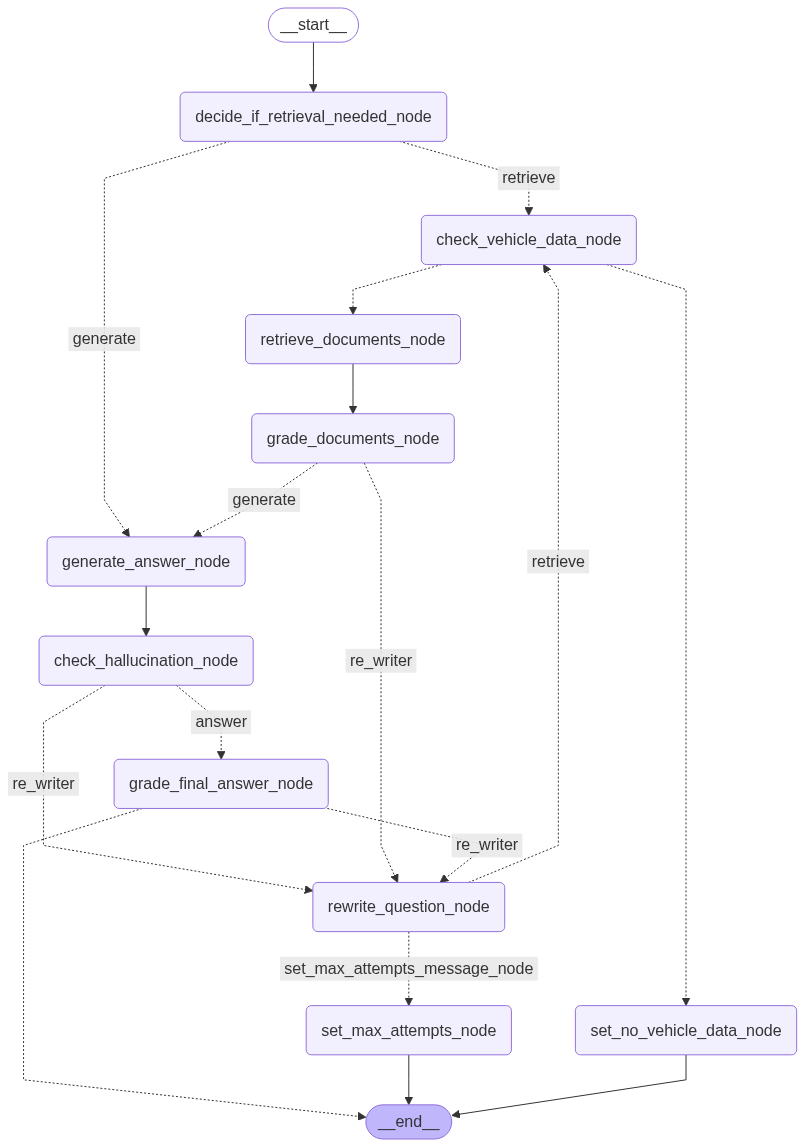

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [37]:
def save_response_json(resposta_final: dict, filename: str = "resultados_rag_vw.json", modelo_rag: str = "rag"):
    """
    Gets the final response from the RAG process and saves it to a JSON file.
    
    Args:
        resposta_final (dict): The final response dictionary containing the question, context, and answer.
        filename (str): The name of the JSON file to save the results. Defaults to 'resultados_rag.json'.
        
    Returns:
        None: The function saves the response to a JSON file and does not return anything.
    """
    
    contexto_para_resposta_final = "\n\n---\n\n".join(
        doc.page_content if hasattr(doc, 'page_content') else str(doc) 
        for doc in resposta_final.get("relevant_documents", [])
    )
    
    resultado = {
        # --- Campos Padrão Solicitados ---
        "id_pergunta": f"P_{str(uuid.uuid4())[:8]}",
        "pergunta_usuario": resposta_final.get("question"),
        "contexto_recuperado": contexto_para_resposta_final, # Usando os documentos relevantes
        "resposta_gerada": resposta_final.get("generation"),
        "modelo_rag": modelo_rag,
        "metadados": {
            "marca": resposta_final.get("brand"),
            "modelo": resposta_final.get("model"),
            "ano": str(resposta_final.get("year", "")) # Garantir que ano seja string e tenha um default
        },

        # --- Detalhes Adicionais do Self-RAG (agora no nível principal) ---
        "decisao_recuperacao_inicial": resposta_final.get("decision", "N/A"),
        "contagem_documentos_brutos_recuperados": len(resposta_final.get("documents", [])),
        "contagem_documentos_relevantes": len(resposta_final.get("relevant_documents", [])),
        
        # A avaliação detalhada de cada documento (pode ser uma lista grande)
        # Esta lista contém dicionários, cada um com 'document' e 'relevance'
        "avaliacao_detalhada_documentos": resposta_final.get("support_evaluation", []),
        
        "score_alucinacao_resposta": resposta_final.get("hallucination_score", "N/A"),
        "score_utilidade_resposta": resposta_final.get("utility_score", "N/A"),
        "score_binario_satisfacao": resposta_final.get("binary_score", "N/A"),
        "tentativas_de_reescrita": resposta_final.get("rewrite_attempts", 0),

        # Se você quiser incluir o conteúdo dos documentos brutos no JSON:
        # "conteudo_documentos_brutos": raw_docs_content_str,
    }


    try:
        with open(filename, 'r', encoding='utf-8') as f:
            lista_resultados = json.load(f)
    except (FileNotFoundError, json.JSONDecodeError):
        lista_resultados = []
        
    lista_resultados.append(resultado)
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(lista_resultados, f, ensure_ascii=False, indent=4)
        
    print(f"✅ Resposta salva com sucesso em '{filename}'")

## **Questions** 

### **Volkswagen**

In [38]:
question = [
    "Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?", # 1
    "Como eu conecto meu celular Android no carro para usar os aplicativos na tela?", # 2
    "Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?", # 3
    "A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?", # 4
    "Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?", # 5
    "Como eu ajusto a hora no painel do carro?", # 6
    "Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?", # 7
    "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", # 8
    "Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?", # 9
    "Quando é a próxima revisão do carro? É por tempo ou por quilometragem?" # 10
]

### 1 - Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?

In [39]:
response = graph.invoke({"question": question[0], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho de motor '
             '(parece um motorzinho). O que pode ser e o que eu devo fazer?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Acendeu uma luz amarela no painel com um desenho

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657358669}, page_content='## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de controle se acendem quando a ignição é ligada, e devem se apagar quando o motor estiver em funcionamento ou durante a condução.  \nConforme a versão, o display do instrumento combinado pode exibir mensagens de texto adicionais com informações mais detalhadas ou solicitações para alguma ação → Página 17.  \nDe acordo com os equipamentos do veículo, é possível que, em vez de uma luz de advertência, um símbolo seja exibido no display do instrumento combinado.  \nQuando algumas luzes de advertência e de controle se acendem, também soam sinais sonoros.  \n<!-- image -->  \n<!--

2025-06-02 16:16:51,899 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:16:54,926 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: A luz amarela no painel com o desenho de um motor indica que a unidade de controle do motor está avariada (Electronic Power Control). É importante que você verifique o motor imediatamente. Recomenda-se que você dirija até uma Concessionária Volkswagen para que o motor seja verificado. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e conduzir com cuidado até a concessionária mais próxima.


Resposta gerada: A luz amarela no painel com o desenho de um motor indica que a unidade de controle do motor está avariada (Electronic Power Control). É importante que você verifique o motor imediatamente. Recomenda-se que você dirija até uma Concessionária Volkswagen para que o motor seja verificado. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e conduzir com cuidado até a concessionária mais próxima.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657358669}, page_content='## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de controle se acendem quando a ignição é ligada, e devem se apagar quando o motor estiver em funcionamento ou durante a condução.  \nConforme a versão, o display do instrumento combinado pode exibir mensagens de texto adicionais com informações mais detalhadas ou solicitações para alguma ação → Página 17.  \nDe acordo com os equipamentos do veículo, é possível que, em vez de uma luz de advertência, um símbolo seja exibido no display do instrumento combinado.  \nQuando algumas luzes de advertência e de controle se acendem, também soam sinais sonoros.  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->', '## Mensagem de advertência de prioridade 2  \nA luz de advertência 

2025-06-02 16:16:55,845 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:16:55,846 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de controle se acendem quando a ignição é ligada, e devem se apagar quando o motor estiver em funcionamento ou durante a condução.  \nConforme a versão, o display do instrumento combinado pode exibir mensagens de texto adicionais com informações mais detalhadas ou solicitações para alguma ação → Página 17.  \nDe acordo com os equipamentos do veículo, é possível que, em vez de uma luz de advertência, um símbolo seja exibido no display do instrumento combinado.  \nQuando algumas luzes de advertência e de controle se acendem, também soam sinais sonoros.  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->', '## Mensagem de advertência de prioridade 2  \nA luz de advertência 

2025-06-02 16:16:56,768 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657358669}, page_content='## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de controle se acendem quando a ignição é ligada, e devem se apagar quando o motor estiver em funcionamento ou durante a condução.  \nConforme a versão, o display do instrumento combinado pode exibir mensagens de texto adicionais com informações mais detalhadas ou solicitações para alguma ação → Página 17.  \nDe acordo com os equipamentos do veículo, é possível que, em vez de uma luz de advertência, um símbolo seja exibido no displa

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:16:56,776 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Acendeu uma luz amarela no painel com um desenho de motor (parece um motorzinho). O que pode ser e o que eu devo fazer?' generation='A luz amarela no painel com o desenho de um motor indica que a unidade de controle do motor está avariada (Electronic Power Control). É importante que você verifique o motor imediatamente. Recomenda-se que você dirija até uma Concessionária Volkswagen para que o motor seja verificado. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e conduzir com cuidado até a concessionária mais próxima.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunt

2025-06-02 16:16:57,399 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:16:57,400 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:16:57,401 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:16:57,402 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Acendeu uma luz amarela no painel com um desenho de motor (parece um '
 'motorzinho). O que pode ser e o que eu devo fazer?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657358669}, page_content='## Luzes de advertência e de controle  \nAs luzes de advertência e de controle indicam alertas → , avarias → ou funções específicas. Algumas luzes de advertência e de controle se acendem quando a ignição é ligada, e devem se apagar quando o motor estiver em funcionamento ou durante a condução.  \nConforme a versão, o display do instrumento combinado pode exibir mensagens de texto adicionais com informações mais detalhadas ou solicitações para alguma ação → Página 17.  \nDe acordo com os equipamentos do veículo, é possível que, em vez de uma luz de advertência, um símbolo seja exibido no display do instrumento combinado.  \nQuando

In [40]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
A luz amarela no painel com o desenho de um motor indica que a unidade de controle do motor está avariada (Electronic Power Control). É importante que você verifique o motor imediatamente. Recomenda-se que você dirija até uma Concessionária Volkswagen para que o motor seja verificado. Se a luz estiver piscando, isso pode indicar um problema com o catalisador, e você deve diminuir a velocidade e conduzir com cuidado até a concessionária mais próxima.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 2 - Como eu conecto meu celular Android no carro para usar os aplicativos na tela?

In [41]:
response = graph.invoke({"question": question[1], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
2025-06-02 16:17:21,619 - __main__ - INFO - NODE: run_retrieval

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:17:21,620 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
  

2025-06-02 16:17:22,438 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:17:22,439 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:17:22,440 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:17:22,441 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
  

2025-06-02 16:17:23,255 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:17:23,256 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'year': '2025'}
2025-06-02 16:17:23,258 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:17:23,259 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:17:23,530 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:17:23,532 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu conecto meu celular Android no carro para usar os '
             'aplicativos na tela?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
2025-06-02 1

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:17:23,536 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:17:23,536 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:17:23,586 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:17:23,598 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:17:23,599 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:17:23,599 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:17:23,602 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:17:23,615 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:17:23,616 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:17:23,616 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:17:23,616 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:17:23,617 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:17:23,617 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:17:23,618 - __main__ - INFO - Received query: 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'


INFO:__main__:Received query: 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'


2025-06-02 16:17:23,618 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:17:24,737 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do 

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:17:24,742 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 

2025-06-02 16:17:25,440 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:25,442 - __main__ - INFO - Documento '## Estabelecer conexão  
Para utilizar o Android A...' avaliado como: Relevant


INFO:__main__:Documento '## Estabelecer conexão  
Para utilizar o Android A...' avaliado como: Relevant


2025-06-02 16:17:25,442 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Estabelecer conexão  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \n- -As premissas para utilização do Android Auto™ precisam ser atendidas.\n- -Pressionar o botão  APP .\n- -Selecione o seu telefone móvel conectado pressionado sobre o ícone correspondente.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant

2025-06-02 16:17:26,330 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:26,331 - __main__ - INFO - Documento '## Estabelecer conexão  
Quando um telefone móvel ...' avaliado como: Relevant


INFO:__main__:Documento '## Estabelecer conexão  
Quando um telefone móvel ...' avaliado como: Relevant


2025-06-02 16:17:26,332 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## NOTA  \nO Android Auto™ é uma plataforma de software do Google que permite o acesso a determinados aplicativos e recursos de seu telefone móvel por meio da tela sensível ao toque do Sistema Infotainment do carro ou assistentes de voz do telefone móvel. Uma vez conectado o Android Auto™  \nespelha uma versão simplificada da interface do telefone móvel otimizada e própia para direção. Toda a imagem gerada e funcionalidades exibidas são comandadas pelo próprio telefone móvel nessa situação. Assim, qualquer situação que influencie a performance do telefone móvel, afetará diretamente a execução na tela do Infotainment, causando a impressão que o Infotainment é que está com falha, quando na verdade as funções comandadas pelo veículo estão operando normalmente  \n<!--

2025-06-02 16:17:26,959 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:26,960 - __main__ - INFO - Documento '## NOTA  
O Android Auto™ é uma plataforma de soft...' avaliado como: Relevant


INFO:__main__:Documento '## NOTA  
O Android Auto™ é uma plataforma de soft...' avaliado como: Relevant


2025-06-02 16:17:26,960 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Requisitos Android Auto™  \nPara utilizar o Android Auto™ precisam ser atendidas as seguintes premissas:  \n-  O telefone móvel precisa suportar o Android Auto™.\n-  O telefone móvel precisa ser conectado ao aparelho com um cabo USB.\n-  O cabo USB utilizado precisa ser um cabo original do fabricante do telefone móvel.\n-  Dependendo do telefone móvel utilizado, precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta

2025-06-02 16:17:27,556 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:27,557 - __main__ - INFO - Documento '## Requisitos Android Auto™  
Para utilizar o Andr...' avaliado como: Relevant


INFO:__main__:Documento '## Requisitos Android Auto™  
Para utilizar o Andr...' avaliado como: Relevant


2025-06-02 16:17:27,559 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## App-Connect  \nAlguns menus e funções não estão disponíveis em todos os países para todos os veículos.  \nNo menu App-Connect estão disponíveis as seguintes interfaces:  \n- -Apple CarPlay™ 1)\n- -Android Auto™ 2)  \n<!-- image -->  \nPara evitar distrair o condutor, durante a condução somente podem ser utilizados aplicativos especialmente aplicados → .  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \nDependendo do telefone móvel utilizado, ocorre uma conexão por meio da respectiva interface.  \nCom isso, é possível que as funções e o conteúdo exibidos nos telefones móveis sejam exibidos e comandados no display.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relev

2025-06-02 16:17:28,275 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:28,276 - __main__ - INFO - Documento '## App-Connect  
Alguns menus e funções não estão ...' avaliado como: Relevant


INFO:__main__:Documento '## App-Connect  
Alguns menus e funções não estão ...' avaliado como: Relevant


2025-06-02 16:17:28,277 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Estabelecer conexão  \nPara utilizar o Apple CarPlay™ o telefone móvel precisa suportar o Apple CarPlay™.  \nDependendo do telefone móvel utilizado, é possível conectar ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nConfirmar no telefone móvel e no display do rádio a utilização do Apple CarPlay™.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da perg

2025-06-02 16:17:28,894 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:17:28,895 - __main__ - INFO - Documento '## Estabelecer conexão  
Para utilizar o Apple Car...' avaliado como: Irrelevant


INFO:__main__:Documento '## Estabelecer conexão  
Para utilizar o Apple Car...' avaliado como: Irrelevant


2025-06-02 16:17:28,896 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Estabelecer conexão  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do aparelho e no display do telefone móvel.  \n- -As premissas para utilização do Apple CarPlay™ precisam ser atendidas.\n- -Pressionar o botão  APP .\n- -Selecione o seu telefone móvel conectado pressionado sobre o ícone correspondente.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, u

2025-06-02 16:17:29,708 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:17:29,708 - __main__ - INFO - Documento '## Estabelecer conexão  
Quando um telefone móvel ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Estabelecer conexão  
Quando um telefone móvel ...' avaliado como: Irrelevant


2025-06-02 16:17:29,709 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document="2) Android Auto™ é uma marca certificada do Google Inc.  \nManter pressionado para mostrar uma janela pop-up com os símbolos especiais baseados nessas letras. Aplicar os caracteres desejados por meio de toque. Alguns sinais especiais também podem ser transcritos (por exemplo, 'AE' para 'Ä'). Letras e   \n<!-- image -->  \nTocar para alternar entre maiúsculas e minúsculas e para números e caracteres especiais.  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \nTocar para inserir um espaço em branco.  \nTocar para assumir a sugestão da linha de introdução e fechar a máscara de inserção.  \nTocar para apagar símbolos na linha de inserção da direita para a esquerda. Manter pressionado, para apagar vários símbolos.  \n<!-- image -->  \nTocar para fechar a máscara

2025-06-02 16:17:30,319 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:17:30,320 - __main__ - INFO - Documento '2) Android Auto™ é uma marca certificada do Google...' avaliado como: Irrelevant


INFO:__main__:Documento '2) Android Auto™ é uma marca certificada do Google...' avaliado como: Irrelevant


2025-06-02 16:17:30,320 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## NOTA  \nO Apple CarPlay™ é uma plataforma de software da Apple que permite o acesso a determinados aplicativos e recursos de seu telefone móvel por meio da tela sensível ao toque do Sistema Infotainment do carro ou assistentes de voz do telefone móvel. Uma vez conectado o Apple CarPlay™ espelha uma versão simplificada da interface do telefone móvel otimizada e própia para direção. Toda a imagem gerada e funcionalidades exibidas são comandadas pelo próprio telefone móvel nessa situação. Assim, qualquer situação que influencie a performance do telefone móvel, afetará diretamente a execução na tela do Infotainment, causando a impressão que o Infotainment é que está com falha, quando na verdade as funções comandadas pelo veículo estão operando normalmente.  \n- Par

2025-06-02 16:17:30,951 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:17:30,952 - __main__ - INFO - Documento '## NOTA  
O Apple CarPlay™ é uma plataforma de sof...' avaliado como: Irrelevant


INFO:__main__:Documento '## NOTA  
O Apple CarPlay™ é uma plataforma de sof...' avaliado como: Irrelevant


2025-06-02 16:17:30,952 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' document='## Particularidades  \nDurante uma conexão Android Auto™ ativa, são válidas as seguintes particularidades:  \n- -Um aparelho Android Auto™ ativo pode estar simultaneamente conectado com o rádio por Bluetooth.\n- -Conexões por Bluetooth entre outros dispositivos móveis e o rádio não são possíveis.\n- -Funções de telefone são possíveis através do Android Auto™. Se o aparelho Android Auto™ estiver conectado simultaneamente por Bluetooth com o rádio, a função de telefone do rádio também pode ser utilizada.\n- -Chamadas telefônicas simultâneas por Android Auto™ e pelo rádio não são possíveis.\n- -Um aparelho Android Auto™ ativo pode ser utilizado como dispositivo de mídia no menu Media.\n- -No display do instrumento combinado, não ocorre a exibição de rotas de navegaçã

2025-06-02 16:17:31,492 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:17:31,493 - __main__ - INFO - Documento '## Particularidades  
Durante uma conexão Android ...' avaliado como: Relevant


INFO:__main__:Documento '## Particularidades  
Durante uma conexão Android ...' avaliado como: Relevant


2025-06-02 16:17:31,493 - __main__ - INFO - 6 documentos relevantes encontrados.


INFO:__main__:6 documentos relevantes encontrados.


2025-06-02 16:17:31,495 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:17:31,495 - __main__ - INFO - 6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .'),
 Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Vol

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .'), Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 45837925665735

2025-06-02 16:17:31,550 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:17:35,824 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Para conectar seu celular Android no Volkswagen Polo 2025 e usar os aplicativos na tela, siga os passos abaixo:

1. **Verifique os requisitos**: Certifique-se de que seu telefone móvel suporta o Android Auto™ e que você possui um cabo USB original do fabricante do telefone.

2. **Conexão**: Conecte seu telefone ao rádio do carro usando o cabo USB. Se o seu telefone e o carro suportarem, você também pode conectar via Wi-Fi.

3. **Instalação do aplicativo**: Dependendo do modelo do seu telefone, pode ser necessário instalar um aplicativo específico para utilizar o Android Auto™.

4. **Siga as instruções**: Quando conectar o telefone pela primeira vez, siga as instruções que aparecerão no display do rádio e no display do telefone.

5. **Acesso ao Android Auto™**: Pressione o botão do rádio para acessar as funções do Android Auto™. Você pode selecionar seu telefone móvel conectado pressionando o ícone corresponde

Resposta gerada: Para conectar seu celular Android no Volkswagen Polo 2025 e usar os aplicativos na tela, siga os passos abaixo:

1. **Verifique os requisitos**: Certifique-se de que seu telefone móvel suporta o Android Auto™ e que você possui um cabo USB original do fabricante do telefone.

2. **Conexão**: Conecte seu telefone ao rádio do carro usando o cabo USB. Se o seu telefone e o carro suportarem, você também pode conectar via Wi-Fi.

3. **Instalação do aplicativo**: Dependendo do modelo do seu telefone, pode ser necessário instalar um aplicativo específico para utilizar o Android Auto™.

4. **Siga as instruções**: Quando conectar o telefone pela primeira vez, siga as instruções que aparecerão no display do rádio e no display do telefone.

5. **Acesso ao Android Auto™**: Pressione o botão do rádio para acessar as funções do Android Auto™. Você pode selecionar seu telefone móvel conectado pressionando o ícone correspondente no menu.

Após esses passos, você poderá acessar os aplic

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .', '## Estabelecer conexão  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \n- -As premissas para utilização do Android Auto™ precisam ser atendidas.\n- -Pressionar 

2025-06-02 16:17:36,793 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:17:36,794 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .', '## Estabelecer conexão  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \n- -As premissas para utilização do Android Auto™ precisam ser atendidas.\n- -Pressionar 

2025-06-02 16:17:38,375 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .'),
 Document(metadata={'model': '

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:17:38,385 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Como eu conecto meu celular Android no carro para usar os aplicativos na tela?' generation='Para conectar seu celular Android no Volkswagen Polo 2025 e usar os aplicativos na tela, siga os passos abaixo:\n\n1. **Verifique os requisitos**: Certifique-se de que seu telefone móvel suporta o Android Auto™ e que você possui um cabo USB original do fabricante do telefone.\n\n2. **Conexão**: Conecte seu telefone ao rádio do carro usando o cabo USB. Se o seu telefone e o carro suportarem, você também pode conectar via Wi-Fi.\n\n3. **Instalação do aplicativo**: Dependendo do modelo do seu telefone, pode ser necessário instalar um aplicativo específico para utilizar o Android Auto™.\n\n4. **Siga as instruções**: Quando conectar o telefone pela primeira vez, siga as instruções que aparecerão no display do rádio e no display do telefone.\n\n5. **Acesso ao Android Auto™**: Pressione o botão do

2025-06-02 16:17:39,023 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:17:39,024 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:17:39,026 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:17:39,027 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> 'Como eu conecto meu celular Android no carro para usar os aplicativos na tela?'
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657359850}, page_content='## Estabelecer conexão  \nPara utilizar o Android Auto™ o telefone móvel precisa suportar o Android Auto™ e ser conectado ao rádio com um cabo USB ou com uma conexão wireless através do Wi-fi.  \nDependendo do telefone móvel utilizado , precisa ser instalado um aplicativo adequado para utilizar o Android Auto™ no aparelho.  \nQuando um telefone móvel é conectado pela primeira vez, seguir as instruções no display do rádio e no display do telefone móvel.  \nPressionar o botão do rádio  para acessar as funções do Android Auto™.  \nPara acessar os comandos do rádio, pressionar o atalho para a tela principal  .'),
 Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Vol

In [42]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Para conectar seu celular Android no Volkswagen Polo 2025 e usar os aplicativos na tela, siga os passos abaixo:

1. **Verifique os requisitos**: Certifique-se de que seu telefone móvel suporta o Android Auto™ e que você possui um cabo USB original do fabricante do telefone.

2. **Conexão**: Conecte seu telefone ao rádio do carro usando o cabo USB. Se o seu telefone e o carro suportarem, você também pode conectar via Wi-Fi.

3. **Instalação do aplicativo**: Dependendo do modelo do seu telefone, pode ser necessário instalar um aplicativo específico para utilizar o Android Auto™.

4. **Siga as instruções**: Quando conectar o telefone pela primeira vez, siga as instruções que aparecerão no display do rádio e no display do telefone.

5. **Acesso ao Android Auto™**: Pressione o botão do rádio para acessar as funções do Android Auto™. Você pode selecionar seu telefone móvel conectado pressionando o ícone correspondente no menu.

Após esses passos, você poderá acessar 

### 3 - Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?

In [43]:
response = graph.invoke({"question": question[2], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?'

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:18:08,698 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de n

2025-06-02 16:18:10,466 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:18:10,466 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:18:10,467 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:18:10,468 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de n

2025-06-02 16:18:11,586 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:18:11,588 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'year': '2025'}
2025-06-02 16:18:11,590 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:18:11,593 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:18:11,930 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:18:11,931 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu '
             'encontro essa informação no carro?',
 'veh

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:18:11,933 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:18:11,934 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:18:11,962 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:18:11,966 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:18:11,967 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:18:11,967 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:18:11,970 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:18:11,988 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:18:11,988 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:18:11,988 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:18:11,989 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:18:11,989 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:18:11,990 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:18:11,990 - __main__ - INFO - Received query: 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'


INFO:__main__:Received query: 'Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?'


2025-06-02 16:18:11,990 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:18:12,935 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por e

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:18:12,940 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após adequar a pressão dos pneus, atentar para a recolocação das tampas das válvulas e seguir as infor

2025-06-02 16:18:13,637 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:13,638 - __main__ - INFO - Documento '## Verificar a pressão dos pneus  
Verificar a pre...' avaliado como: Relevant


INFO:__main__:Documento '## Verificar a pressão dos pneus  
Verificar a pre...' avaliado como: Relevant


2025-06-02 16:18:13,638 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='- Em pneus liberados pela Volkswagen é garantido que as medidas reais estão de acordo com o veículo. Em caso de outros tipos de pneu, os vendedores de pneus devem fornecer um atestado do fabricante certificando que o tipo de pneu é igualmente compatível com o veículo. Guardar bem o atestado e conservá-lo dentro do veículo.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.



2025-06-02 16:18:14,323 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:14,324 - __main__ - INFO - Documento '- Em pneus liberados pela Volkswagen é garantido q...' avaliado como: Irrelevant


INFO:__main__:Documento '- Em pneus liberados pela Volkswagen é garantido q...' avaliado como: Irrelevant


2025-06-02 16:18:14,325 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='## Pressão dos pneus  \n Observe no início desse capítulo na página 254.  \nFig. 196 Etiqueta com as pressões dos pneus.  \n<!-- image -->  \nFig. 197 Na parte interna da portinhola do tanque de combustível: etiqueta com a pressão dos pneus.  \n<!-- image -->  \nIndicações na etiqueta de pressão dos pneus → Fig. 196:  \n- Pressão dos pneus para os pneus do eixo dianteiro. A\n- Pressão dos pneus para os pneus do eixo traseiro. B\n- Orientação: verificar regularmente a pressão nos pneus frios. 1\n- Pressão dos pneus com carregamento parcial. 2\n- Dependendo da versão do veículo: Pressão de conforto dos pneus com carregamento parcial. 3  \n<!-- image -->  \n<!-- image -->  \nPressão dos pneus com carregamento total.  \n<!-- image -->  \nPressão dos

2025-06-02 16:18:14,916 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:14,917 - __main__ - INFO - Documento '## Pressão dos pneus  
 Observe no início desse ca...' avaliado como: Relevant


INFO:__main__:Documento '## Pressão dos pneus  
 Observe no início desse ca...' avaliado como: Relevant


2025-06-02 16:18:14,918 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='- ● O condutor é responsável pela correta pressão dos pneus em todos os pneus do veículo. A pressão dos pneus recomendada está sempre disponível em uma etiqueta adesiva → Página 258.  \n- ● O sistema de controle dos pneus só pode cumprir sua função se todos os pneus frios estiverem com a pressão dos pneus correta.\n- ● Usar valores de pressão dos pneus incorretos pode causar acidentes e danos aos pneus. Todos os pneus precisam ter sempre a pressão adequada ao carregamento → Página 258.\n- ● Antes de cada condução, encher sempre os pneus com a pressão dos pneus correta → Página 258.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
     

2025-06-02 16:18:15,584 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:15,585 - __main__ - INFO - Documento '- ● O condutor é responsável pela correta pressão ...' avaliado como: Relevant


INFO:__main__:Documento '- ● O condutor é responsável pela correta pressão ...' avaliado como: Relevant


2025-06-02 16:18:15,585 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='- ● Verificar regularmente a pressão com o pneu frio. Se necessário, calibrar os pneus montados no carro a frio de acordo com os dados indicados na etiqueta → Página 258.\n- ● Verificar os pneus regularmente, procurando sinais de desgaste e de danos.\n- ● Nunca exceder a velocidade máxima e a capacidade de carga permitidas para os pneus montados.  \n<!-- image -->  \nUma pressão dos pneus muito baixa aumenta o consumo de combustível e o desgaste do pneu.  \n<!-- image -->  \nAo conduzir pela primeira vez com pneus novos em alta velocidade, eles podem se expandir um pouco e, assim, pode ser emitido um único alerta de pressão dos pneus.  \nSubstituir pneus velhos somente por pneus liberados pela Volkswagen para o respectivo modelo de veículo.'
DEB

2025-06-02 16:18:16,563 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:16,564 - __main__ - INFO - Documento '- ● Verificar regularmente a pressão com o pneu fr...' avaliado como: Relevant


INFO:__main__:Documento '- ● Verificar regularmente a pressão com o pneu fr...' avaliado como: Relevant


2025-06-02 16:18:16,565 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='| Informações ao usuário final sobre valores de comparação entre os pneus básicos disponíveis (proce- dimentos de teste normatizados) →Página 287: | Informações ao usuário final sobre valores de comparação entre os pneus básicos disponíveis (proce- dimentos de teste normatizados) →Página 287: | Informações ao usuário final sobre valores de comparação entre os pneus básicos disponíveis (proce- dimentos de teste normatizados) →Página 287:                                                                                                                                                                                                                                                                                                        |'
DEBUG:__main__:G

2025-06-02 16:18:18,162 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:18,163 - __main__ - INFO - Documento '| Informações ao usuário final sobre valores de co...' avaliado como: Irrelevant


INFO:__main__:Documento '| Informações ao usuário final sobre valores de co...' avaliado como: Irrelevant


2025-06-02 16:18:18,163 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='## Adequar a pressão dos pneus  \nCom a pressão correta dos pneus, reduz-se a resistência à rodagem e, assim, também o consumo de combustível.  \nNa compra de pneus novos, atentar para que os pneus sejam otimizados com relação à resistência à rodagem.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-cha

2025-06-02 16:18:18,953 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:18,954 - __main__ - INFO - Documento '## Adequar a pressão dos pneus  
Com a pressão cor...' avaliado como: Irrelevant


INFO:__main__:Documento '## Adequar a pressão dos pneus  
Com a pressão cor...' avaliado como: Irrelevant


2025-06-02 16:18:18,955 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='<!-- image -->  \nPressão dos pneus para a roda de emergência.  \nA etiqueta adesiva indica apenas a pressão correta para os pneus liberados e se encontra na parte interna da portinhola do tanque de combustível → Fig. 197.  \nDependendo da versão do veículo, a aparência da etiqueta pode variar. Podem estar contidos tamanhos adicionais de pneus → Página 262.  \nUma pressão dos pneus muito baixa ou muito alta encurta a vida útil dos pneus e tem efeitos desfavoráveis sobre o comportamento de direção do veículo → . A pressão correta dos pneus é especialmente importante, principalmente em alta velocidade . Uma pressão dos pneus inadequada leva a um desgaste elevado do pneu ou até ao estouro do pneu.'
DEBUG:__main__:Generated evaluation prompt: 
     

2025-06-02 16:18:21,410 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:21,410 - __main__ - INFO - Documento '<!-- image -->  
Pressão dos pneus para a roda de ...' avaliado como: Relevant


INFO:__main__:Documento '<!-- image -->  
Pressão dos pneus para a roda de ...' avaliado como: Relevant


2025-06-02 16:18:21,411 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='| falta de balanceamento                      | 260      |\n| guardar a roda substituída                  | 261      |\n| identificação                               | 262      |\n| indicadores de desgaste do pneu             | 259      |\n| inscrição dos pneus                         | 262      |\n| número de inscrição dos pneus (TIN)         | 262      |\n| número de série                             | 262      |\n| penetração de corpos estranhos              | 260      |\n| pneus mais velhos                           | 256      |\n| pneus novos                                 | 256      |\n| pneus unidirecionais                        | 264      |\n| pressão dos pneus                           | 258      |  \n| profundidade do perfil         

2025-06-02 16:18:22,503 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:22,505 - __main__ - INFO - Documento '| falta de balanceamento                      | 26...' avaliado como: Irrelevant


INFO:__main__:Documento '| falta de balanceamento                      | 26...' avaliado como: Irrelevant


2025-06-02 16:18:22,507 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' document='Durante este período, atente para as seguintes precauções: após a instalação da roda de emergência com dimensões diferentes, a pressão deve ser verificada e corrigida, se necessário. Veja a pressão especificada no lado interno da portinhola do tanque de combustível. Em veículos com indicador de controle dos pneus, após a troca de roda, o sistema deve ser reprogramado → Página 252.  \nA roda com dimensões diferentes deve retornar o mais breve possível para sua condição inicial, após a reinstalação da roda e pneu normais do veículo, já reparados ou substituídos. Atente, também, para que a capacidade máxima de carga, especificada pelo código na lateral do pneu, não seja excedida.  \nPara reduzir as chances de danos nos pneus e rodas do seu veículo:

2025-06-02 16:18:23,680 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:23,681 - __main__ - INFO - Documento 'Durante este período, atente para as seguintes pre...' avaliado como: Relevant


INFO:__main__:Documento 'Durante este período, atente para as seguintes pre...' avaliado como: Relevant


2025-06-02 16:18:23,682 - __main__ - INFO - 6 documentos relevantes encontrados.


INFO:__main__:6 documentos relevantes encontrados.


2025-06-02 16:18:23,683 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:18:23,684 - __main__ - INFO - 6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- documents -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após a

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após adequar a pressão dos pneus, atentar para a recolocação das tampas das válvulas e seguir

2025-06-02 16:18:23,739 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:18:26,731 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: A calibragem certa dos pneus para o dia a dia do Volkswagen Polo 2025 pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta fornece as pressões recomendadas para os pneus do eixo dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado por alguns quilômetros.


Resposta gerada: A calibragem certa dos pneus para o dia a dia do Volkswagen Polo 2025 pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta fornece as pressões recomendadas para os pneus do eixo dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado por alguns quilômetros.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- documents -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a 

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após adequar a pressão dos pneus, atentar para a recolocação das tampas das válvulas e seguir as informações sobre o sistema de controle dos pneus → Página 252.\n- -Calibrar os pneus sempre com as pressões indi

2025-06-02 16:18:27,642 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:18:27,643 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após adequar a pressão dos pneus, atentar para a recolocação das tampas das válvulas e seguir as informações sobre o sistema de controle dos pneus → Página 252.\n- -Calibrar os pneus sempre com as pressões indi

2025-06-02 16:18:28,767 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- documents -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga 

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:18:28,771 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa informação no carro?' generation='A calibragem certa dos pneus para o dia a dia do Volkswagen Polo 2025 pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta fornece as pressões recomendadas para os pneus do eixo dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado por alguns quilômetros.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se

2025-06-02 16:18:29,421 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:18:29,422 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:18:29,423 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:18:29,424 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Qual é a calibragem certa dos pneus para o dia a dia e onde eu encontro essa '
 'informação no carro?')
- documents -> [Document(metadata={'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'pk': 458379256657360287}, page_content='## Verificar a pressão dos pneus  \nVerificar a pressão dos pneus somente se os pneus tiverem rodado não mais que alguns quilômetros e em baixa velocidade nas últimas 3 horas.  \n- -Verificar a pressão dos pneus pelo menos uma vez a cada 15 dias e, adicionalmente, antes de qualquer condução mais longa.\n- -Verificar a pressão apenas com os pneus frios. A pressão indicada para os pneus é válida para um pneu frio . A pressão dos pneus é mais alta em pneus quentes que em pneus frios. Por esse motivo, nunca solte o ar de pneus quentes para ajustar sua pressão.\n- -Adequar a pressão dos pneus sempre à condição de carga do veículo → Fig. 196  3 .\n- -Após a

In [44]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
A calibragem certa dos pneus para o dia a dia do Volkswagen Polo 2025 pode ser encontrada na etiqueta adesiva localizada na parte interna da portinhola do tanque de combustível. Essa etiqueta fornece as pressões recomendadas para os pneus do eixo dianteiro e traseiro, além de orientações para diferentes condições de carga. É importante verificar a pressão dos pneus quando eles estão frios, ou seja, após não terem rodado por alguns quilômetros.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 4 - A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?

In [45]:
response = graph.invoke({"question": question[3], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:18:43,090 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação d

2025-06-02 16:18:44,197 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:18:44,197 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:18:44,198 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:18:44,198 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação d

2025-06-02 16:18:44,972 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:18:44,974 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'year': '2025'}
2025-06-02 16:18:44,976 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:18:44,977 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:18:45,331 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:18:45,331 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual '
             'diz sobre isso? É seguro continuar

INFO:__main__:Starting 'retrieve' process with state: {'question': 'A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:18:45,333 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:18:45,333 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:18:45,361 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:18:45,364 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:18:45,365 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:18:45,365 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:18:45,367 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:18:45,380 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:18:45,380 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:18:45,381 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:18:45,381 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:18:45,382 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:18:45,383 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:18:45,383 - __main__ - INFO - Received query: 'A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'


INFO:__main__:Received query: 'A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?'


2025-06-02 16:18:45,385 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:18:46,138 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição d

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:18:46,143 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO botão bloqueador da alavanca seletora não está pressionado. O arranque é impedido. Encaixar o b

2025-06-02 16:18:46,904 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:46,905 - __main__ - INFO - Documento '## Luzes de advertência e de controle no instrumen...' avaliado como: Relevant


INFO:__main__:Documento '## Luzes de advertência e de controle no instrumen...' avaliado como: Relevant


2025-06-02 16:18:46,905 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='|         | Luzes de advertência ligadas. →Página 64                                                                                                                          |\n|         | Luzes de frenagem de emergência em funcionamento. →Página 65                                                                                                      |\n|          | Aceso: pisar no pedal do freio! (dar partida no motor). →Página 121 Piscando: o botão bloqueador da alavanca seletora                                             |\n|          | Sistema regulador de velocidade (GRA) ligado. →Página 129                                                                                                         |'
DEBUG:__main__:Generated evaluation prompt

2025-06-02 16:18:47,490 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:47,491 - __main__ - INFO - Documento '|         | Luzes de advertência ligadas. →Página ...' avaliado como: Relevant


INFO:__main__:Documento '|         | Luzes de advertência ligadas. →Página ...' avaliado como: Relevant


2025-06-02 16:18:47,491 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## ATENÇÃO  \nA observância das luzes de advertência acesas e das mensagens de texto é essencial para segurança do condutor e dos passageiros, evitando possíveis paradas do veículo, bem como eventuais acidentes.  \n- ● Nunca ignorar as luzes de advertência acesas e as mensagens de texto.\n- ● Parar o veículo assim que possível em um local seguro a todos os passageiros do veículo e aos demais condutores.\n- ● Estacionar o veículo a uma distância segura da pista de rodagem de forma que nenhuma das peças do sistema de escape entre em contato com materiais inflamáveis, como, por exemplo, grama seca, combustível, óleo etc.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é releva

2025-06-02 16:18:48,148 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:48,149 - __main__ - INFO - Documento '## ATENÇÃO  
A observância das luzes de advertênci...' avaliado como: Relevant


INFO:__main__:Documento '## ATENÇÃO  
A observância das luzes de advertênci...' avaliado como: Relevant


2025-06-02 16:18:48,150 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## NOTA  \nObservar sempre as luzes de controle acesas e as mensagens de texto para evitar danos no veículo.  \n- Com a ignição ligada, se uma pressão dos pneus muito baixa for detectada, a luz de controle é acesa  . Adicionalmente, ressoa um alerta sonoro e pode ser exibida uma mensagem de texto.\n- Se for detectada uma avaria do sistema com a ignição ligada, a luz de controle amarela  pisca por alguns minutos e depois se acende permanentemente. Adicionalmente, pode ser exibida uma mensagem de texto.\n- Conduzir em ruas não pavimentadas por muito tempo ou com uma forma de condução esportiva pode desativar o indicador de controle dos pneus temporariamente. A luz de controle exibe a falha de funcionamento, mas se apaga, no entanto, se as condi

2025-06-02 16:18:48,866 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:48,867 - __main__ - INFO - Documento '## NOTA  
Observar sempre as luzes de controle ace...' avaliado como: Irrelevant


INFO:__main__:Documento '## NOTA  
Observar sempre as luzes de controle ace...' avaliado como: Irrelevant


2025-06-02 16:18:48,868 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='Se as luzes de advertência estiverem acesas, pode ser indicada, por exemplo, uma mudança de direção ou mudança de faixa durante a rebocagem com o acionamento da alavanca dos indicadores de direção. As luzes de advertência são momentaneamente interrompidas.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            

2025-06-02 16:18:49,765 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:49,766 - __main__ - INFO - Documento 'Se as luzes de advertência estiverem acesas, pode ...' avaliado como: Irrelevant


INFO:__main__:Documento 'Se as luzes de advertência estiverem acesas, pode ...' avaliado como: Irrelevant


2025-06-02 16:18:49,767 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## Conduzir com o limitador de velocidade  \nO limite de velocidade pode ser interrompido a qualquer momento, pisando totalmente no pedal do freio e ultrapassando a resistência. Assim que a velocidade salva for ultrapassada, a luz de controle verde  pisca e poderá ser dada uma advertência sonora. A velocidade permanece salva.  \nAssim que a velocidade salva ficar abaixo do limite, a regulagem se liga novamente de modo automático.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta

2025-06-02 16:18:50,607 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:50,608 - __main__ - INFO - Documento '## Conduzir com o limitador de velocidade  
O limi...' avaliado como: Irrelevant


INFO:__main__:Documento '## Conduzir com o limitador de velocidade  
O limi...' avaliado como: Irrelevant


2025-06-02 16:18:50,609 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## Luz de controle na porta do condutor  \n Observe e no início desse capítulo na página 71.  \nNa porta do condutor encontra-se a luz de controle do travamento central → Página 11.  \nO veículo trava: o LED vermelho pisca por aproximadamente dois segundos em intervalos curtos, em seguida mais lentamente. A luz de controle não pisca, se o veículo tiver sido travado com o botão do travamento central na porta do condutor → Página 72.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergun

2025-06-02 16:18:51,364 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:51,365 - __main__ - INFO - Documento '## Luz de controle na porta do condutor  
 Observe...' avaliado como: Irrelevant


INFO:__main__:Documento '## Luz de controle na porta do condutor  
 Observe...' avaliado como: Irrelevant


2025-06-02 16:18:51,366 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## ATENÇÃO  \nA observância das luzes de advertência acesas e das mensagens de texto é essencial para a segurança do condutor e dos passageiros, evitando possíveis paradas do veículo, bem como eventuais acidentes.  \n- ● Nunca ignorar as luzes de advertência e as mensagens de texto.\n- ● Parar o veículo assim que possível em um local seguro a todos os passageiros do veículo e aos demais condutores.\n- A luz de advertência da pressão do óleo  não é um indicador do nível do óleo do motor. O nível do óleo do motor deve ser controlado em intervalos regulares, de preferência sempre que abastecer o tanque de combustível.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante

2025-06-02 16:18:52,206 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:18:52,208 - __main__ - INFO - Documento '## ATENÇÃO  
A observância das luzes de advertênci...' avaliado como: Irrelevant


INFO:__main__:Documento '## ATENÇÃO  
A observância das luzes de advertênci...' avaliado como: Irrelevant


2025-06-02 16:18:52,208 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='## Mensagem de advertência de prioridade 1  \nA luz de advertência central vermelha pisca ou está acesa - em parte junto com alertas sonoros ou símbolos adicionais.  Não prosseguir! Situação de perigo. Verificar a função avariada e eliminar a causa. Se necessário, procurar uma Concessionária Volkswagen.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.


2025-06-02 16:18:52,826 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:52,827 - __main__ - INFO - Documento '## Mensagem de advertência de prioridade 1  
A luz...' avaliado como: Relevant


INFO:__main__:Documento '## Mensagem de advertência de prioridade 1  
A luz...' avaliado como: Relevant


2025-06-02 16:18:52,828 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' document='|          |  Não prosseguir! Nível do fluido de freio muito baixo ou sistema de freio avariado. →Página 244                                                         |\n|          |  Não prosseguir! Temperatura do líquido de arrefe- cimento do motor muito alta ou ní- vel do líquido de arrefecimento do motor muito baixo. →Página 241 |\n|          |  Não prosseguir! Pressão do óleo do motor muito baixa. →Página 237                                                                                      |\n|          | Piscando:  Não prosseguir! Dire- ção avariada. →Página 126                                                                                              |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que

2025-06-02 16:18:53,762 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:18:53,763 - __main__ - INFO - Documento '|          |  Não prosseguir! Nível do fluido de f...' avaliado como: Relevant


INFO:__main__:Documento '|          |  Não prosseguir! Nível do fluido de f...' avaliado como: Relevant


2025-06-02 16:18:53,763 - __main__ - INFO - 5 documentos relevantes encontrados.


INFO:__main__:5 documentos relevantes encontrados.


2025-06-02 16:18:53,765 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:18:53,765 - __main__ - INFO - 5 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:5 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO botão bloqueador da alavanca seletora não está pressionado. O arranque é impedido. Encaix

2025-06-02 16:18:53,821 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:18:56,332 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: O manual do Volkswagen Polo 2025 indica que, se a luz do freio está acesa em vermelho e apitando, isso representa uma situação de perigo. É recomendado **não prosseguir** e verificar a função avariada, eliminando a causa do problema. Se necessário, deve-se procurar uma concessionária Volkswagen. Portanto, **não é seguro continuar** dirigindo com essa luz acesa.


Resposta gerada: O manual do Volkswagen Polo 2025 indica que, se a luz do freio está acesa em vermelho e apitando, isso representa uma situação de perigo. É recomendado **não prosseguir** e verificar a função avariada, eliminando a causa do problema. Se necessário, deve-se procurar uma concessionária Volkswagen. Portanto, **não é seguro continuar** dirigindo com essa luz acesa.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos s

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO botão bloqueador da alavanca seletora não está pressionado. O arranque é impedido. Encaixar o bloqueio da alavanca seletora → Página 121.', '|         | Luzes de advertência ligadas. →Página 64             

2025-06-02 16:18:57,264 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:18:57,266 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO botão bloqueador da alavanca seletora não está pressionado. O arranque é impedido. Encaixar o bloqueio da alavanca seletora → Página 121.', '|         | Luzes de advertência ligadas. →Página 64             

2025-06-02 16:18:58,238 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de co

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:18:58,247 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre isso? É seguro continuar?' generation='O manual do Volkswagen Polo 2025 indica que, se a luz do freio está acesa em vermelho e apitando, isso representa uma situação de perigo. É recomendado **não prosseguir** e verificar a função avariada, eliminando a causa do problema. Se necessário, deve-se procurar uma concessionária Volkswagen. Portanto, **não é seguro continuar** dirigindo com essa luz acesa.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.
            Depois, avalie o nív

2025-06-02 16:18:59,317 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:18:59,318 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:18:59,319 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:18:59,320 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('A luz do freio está acesa em vermelho e apitando! O que o manual diz sobre '
 'isso? É seguro continuar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359375}, page_content='## Luzes de advertência e de controle no instrumento combinado  \nAs luzes de controle acendem.  \n<!-- image -->  \n<!-- image -->  \nalavanca seletora P . Se o alerta não apagar, não prosseguir e procurar auxílio técnico especializado. Caso contrário, podem ocorrer danos significativos à transmissão.  \n-  Não prosseguir! Transmissão avariada. Deixar a transmissão esfriar na posição da\n- Pedal do freio não pressionado, por exemplo, durante a tentativa de selecionar outra posição de marcha com a alavanca seletora. Para engatar uma posição de marcha, pisar no pedal do freio.   \n<!-- image -->  \nAs luzes de controle piscam.  \n<!-- image -->  \nO

In [46]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
O manual do Volkswagen Polo 2025 indica que, se a luz do freio está acesa em vermelho e apitando, isso representa uma situação de perigo. É recomendado **não prosseguir** e verificar a função avariada, eliminando a causa do problema. Se necessário, deve-se procurar uma concessionária Volkswagen. Portanto, **não é seguro continuar** dirigindo com essa luz acesa.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 5 - Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?

In [47]:
response = graph.invoke({"question": question[4], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[1:tasks] Starting 1 ta

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:19:16,337 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão

2025-06-02 16:19:17,151 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:19:17,152 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:19:17,153 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:19:17,155 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão

2025-06-02 16:19:18,150 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:19:18,151 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:19:18,153 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:19:18,332 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:19:18,333 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no '
             'semáforo para economizar combustível. Como ele funciona e tem '
             'alguma situação que eu não deva usar?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:19:18,335 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:19:18,335 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:19:18,374 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:19:18,379 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:19:18,380 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:19:18,381 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:19:18,384 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:19:18,402 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:19:18,403 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:19:18,404 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:19:18,405 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:19:18,406 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:19:18,407 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:19:18,408 - __main__ - INFO - Received query: 'Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'


INFO:__main__:Received query: 'Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?'


2025-06-02 16:19:18,408 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:19:19,334 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360228}, page_content='## Desligamento automático dos consumidores  \nPor meio de um gerenciamento inteligente da rede elétrica, em caso de grande exigência da bateria do veículo, diferentes medidas são tomadas para evitar a descarga da bateria do veículo:  \n- -A rotação de marcha lenta é aumentada para que o alternador forneça mais corrente.\n- -Se necessário, limita-se o desempenho de alguns consumidores de energia ou os desliga totalmente, 

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:19:19,337 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Desligamento automático dos consumidores  \nPor meio de um gerenciamento inteligente da rede elétrica, em caso de grande exigência da bateria do veículo, diferentes medidas são tomadas para evitar a descarga da bateria do veículo:  \n- -A rotação de marcha lenta é aumentada para que o alternador forneça mais corrente.\n- -Se necessário, limita-se o desempenho de alguns consumidores de energia ou os desliga totalmente, em caso de emergência.\n- -Ao ligar o motor, a alimentação de tensão da tomada 12 V e do acendedor de cigarro pode ser temporariamente interrompida.  \nNão é sempre que o gerenciamento da rede elétrica pode evitar que a bateria do veículo seja descarregada. Isso pode 

2025-06-02 16:19:19,996 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:19,997 - __main__ - INFO - Documento '## Desligamento automático dos consumidores  
Por ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Desligamento automático dos consumidores  
Por ...' avaliado como: Irrelevant


2025-06-02 16:19:19,998 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Desligamento automático da ignição  \nSe o condutor se afastar do veículo com a chave do veículo com a ignição ligada, a ignição vai se desligar automaticamente depois de algum tempo. Se o farol baixo for ligado neste período, a luz de posição permanece ligada por aproximadamente 30 minutos. A luz de posição pode ser desligada com o travamento do veículo → Página 71 ou manualmente → Página 86.  \n-  Após o veículo reconhecer que o condutor está ausente com o desligamento automático do motor ativo, a ignição é automaticamente desligada após o decorrer de um determinado tempo.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica

2025-06-02 16:19:21,023 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:21,024 - __main__ - INFO - Documento '## Desligamento automático da ignição  
Se o condu...' avaliado como: Irrelevant


INFO:__main__:Documento '## Desligamento automático da ignição  
Se o condu...' avaliado como: Irrelevant


2025-06-02 16:19:21,025 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Deixar rodar  \nQuando o pé é retirado do pedal do acelerador, a alimentação de combustível do motor é interrompida e o consumo é baixado.  \nPor esse motivo, por exemplo na aproximação a um semáforo vermelho, deixar o veículo rodar sem acelerar. Somente quando o veículo reduzir demais ou o trecho de rodagem for maior, pisar no pedal da embreagem para desengatar. O motor funciona, então, em rotação de marcha lenta.  \nEm situações nas quais se deve esperar um tempo maior de parada, desligar o motor, por exemplo, em uma passagem de nível.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunt

2025-06-02 16:19:21,629 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:21,630 - __main__ - INFO - Documento '## Deixar rodar  
Quando o pé é retirado do pedal ...' avaliado como: Relevant


INFO:__main__:Documento '## Deixar rodar  
Quando o pé é retirado do pedal ...' avaliado como: Relevant


2025-06-02 16:19:21,630 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Desativar e ativar o sistema Start-Stop automaticamente  \n- -Para parar o veículo, pisar no pedal do freio e manter pressionado. Um pouco antes ou ao atingir a parada do veículo, o motor se desliga.\n- -Para dar nova partida no motor, retirar o pé do pedal do freio ou pisar no pedal do acelerador.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Cas

2025-06-02 16:19:22,240 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:22,241 - __main__ - INFO - Documento '## Desativar e ativar o sistema Start-Stop automat...' avaliado como: Relevant


INFO:__main__:Documento '## Desativar e ativar o sistema Start-Stop automat...' avaliado como: Relevant


2025-06-02 16:19:22,242 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='Dentro dos limites do sistema, o farol alto se liga e desliga automaticamente, dependendo das condições do ambiente e do trânsito, assim como da velocidade de condução .  \nA regulagem dinâmica do farol alto pode ser ativada e desativada nas configurações do veículo no sistema Infotainment .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrári

2025-06-02 16:19:23,375 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:23,377 - __main__ - INFO - Documento 'Dentro dos limites do sistema, o farol alto se lig...' avaliado como: Irrelevant


INFO:__main__:Documento 'Dentro dos limites do sistema, o farol alto se lig...' avaliado como: Irrelevant


2025-06-02 16:19:23,378 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Sistema Start-Stop  \n## Sistema Start-Stop  \nDependendo da versão do veículo ou do rádio, o sistema Start-Stop pode não estar disponível.  \nO sistema Start-Stop desliga o motor automaticamente ao parar o veículo e em fases de parada do veículo. Se necessário, o motor é ligado novamente automaticamente.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevan

2025-06-02 16:19:23,980 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:23,981 - __main__ - INFO - Documento '## Sistema Start-Stop  
## Sistema Start-Stop  
De...' avaliado como: Relevant


INFO:__main__:Documento '## Sistema Start-Stop  
## Sistema Start-Stop  
De...' avaliado como: Relevant


2025-06-02 16:19:23,982 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Sensor sem visibilidade, aviso de falha, o sistema se desliga  \nNo caso de avaria em um sensor, a área de detecção do sensor é desligada de modo permanente.  \nEm caso de mau funcionamento do auxilio de estacionamento, um aviso acústico continuo é emitido por aproximadamente 3 segundos quando for ligado pela primeira vez ou dependendo da versão do veículo, por meio de uma mensagem de texto com alerta sonoro e pelo piscar da luz de controle no botão  . Se os sensores estiverem sujos ou cobertos, o grupo de sensores correspondente é exibido na exibição do display do auxílio de estacionamento. Além disso, uma indicação de limpeza é exibida (dependendo da versão).  \n- -Limpar os sens

2025-06-02 16:19:25,008 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:25,009 - __main__ - INFO - Documento '## Sensor sem visibilidade, aviso de falha, o sist...' avaliado como: Irrelevant


INFO:__main__:Documento '## Sensor sem visibilidade, aviso de falha, o sist...' avaliado como: Irrelevant


2025-06-02 16:19:25,010 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='- -Nunca parar, dar marcha a ré ou desligar o motor na água.\n- -Veículos no contra fluxo provocam ondas que podem elevar o nível da água para seu veículo, inviabilizando a travessia do trecho alagado de forma segura.\n- -Na travessia de trechos alagados, veículos com sistema Start-Stop desativar o sistema manualmente → Página 118.  \n<!-- image -->  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
  

2025-06-02 16:19:25,635 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:25,636 - __main__ - INFO - Documento '- -Nunca parar, dar marcha a ré ou desligar o moto...' avaliado como: Relevant


INFO:__main__:Documento '- -Nunca parar, dar marcha a ré ou desligar o moto...' avaliado como: Relevant


2025-06-02 16:19:25,637 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Desligar temporariamente o monitoramento do interior do veículo  \n- -Ligar a ignição.\n- -Desativar o monitoramento do interior do veículo no sistema do rádio por meio do botão  OU por meio do botão configurações  , tocar na superfície de função  Carro  no menu Abrindo e fechando → Página 32, dependendo da versão do veículo e da versão do rádio .\n- -Fechar todas as portas e a tampa traseira.\n- -Travar o veículo com a chave do veículo.  \n<!-- image -->  \nO monitoramento do interior do veículo é desativado até o próximo travamento do veículo.  \nNas seguintes situações, é recomendável desativar o monitoramento do interior do veículo:  \n- -Se o veículo precisar ser carregado.\n-

2025-06-02 16:19:26,299 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:26,300 - __main__ - INFO - Documento '## Desligar temporariamente o monitoramento do int...' avaliado como: Irrelevant


INFO:__main__:Documento '## Desligar temporariamente o monitoramento do int...' avaliado como: Irrelevant


2025-06-02 16:19:26,301 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' document='## Ativação automática (dependendo da versão)  \nO auxílio de estacionamento também se liga se for conduzido com velocidade inferior a 15 km/h contra um obstáculo na área frontal. A ativação automática pode ser ligada no sistema do rádio.  \nA ativação automática funciona somente quando a velocidade de aproximadamente 15 km/h não for atingida pela primeira vez. Uma renovada ligação automática é possível se o auxílio de estacionamento for desligado e novamente ligado por meio do botão  no console central OU no display do rádio.  \nAlém disso, a ativação automática pode ser novamente ativada, desligando-se e ligando-se novamente a ignição.'
DEBUG:__main__:Generated evaluation prompt: 
 

2025-06-02 16:19:27,672 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:27,672 - __main__ - INFO - Documento '## Ativação automática (dependendo da versão)  
O ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Ativação automática (dependendo da versão)  
O ...' avaliado como: Irrelevant


2025-06-02 16:19:27,673 - __main__ - INFO - 4 documentos relevantes encontrados.


INFO:__main__:4 documentos relevantes encontrados.


2025-06-02 16:19:27,674 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:19:27,675 - __main__ - INFO - 4 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:4 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360228}, page_content='## Desligamento automático dos consumidores  \nPor meio de um gerenciamento inteligente da rede elétrica, em caso de grande exigência da bateria do veículo, diferentes medidas são tomadas para evitar a descarga da bateria do veículo:  \n- -A rotação de marcha lenta é aumentada para que o alternador forneça mais corrente.\n- -Se necessário, limita-se o desempenho de alguns consumidores de energia ou os desliga totalmente, em caso de emergência.\n- -Ao ligar o motor, a alimentação de tensão da tomada 12 V e do acendedor de cigarro pode ser temporariamente interrompida.  \nNão é sempre que

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359260}, page_content='## Deixar rodar  \nQuando o pé é retirado do pedal do acelerador, a alimentação de combustível do motor é interrompida e o consumo é baixado.  \nPor esse motivo, por exemplo na aproximação a um semáforo vermelho, deixar o veículo rodar sem acelerar. Somente quando o veículo reduzir demais ou o trecho de rodagem for maior, pisar no pedal da embreagem para desengatar. O motor funciona, então, em rotação de marcha lenta.  \nEm situações nas quais se deve esperar um tempo maior de parada, desligar o motor, por exemplo, em uma passagem de nível.'), Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657359333}, page_content='## Desativar e ativar o sistema Start-Stop aut

2025-06-02 16:19:27,723 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:19:30,224 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: O sistema que desliga o motor automaticamente no semáforo é chamado de sistema Start-Stop. Ele funciona desligando o motor quando o veículo para, como ao pisar no pedal do freio e mantê-lo pressionado. O motor é reativado automaticamente ao retirar o pé do freio ou ao pisar no acelerador.

Entretanto, existem situações em que você não deve usar esse sistema. Por exemplo, é recomendado desativar o sistema Start-Stop ao atravessar trechos alagados, pois o funcionamento do motor pode ser comprometido em condições de água. Além disso, nunca é aconselhável parar ou desligar o motor na água.


Resposta gerada: O sistema que desliga o motor automaticamente no semáforo é chamado de sistema Start-Stop. Ele funciona desligando o motor quando o veículo para, como ao pisar no pedal do freio e mantê-lo pressionado. O motor é reativado automaticamente ao retirar o pé do freio ou ao pisar no acelerador.

Entretanto, existem situações em que você não deve usar esse sistema. Por exemplo, é recomendado desativar o sistema Start-Stop ao atravessar trechos alagados, pois o funcionamento do motor pode ser comprometido em condições de água. Além disso, nunca é aconselhável parar ou desligar o motor na água.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360228

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Deixar rodar  \nQuando o pé é retirado do pedal do acelerador, a alimentação de combustível do motor é interrompida e o consumo é baixado.  \nPor esse motivo, por exemplo na aproximação a um semáforo vermelho, deixar o veículo rodar sem acelerar. Somente quando o veículo reduzir demais ou o trecho de rodagem for maior, pisar no pedal da embreagem para desengatar. O motor funciona, então, em rotação de marcha lenta.  \nEm situações nas quais se deve esperar um tempo maior de parada, desligar o motor, por exemplo, em uma passagem de nível.', '## Desativar e ativar o sistema Start-Stop automaticamente  \n- -Para parar o veículo, pisar no pedal do freio e manter pressionado. Um pouco antes ou ao atingir a parada do veículo, o motor se desliga.\n- -Para dar nova partida no motor, retirar o pé do pedal do freio ou pisar no pedal do acelerador.', '## Sist

2025-06-02 16:19:31,261 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:19:31,262 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Deixar rodar  \nQuando o pé é retirado do pedal do acelerador, a alimentação de combustível do motor é interrompida e o consumo é baixado.  \nPor esse motivo, por exemplo na aproximação a um semáforo vermelho, deixar o veículo rodar sem acelerar. Somente quando o veículo reduzir demais ou o trecho de rodagem for maior, pisar no pedal da embreagem para desengatar. O motor funciona, então, em rotação de marcha lenta.  \nEm situações nas quais se deve esperar um tempo maior de parada, desligar o motor, por exemplo, em uma passagem de nível.', '## Desativar e ativar o sistema Start-Stop automaticamente  \n- -Para parar o veículo, pisar no pedal do freio e manter pressionado. Um pouco antes ou ao atingir a parada do veículo, o motor se desliga.\n- -Para dar nova partida no motor, retirar o pé do pedal do freio ou pisar no pedal do acelerador.', '## Sist

2025-06-02 16:19:32,272 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360228}, page_content='## Desligamento automático dos consumidores  \nPor meio de um gerenciamento inteligente da rede elétrica, em caso de grande exigência da bateria do veículo, diferentes medidas são tomadas para evitar a descarga da bateria do veículo:  \n- -A rotação de marcha lenta é aumentada para que o alternador forneça mais corrente.\n- -Se necessário, limita-se o desempenho de alguns consumidores de energia ou os desliga totalmente, em caso de emergência.\n- -Ao ligar o motor, a alimentação de tensão da tomada 12 V e do acendedor de cigarro pode ser temporariame

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:19:32,282 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para economizar combustível. Como ele funciona e tem alguma situação que eu não deva usar?' generation='O sistema que desliga o motor automaticamente no semáforo é chamado de sistema Start-Stop. Ele funciona desligando o motor quando o veículo para, como ao pisar no pedal do freio e mantê-lo pressionado. O motor é reativado automaticamente ao retirar o pé do freio ou ao pisar no acelerador.\n\nEntretanto, existem situações em que você não deve usar esse sistema. Por exemplo, é recomendado desativar o sistema Start-Stop ao atravessar trechos alagados, pois o funcionamento do motor pode ser comprometido em condições de água. Além disso, nunca é aconselhável parar ou desligar o motor na água.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um a

2025-06-02 16:19:32,865 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:19:32,866 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:19:32,867 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:19:32,868 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Meu carro tem aquele sistema que desliga o motor sozinho no semáforo para '
 'economizar combustível. Como ele funciona e tem alguma situação que eu não '
 'deva usar?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360228}, page_content='## Desligamento automático dos consumidores  \nPor meio de um gerenciamento inteligente da rede elétrica, em caso de grande exigência da bateria do veículo, diferentes medidas são tomadas para evitar a descarga da bateria do veículo:  \n- -A rotação de marcha lenta é aumentada para que o alternador forneça mais corrente.\n- -Se necessário, limita-se o desempenho de alguns consumidores de energia ou os desliga totalmente, em caso de emergência.\n- -Ao ligar o motor, a alimentação de tensão da tomada 12 V e do acendedor de cigarro pode ser temporariamente interrompida.  \nNão é sempre que

In [48]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
O sistema que desliga o motor automaticamente no semáforo é chamado de sistema Start-Stop. Ele funciona desligando o motor quando o veículo para, como ao pisar no pedal do freio e mantê-lo pressionado. O motor é reativado automaticamente ao retirar o pé do freio ou ao pisar no acelerador.

Entretanto, existem situações em que você não deve usar esse sistema. Por exemplo, é recomendado desativar o sistema Start-Stop ao atravessar trechos alagados, pois o funcionamento do motor pode ser comprometido em condições de água. Além disso, nunca é aconselhável parar ou desligar o motor na água.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 6 - Como eu ajusto a hora no painel do carro?

In [49]:
response = graph.invoke({"question": question[5], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
2025-06-02 16:19:49,738 - __main__ - INFO - NODE: run_retrieval_decision_logic


INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:19:49,741 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu ajusto a hora no painel do carro?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu ajusto a hora no painel do carro?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
        - 'No Retrieval': Se a pergunta

2025-06-02 16:19:50,498 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:19:50,499 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:19:50,500 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:19:50,500 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu ajusto a hora no painel do carro?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu ajusto a hora no painel do carro?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
        - 'No Retrieval': Se a pergunta

2025-06-02 16:19:51,216 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:19:51,217 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Como eu ajusto a hora no painel do carro?',
 'year': '2025'}
2025-06-02 16:19:51,219 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:19:51,220 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:19:51,530 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:19:51,532 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu ajusto a hora no painel do carro?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu ajusto a hora no painel do carro?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
2025-06-02 16:19:51,534 - __main__ - INFO - Starting 'retrieve' process with state: {'question': 'Como eu ajusto a hora no painel do carro?', 'decision': '

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Como eu ajusto a hora no painel do carro?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:19:51,535 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:19:51,536 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:19:51,580 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:19:51,585 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:19:51,585 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:19:51,586 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:19:51,588 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:19:51,601 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:19:51,602 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:19:51,602 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:19:51,603 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:19:51,603 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:19:51,603 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:19:51,604 - __main__ - INFO - Received query: 'Como eu ajusto a hora no painel do carro?'


INFO:__main__:Received query: 'Como eu ajusto a hora no painel do carro?'


2025-06-02 16:19:51,604 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:19:52,332 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'),
 Document(metadata={'brand': 'Volkswagen', 'm

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:19:52,336 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema

2025-06-02 16:19:53,000 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:53,001 - __main__ - INFO - Documento '## Ajustar o horário através do sistema de rádio  ...' avaliado como: Relevant


INFO:__main__:Documento '## Ajustar o horário através do sistema de rádio  ...' avaliado como: Relevant


2025-06-02 16:19:53,002 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## Ajustar o horário através de instrumento combinado digital (Active Info Display)  \n- -No menu Dados de viagem , selecionar o indicador Autonomia .\n-  -Manter pressionado o botão  OK  no volante multifunções durante cerca de cinco segundos, ao soltar aparecerá o menu de serviços no display do instrumento combinado digital → Página 28.\n- -Selecionar o menu Hora .\n- -Ajustar o relógio com os botões de seta  ou  .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Cas

2025-06-02 16:19:53,626 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:53,627 - __main__ - INFO - Documento '## Ajustar o horário através de instrumento combin...' avaliado como: Relevant


INFO:__main__:Documento '## Ajustar o horário através de instrumento combin...' avaliado como: Relevant


2025-06-02 16:19:53,628 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## Ajustar o horário através do instrumento combinado analógico  \n- -Ligar a ignição.\n- -Para ajustar o relógio, pressionar o botão    no instrumento combinado → Página 17 para selecionar o indicador das horas.\n- -Para acertar as horas, pressionar o botão   brevemente. Os números serão trocados em ordem crescente. Manter o botão   pressionado para avanço rápido.\n- -Pressionar brevemente o botão    para selecionar o indicador dos minutos.\n- -Para acertar os minutos, pressionar o botão   brevemente. Os números serão trocados em ordem crescente. Manter o botão   pressionado para avanço rápido.\n- -Pressionar novamente o botão    para finalizar o acerto do relógio.  \n<!-- image -->  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um doc

2025-06-02 16:19:54,366 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:54,367 - __main__ - INFO - Documento '## Ajustar o horário através do instrumento combin...' avaliado como: Relevant


INFO:__main__:Documento '## Ajustar o horário através do instrumento combin...' avaliado como: Relevant


2025-06-02 16:19:54,368 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='| banco dianteiro                                                                    | 82      |\n| hora pastilhas de                                                                  | 28 109  |\n| postura correta nos bancos                                                         | 37      |\n| volante                                                                            | 80      |  \n| Ajustar a hora                                      | 28           |\n|-----------------------------------------------------|--------------|\n| Ajustar o relógio relógio digital                   | 17           |\n| Ajustar pastilhas de freio ver também freios        | 109          |\n| Alavanca do farol alto                              | 87           |'
DEBUG:__main__:Generated evaluation prompt: 
            

2025-06-02 16:19:54,963 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:54,964 - __main__ - INFO - Documento '| banco dianteiro                                 ...' avaliado como: Relevant


INFO:__main__:Documento '| banco dianteiro                                 ...' avaliado como: Relevant


2025-06-02 16:19:54,965 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## Ajustar o horário  \nSelecionar o menu Hora e ajustar o horário correto com os botões de seta  ou  .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave não sejam idênticas.
            - Seja rigoroso:

2025-06-02 16:19:56,001 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:56,001 - __main__ - INFO - Documento '## Ajustar o horário  
Selecionar o menu Hora e aj...' avaliado como: Relevant


INFO:__main__:Documento '## Ajustar o horário  
Selecionar o menu Hora e aj...' avaliado como: Relevant


2025-06-02 16:19:56,001 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='-  Horário de verão : ajustar horário automaticamente.  \n## Área de função: efeito  \nData : ajustar data atual.  \nFormato data : selecionar formato da exibição da data (dd-mm-aaaa, aa-mm-dd ou mmdd-aa).  \nIdiomas adicionais do teclado a) : selecionar idioma de teclado adicional.  \nUnidades : definir unidades para exibição no veículo.  \nBluetooth a) : realizar ajustes de Bluetooth ® → Página 180.  \nRemover c/ segur. : remover a unidade de armazenamento de dados desejada do sistema. A superfície de função é desativada depois que a unidade de armazenamento de dados for removida do sistema com sucesso.  \nConfigurações de fábrica : o retorno à condição de entrega apaga de acordo com a seleção feita Entradas e ajustes efetuados .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um a

2025-06-02 16:19:56,593 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:56,594 - __main__ - INFO - Documento '-  Horário de verão : ajustar horário automaticame...' avaliado como: Relevant


INFO:__main__:Documento '-  Horário de verão : ajustar horário automaticame...' avaliado como: Relevant


2025-06-02 16:19:56,595 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='Painel de instrumentos : realizar configurações das funções do painel de instrumentos.  \nConfigurações de serviço : acessar as informações sobre o serviço de inspeção.  \nPneus :configurar os indicadores dos pneus.  \nSistemas de assistências : ativar e desativar os sistemas de assistência.  \nAbrindo e fechando : realizar configurações das funções de abertura e fechamento das portas.  \nUnidades : definir unidades de medida para exibição no veículo.  \nEstacionamento e manobras : realizar configurações das funções de estacionamento.  \nValet status do veículo : ativar e desativar o modo manobrista.  \nConfiguração de fábrica : redefinir funções do veículo para as configurações de fábrica.  \nMídia : realizar ajustes de mídia.  \nÁudio : realizar ajustes de volume.'
DEBUG:__main__:Generated evaluati

2025-06-02 16:19:57,285 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:57,286 - __main__ - INFO - Documento 'Painel de instrumentos : realizar configurações da...' avaliado como: Irrelevant


INFO:__main__:Documento 'Painel de instrumentos : realizar configurações da...' avaliado como: Irrelevant


2025-06-02 16:19:57,287 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## OU  \n- -Ligar a ignição.\n- -Dependendo da versão do veículo e da versão do rádio , no display do rádio, tocar no botão configurações  .\n- -Tocar na superfície de função  Carro .\n- -Tocar na superfície de função  Pneus .\n- -Tocar na superfície de função  Configurar .\n- -Se as 4 pressões dos pneus corresponderem aos valores exigidos, tocar a superfície de função  Confirmar , para armazenar as pressões dos pneus.  \n<!-- image -->  \nDepois de um tempo de condução mais longo e velocidades variadas, o sistema reprograma os novos valores de modo autônomo e os monitora.  \nO indicador de controle dos pneus deve ser reprogramado novamente nas seguintes condições:  \n- -Se a pressão dos pneus tiverem sido ajustadas.\n- -Se uma ou mais rodas tiverem sido trocadas.'
DEBUG:__main__:Generated evaluation

2025-06-02 16:19:58,480 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:19:58,481 - __main__ - INFO - Documento '## OU  
- -Ligar a ignição.
- -Dependendo da versã...' avaliado como: Irrelevant


INFO:__main__:Documento '## OU  
- -Ligar a ignição.
- -Dependendo da versã...' avaliado como: Irrelevant


2025-06-02 16:19:58,481 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='| 197     | Configurações do som                                          | 181     |\n| 196     | Configurações do veículo rádio                                | 32      |\n| 93 197  | Configurações iniciais                                        | 181     |\n| 231     | Configurar a data                                             | 181     |\n| 233     | Configurar a hora                                             | 181     |\n| 246 276 | Conservação consultar conservação do veículo                  | 273     |\n| 276     | Conservação de peças cromadas                                 | 276     |\n| 241     | Conservação de peças de alumínio                              | 276     |\n| 237     | Conservação do veículo                                        | 273     |'
DEBUG:__main__:Generated eva

2025-06-02 16:19:59,112 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:59,113 - __main__ - INFO - Documento '| 197     | Configurações do som                  ...' avaliado como: Relevant


INFO:__main__:Documento '| 197     | Configurações do som                  ...' avaliado como: Relevant


2025-06-02 16:19:59,114 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu ajusto a hora no painel do carro?' document='## Instrumento combinado analógico  \n Observe no início desse capítulo na página 17.  \nFig. 10 Instrumento combinado analógico.  \n<!-- image -->  \nAlguns controles e funções aqui representados pertencem a determinados modelos e versões ou são opcionais.  \nExplicações sobre os instrumentos → Fig. 10:  \n- Tacômetro (conta-giros) (rotações x 1000 por minuto do motor em funcionamento) → Página 20. 1\n- Botão de ajuste do relógio 1)    → Página 28. 2  \n1) Dependendo da versão do veículo o relógio pode ser também ajustado através do menu de configurações no display do rádio.  \n<!-- image -->  \nApós a partida do motor com a bateria do veículo totalmente descarregada ou com uma bateria substituída no veículo, as configurações do sistema (hora, data, configurações de conforto e programações) podem es

2025-06-02 16:19:59,682 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:19:59,683 - __main__ - INFO - Documento '## Instrumento combinado analógico  
 Observe no i...' avaliado como: Relevant


INFO:__main__:Documento '## Instrumento combinado analógico  
 Observe no i...' avaliado como: Relevant


2025-06-02 16:19:59,684 - __main__ - INFO - 8 documentos relevantes encontrados.


INFO:__main__:8 documentos relevantes encontrados.


2025-06-02 16:19:59,685 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:19:59,686 - __main__ - INFO - 8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'),
 Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358762}, page_content='## Ajustar o horário através de instrumento combinado digital 

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'), Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358762}, page_content='## Ajustar o horário através de instrumento combinado digital (Active Info Display)  \n-

2025-06-02 16:19:59,736 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:20:05,754 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Para ajustar a hora no painel do Volkswagen Polo 2025, você pode seguir um dos métodos abaixo, dependendo do tipo de painel que seu veículo possui:

1. **Ajuste através do sistema de rádio:**
   - Pressione o botão do rádio.
   - Toque na superfície de função para abrir o menu "Configurações do veículo".
   - Selecione "Hora e data" para ajustar o horário.

   **OU**

   - Pressione o botão "Configurações".
   - Toque na superfície de função "Carro" para abrir o menu.
   - Selecione "Data e hora" para ajustar o horário.

2. **Ajuste através do instrumento combinado digital (Active Info Display):**
   - No menu "Dados de viagem", selecione o indicador "Autonomia".
   - Mantenha pressionado o botão "OK" no volante multifunções por cerca de cinco segundos até que o menu de serviços apareça.
   - Selecione o menu "Hora".
   - Ajuste o relógio usando os botões de seta.

3. **Ajuste através do instrumento combinado

Resposta gerada: Para ajustar a hora no painel do Volkswagen Polo 2025, você pode seguir um dos métodos abaixo, dependendo do tipo de painel que seu veículo possui:

1. **Ajuste através do sistema de rádio:**
   - Pressione o botão do rádio.
   - Toque na superfície de função para abrir o menu "Configurações do veículo".
   - Selecione "Hora e data" para ajustar o horário.

   **OU**

   - Pressione o botão "Configurações".
   - Toque na superfície de função "Carro" para abrir o menu.
   - Selecione "Data e hora" para ajustar o horário.

2. **Ajuste através do instrumento combinado digital (Active Info Display):**
   - No menu "Dados de viagem", selecione o indicador "Autonomia".
   - Mantenha pressionado o botão "OK" no volante multifunções por cerca de cinco segundos até que o menu de serviços apareça.
   - Selecione o menu "Hora".
   - Ajuste o relógio usando os botões de seta.

3. **Ajuste através do instrumento combinado analógico:**
   - Ligue a ignição.
   - Pressione o botão no

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.', '## Ajustar o horário através de instrumento combinado digital (Active Info Display)  \n- -No menu Dados de viagem , selecionar o indicador Autonomia .\n-  -Manter pressionado o botão  OK  no volante multifunções durante cerca de cinco segundos, ao soltar aparecerá o menu de serviços no display do instrumento combinado digital → Página 28.\n- -Selecionar

2025-06-02 16:20:06,769 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:20:06,771 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.', '## Ajustar o horário através de instrumento combinado digital (Active Info Display)  \n- -No menu Dados de viagem , selecionar o indicador Autonomia .\n-  -Manter pressionado o botão  OK  no volante multifunções durante cerca de cinco segundos, ao soltar aparecerá o menu de serviços no display do instrumento combinado digital → Página 28.\n- -Selecionar

2025-06-02 16:20:07,721 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'),
 Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358762}, page_content='## Ajustar o horário atra

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:20:07,733 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Como eu ajusto a hora no painel do carro?' generation='Para ajustar a hora no painel do Volkswagen Polo 2025, você pode seguir um dos métodos abaixo, dependendo do tipo de painel que seu veículo possui:\n\n1. **Ajuste através do sistema de rádio:**\n   - Pressione o botão do rádio.\n   - Toque na superfície de função para abrir o menu "Configurações do veículo".\n   - Selecione "Hora e data" para ajustar o horário.\n\n   **OU**\n\n   - Pressione o botão "Configurações".\n   - Toque na superfície de função "Carro" para abrir o menu.\n   - Selecione "Data e hora" para ajustar o horário.\n\n2. **Ajuste através do instrumento combinado digital (Active Info Display):**\n   - No menu "Dados de viagem", selecione o indicador "Autonomia".\n   - Mantenha pressionado o botão "OK" no volante multifunções por cerca de cinco segundos até que o menu de serviços apareça.\n   - Selecione o menu "

2025-06-02 16:20:09,274 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:20:09,275 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:20:09,276 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:20:09,278 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> 'Como eu ajusto a hora no painel do carro?'
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358760}, page_content='## Ajustar o horário através do sistema de rádio  \nDependendo da versão do veículo e da versão do rádio.  \n<!-- image -->  \n- -Pressionar o botão do rádio  .\n- -Tocar na superfície de função  para abrir o menu Configurações do veículo .\n- -Selecionar o item de menu Hora e data para ajustar o horário → Página 32.\n- -OU\n- -Pressionar o botão configurações  .\n- -Tocar na superfície de função  Carro  para abrir o menu.\n- -Selecionar o item de menu Data e hora para ajustar o horário → Página 32.'),
 Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657358762}, page_content='## Ajustar o horário através de instrumento combinado digital 

In [51]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Para ajustar a hora no painel do Volkswagen Polo 2025, você pode seguir um dos métodos abaixo, dependendo do tipo de painel que seu veículo possui:

1. **Ajuste através do sistema de rádio:**
   - Pressione o botão do rádio.
   - Toque na superfície de função para abrir o menu "Configurações do veículo".
   - Selecione "Hora e data" para ajustar o horário.

   **OU**

   - Pressione o botão "Configurações".
   - Toque na superfície de função "Carro" para abrir o menu.
   - Selecione "Data e hora" para ajustar o horário.

2. **Ajuste através do instrumento combinado digital (Active Info Display):**
   - No menu "Dados de viagem", selecione o indicador "Autonomia".
   - Mantenha pressionado o botão "OK" no volante multifunções por cerca de cinco segundos até que o menu de serviços apareça.
   - Selecione o menu "Hora".
   - Ajuste o relógio usando os botões de seta.

3. **Ajuste através do instrumento combinado analógico:**
   - Ligue a ignição.
   - Pressione o 

### 7 - Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?

In [52]:
response = graph.invoke({"question": question[6], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
2025-06-0

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:20:43,754 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos do

2025-06-02 16:20:44,716 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:20:44,717 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:20:44,717 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:20:44,718 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos do

2025-06-02 16:20:45,500 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:20:45,501 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'year': '2025'}
2025-06-02 16:20:45,503 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:20:45,503 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:20:45,930 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:20:45,932 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para '
             'trocar? E como eu faço a troca?',
 'vehicle_data_found_in_mi

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:20:45,935 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:20:45,936 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:20:45,980 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:20:45,986 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:20:45,986 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:20:45,986 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:20:45,989 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:20:46,000 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:20:46,000 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:20:46,001 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:20:46,002 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:20:46,002 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:20:46,002 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:20:46,003 - __main__ - INFO - Received query: 'Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'


INFO:__main__:Received query: 'Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?'


2025-06-02 16:20:46,003 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:20:46,734 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpen

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:20:46,739 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaixo do veículo → Fig. 205  e  .\n- 12. Continuar erguendo o macaco até a roda se levantar do piso.

2025-06-02 16:20:47,287 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:47,288 - __main__ - INFO - Documento '- 6. Soltar os parafusos da roda a ser trocada → P...' avaliado como: Relevant


INFO:__main__:Documento '- 6. Soltar os parafusos da roda a ser trocada → P...' avaliado como: Relevant


2025-06-02 16:20:47,289 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## Componentes das ferramentas de bordo → Fig. 164  \n- Macaco. Antes da recolocação do macaco na caixa de ferramentas, fechar totalmente o macaco com a chave de roda até o batente, para evitar ruídos durante a condução. 1\n- Chave de roda. É usada também como manivela do macaco para o levantamento do veículo → Página 266. 2\n- Gancho extrator para remoção das coberturas dos parafusos das rodas (quando disponível). 3\n- Girar o macaco para sua posição original após o uso para que ele possa ser guardado com segurança.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder dire

2025-06-02 16:20:48,144 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:48,145 - __main__ - INFO - Documento '## Componentes das ferramentas de bordo → Fig. 164...' avaliado como: Relevant


INFO:__main__:Documento '## Componentes das ferramentas de bordo → Fig. 164...' avaliado como: Relevant


2025-06-02 16:20:48,146 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='- ● Realizar a troca de roda por conta própria somente se estiver familiarizado com as ações necessárias. Caso contrário, procurar auxílio técnico especializado.\n- ● Utilizar sempre somente ferramentas adequadas e não danificadas para uma troca de roda.\n- ● Desligar sempre o motor, puxar o freio de estacionamento e com a transmissão automática colocar a alavanca seletora na posição P ou, com transmissão manual, engatar uma marcha para reduzir o risco de movimento do veículo.\n- ● Após uma troca de roda, mandar verificar o torque de aperto dos parafusos de roda com um torquímetro calibrado.\n- ● Em veículos com indicador de controle de pneus, se for o caso, o sistema deve ser reprogramado após a troca da roda → Página 252, Indicador de controle dos pn

2025-06-02 16:20:48,752 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:48,753 - __main__ - INFO - Documento '- ● Realizar a troca de roda por conta própria som...' avaliado como: Relevant


INFO:__main__:Documento '- ● Realizar a troca de roda por conta própria som...' avaliado como: Relevant


2025-06-02 16:20:48,753 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## ATENÇÃO  \nUma troca de roda pode ser perigosa, especialmente se for realizada na margem da rua. Para evitar que acidentes ocorram, devem ser observadas as seguintes orientações:  \n- ● Parar o veículo assim que possível em um local seguro. Estacionar o veículo a uma distância segura do fluxo de trânsito para poder realizar a troca de roda.\n- ● Todos os passageiros e especialmente as crianças devem sempre se manter a uma distância segura e afastada da área de trabalho durante a troca de roda.\n- ● Ligar as luzes de advertência e utilizar o triângulo de segurança para alertar os outros condutores.\n- ● Garantir que o piso seja plano e firme. Se for o caso, utilizar um apoio estável e com superfície larga para o macaco.'
DEBUG:__main__:Generated eval

2025-06-02 16:20:49,495 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:49,496 - __main__ - INFO - Documento '## ATENÇÃO  
Uma troca de roda pode ser perigosa, ...' avaliado como: Relevant


INFO:__main__:Documento '## ATENÇÃO  
Uma troca de roda pode ser perigosa, ...' avaliado como: Relevant


2025-06-02 16:20:49,496 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## Parafusos da roda  \n Observe no início desse capítulo na página 266.  \nFig. 203 Troca de roda: soltar os parafusos da roda.  \n<!-- image -->  \nPara soltar os parafusos da roda, utilizar somente a chave de roda pertencente ao veículo.  \n<!-- image -->  \n<!-- image -->  \nEnquanto o veículo não estiver levantado pelo macaco, soltar os parafusos da roda cerca de uma volta apenas.  \nCaso haja dificuldade em soltar um parafuso da roda, pressionar cautelosamente com o pé sobre a extremidade da chave de roda. Para isso, segurar-se no veículo e atentar para uma posição segura.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um 

2025-06-02 16:20:50,195 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:50,195 - __main__ - INFO - Documento '## Parafusos da roda  
 Observe no início desse ca...' avaliado como: Relevant


INFO:__main__:Documento '## Parafusos da roda  
 Observe no início desse ca...' avaliado como: Relevant


2025-06-02 16:20:50,196 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## Após a troca da roda  \n Observe no início desse capítulo na página 266.  \n- -Se for o caso, limpar as ferramentas de bordo e recolocar no compartimento de bagagem → Página 212.\n- -Guardar a roda de emergência ou a roda trocada de forma segura no compartimento de bagagem.\n- -Mandar verificar o torque de aperto dos parafusos da roda o mais rápido possível com um torquímetro.\n- -Mandar substituir a roda danificada assim que possível.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao

2025-06-02 16:20:50,823 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:50,823 - __main__ - INFO - Documento '## Após a troca da roda  
 Observe no início desse...' avaliado como: Relevant


INFO:__main__:Documento '## Após a troca da roda  
 Observe no início desse...' avaliado como: Relevant


2025-06-02 16:20:50,825 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## Instalar a roda de emergência  \nSe necessário, observar o sentido de rodagem do pneu → Página 252.  \n- -Colocar a roda de emergência.\n- -Nos veículos com calota integral, instalar primeiro o parafuso → Fig. 206  A , posicionar a calota e, em seguida, instalar os demais parafusos.\n- -Posicionar os parafusos da roda e apertá-los levemente com a chave de roda.\n- -Abaixar o veículo com o macaco.\n- -Apertar todos os parafusos da roda firmemente com a chave de roda → . Para isso, não apertar em sequência, mas sempre alternando entre parafusos da roda opostos.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um

2025-06-02 16:20:51,548 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:51,549 - __main__ - INFO - Documento '## Instalar a roda de emergência  
Se necessário, ...' avaliado como: Relevant


INFO:__main__:Documento '## Instalar a roda de emergência  
Se necessário, ...' avaliado como: Relevant


2025-06-02 16:20:51,549 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## ATENÇÃO  \nApós a troca da roda, sempre se certificar de que as ferramentas de bordo e a roda de emergência estão fixadas corretamente em seus alojamentos.  \n<!-- image -->  \n- Em veículos com indicador de controle dos pneus, após a troca de roda, o sistema deve ser reprogramado → Página 252.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Ins

2025-06-02 16:20:52,157 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:52,158 - __main__ - INFO - Documento '## ATENÇÃO  
Após a troca da roda, sempre se certi...' avaliado como: Relevant


INFO:__main__:Documento '## ATENÇÃO  
Após a troca da roda, sempre se certi...' avaliado como: Relevant


2025-06-02 16:20:52,159 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='## Levantar o veículo com o macaco  \n Observe no início desse capítulo na página 266.  \n<!-- image -->  \nFig. 204 Pontos de apoio do macaco.  \n<!-- image -->  \nFig. 205 Pontos de apoio do macaco e macaco posicionado no lado esquerdo traseiro do veículo.  \n<!-- image -->  \n<!-- image -->  \nO macaco somente pode ser posicionado nos pontos de apoio indicados (marcação na carroceria) → Fig. 204. É válido o ponto de apoio localizado próximo à roda correspondente → .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis re

2025-06-02 16:20:53,282 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:53,283 - __main__ - INFO - Documento '## Levantar o veículo com o macaco  
 Observe no i...' avaliado como: Relevant


INFO:__main__:Documento '## Levantar o veículo com o macaco  
 Observe no i...' avaliado como: Relevant


2025-06-02 16:20:53,284 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' document='##  Introdução ao tema  \nRealizar uma troca de roda por conta própria somente quando o veículo estiver estacionado com segurança, estiver familiarizado com as ações e precauções de segurança necessárias e as ferramentas apropriadas estiverem disponíveis! Caso contrário, procurar auxílio técnico especializado.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

  

2025-06-02 16:20:53,899 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:20:53,900 - __main__ - INFO - Documento '##  Introdução ao tema  
Realizar uma troca de rod...' avaliado como: Relevant


INFO:__main__:Documento '##  Introdução ao tema  
Realizar uma troca de rod...' avaliado como: Relevant


2025-06-02 16:20:53,901 - __main__ - INFO - 10 documentos relevantes encontrados.


INFO:__main__:10 documentos relevantes encontrados.


2025-06-02 16:20:53,902 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:20:53,903 - __main__ - INFO - 10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaix

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaixo do veículo → Fig. 205  e  .\n- 12. Continuar erguendo o macaco até a roda se l

2025-06-02 16:20:53,959 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:21:03,830 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Se você furar o pneu do Volkswagen Polo 2025, o macaco e as ferramentas para a troca estão localizados no compartimento de bagagem do veículo.

Para realizar a troca do pneu, siga os passos abaixo:

1. **Preparação**: Estacione o veículo em um local seguro, longe do fluxo de trânsito. Desligue o motor, puxe o freio de estacionamento e, se for um veículo com transmissão automática, coloque a alavanca seletora na posição P. Se for manual, engate uma marcha.

2. **Soltar os Parafusos**: Antes de levantar o veículo, utilize a chave de roda para soltar os parafusos da roda a ser trocada, girando-os cerca de uma volta.

3. **Posicionar o Macaco**: Localize o ponto de apoio do macaco sob o veículo, próximo à roda a ser trocada. Insira a chave de roda no olhal do macaco e levante-o até que a garra se encaixe na travessa debaixo do veículo.

4. **Levantar o Veículo**: Continue erguendo o macaco até que a roda se levan

Resposta gerada: Se você furar o pneu do Volkswagen Polo 2025, o macaco e as ferramentas para a troca estão localizados no compartimento de bagagem do veículo.

Para realizar a troca do pneu, siga os passos abaixo:

1. **Preparação**: Estacione o veículo em um local seguro, longe do fluxo de trânsito. Desligue o motor, puxe o freio de estacionamento e, se for um veículo com transmissão automática, coloque a alavanca seletora na posição P. Se for manual, engate uma marcha.

2. **Soltar os Parafusos**: Antes de levantar o veículo, utilize a chave de roda para soltar os parafusos da roda a ser trocada, girando-os cerca de uma volta.

3. **Posicionar o Macaco**: Localize o ponto de apoio do macaco sob o veículo, próximo à roda a ser trocada. Insira a chave de roda no olhal do macaco e levante-o até que a garra se encaixe na travessa debaixo do veículo.

4. **Levantar o Veículo**: Continue erguendo o macaco até que a roda se levante do chão.

5. **Remover a Roda**: Com a roda suspensa, remo

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaixo do veículo → Fig. 205  e  .\n- 12. Continuar erguendo o macaco até a roda se levantar do piso.  \n<!-- image -->', '## Componentes das ferramentas de bordo → Fig. 164  \n- Macaco. Antes da recolo

2025-06-02 16:21:04,788 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:21:04,789 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaixo do veículo → Fig. 205  e  .\n- 12. Continuar erguendo o macaco até a roda se levantar do piso.  \n<!-- image -->', '## Componentes das ferramentas de bordo → Fig. 164  \n- Macaco. Antes da recolo

2025-06-02 16:21:05,870 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco a

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:21:05,905 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu faço a troca?' generation='Se você furar o pneu do Volkswagen Polo 2025, o macaco e as ferramentas para a troca estão localizados no compartimento de bagagem do veículo.\n\nPara realizar a troca do pneu, siga os passos abaixo:\n\n1. **Preparação**: Estacione o veículo em um local seguro, longe do fluxo de trânsito. Desligue o motor, puxe o freio de estacionamento e, se for um veículo com transmissão automática, coloque a alavanca seletora na posição P. Se for manual, engate uma marcha.\n\n2. **Soltar os Parafusos**: Antes de levantar o veículo, utilize a chave de roda para soltar os parafusos da roda a ser trocada, girando-os cerca de uma volta.\n\n3. **Posicionar o Macaco**: Localize o ponto de apoio do macaco sob o veículo, próximo à roda a ser trocada. Insira a chave de roda no olhal do macaco e levant

2025-06-02 16:21:07,004 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:5


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:5


2025-06-02 16:21:07,004 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:5


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:5


2025-06-02 16:21:07,005 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:21:07,006 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Se furar o pneu, onde ficam o macaco e as ferramentas para trocar? E como eu '
 'faço a troca?')
- documents -> [Document(metadata={'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'pk': 458379256657360367}, page_content='- 6. Soltar os parafusos da roda a ser trocada → Página 267.\n- 7. Procurar sob o veículo o ponto de apoio do macaco → Fig. 204, mais próximo da roda a ser trocada.\n- 8. Inserir a extremidade da chave de roda no olhal do macaco e, segurar a chave de roda pelo lado do encaixe sextavado.\n- 9. Levantar o macaco até onde ainda seja possível colocá-lo sob o ponto de apoio do veículo.\n- 10. Garantir que a base do macaco, com toda sua superfície, esteja sobre o chão e que a base se encontre perpendicularmente abaixo do ponto de colocação → Fig. 205  e  .\n- 11. Alinhar o macaco e, simultaneamente, levantar a garra do macaco até ela se encaixar na travessa debaix

In [53]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Se você furar o pneu do Volkswagen Polo 2025, o macaco e as ferramentas para a troca estão localizados no compartimento de bagagem do veículo.

Para realizar a troca do pneu, siga os passos abaixo:

1. **Preparação**: Estacione o veículo em um local seguro, longe do fluxo de trânsito. Desligue o motor, puxe o freio de estacionamento e, se for um veículo com transmissão automática, coloque a alavanca seletora na posição P. Se for manual, engate uma marcha.

2. **Soltar os Parafusos**: Antes de levantar o veículo, utilize a chave de roda para soltar os parafusos da roda a ser trocada, girando-os cerca de uma volta.

3. **Posicionar o Macaco**: Localize o ponto de apoio do macaco sob o veículo, próximo à roda a ser trocada. Insira a chave de roda no olhal do macaco e levante-o até que a garra se encaixe na travessa debaixo do veículo.

4. **Levantar o Veículo**: Continue erguendo o macaco até que a roda se levante do chão.

5. **Remover a Roda**: Com a roda suspen

### 8 - O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?

In [54]:
response = graph.invoke({"question": question[7], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
   

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:21:17,423 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?"


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?"
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer r

2025-06-02 16:21:19,137 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:21:19,138 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:21:19,140 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:21:19,140 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?"


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?"
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer r

2025-06-02 16:21:19,912 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:21:19,914 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'year': '2025'}
2025-06-02 16:21:19,915 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:21:19,916 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:21:20,332 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:21:20,333 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a diferença entre eles e como eu seleciono?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. "
             'Qual a dife

INFO:__main__:Starting 'retrieve' process with state: {'question': "O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?", 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:21:20,335 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:21:20,336 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:21:20,376 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:21:20,386 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:21:20,386 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:21:20,387 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:21:20,389 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:21:20,403 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:21:20,404 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:21:20,404 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:21:20,404 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:21:20,405 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:21:20,405 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:21:20,405 - __main__ - INFO - Received query: 'O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?'


INFO:__main__:Received query: 'O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?'


2025-06-02 16:21:20,405 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:21:21,338 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSpor

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:21:21,343 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca seletora é automaticamente mudada para a posição S .  \n<!-- image -->  \nIndividual : os siste

2025-06-02 16:21:23,248 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:23,249 - __main__ - INFO - Documento '## Características dos perfis de condução  
<!-- i...' avaliado como: Relevant


INFO:__main__:Documento '## Características dos perfis de condução  
<!-- i...' avaliado como: Relevant


2025-06-02 16:21:23,249 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='|          | Perfil de condução Eco . →Página 127                                                                                                                              |\n|          | Perfil de condução Normal . →Página 127                                                                                                                           |\n|          | Perfil de condução Sport . →Página 127                                                                                                                            |\n|          | Perfil de condução Individual . →Página 127                                                                                                                       |  \n<!-- image -->  \n<!-- ima

2025-06-02 16:21:23,805 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:23,806 - __main__ - INFO - Documento '|          | Perfil de condução Eco . →Página 127 ...' avaliado como: Relevant


INFO:__main__:Documento '|          | Perfil de condução Eco . →Página 127 ...' avaliado como: Relevant


2025-06-02 16:21:23,807 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='##  Introdução ao tema  \n- O condutor pode ajustar diversas características dos sistemas do veículo à situação atual de condução, ao conforto desejado de condução e uma forma de condução econômica através dos perfis de condução. Pertencem aos sistemas do veículo a serem ajustados, entre outros, o chassi, o controle do motor e o ar-condicionado.  \nDependendo da versão do veículo, diferentes perfis de condução estão disponíveis para a seleção. A influência dos sistemas do veículo nos perfis de condução individuais depende da versão do veículo.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é co

2025-06-02 16:21:24,433 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:24,434 - __main__ - INFO - Documento '##  Introdução ao tema  
- O condutor pode ajustar...' avaliado como: Relevant


INFO:__main__:Documento '##  Introdução ao tema  
- O condutor pode ajustar...' avaliado como: Relevant


2025-06-02 16:21:24,434 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='## Selecionar perfil de condução  \nDependendo da versão do veículo, a seleção do perfil de condução pode não estar disponível ou sofrer variações.  \nO perfil pode ser selecionado com a ignição ligada e o veículo parado ou durante a condução  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \nSe um perfil de condução for selecionado durante a condução, os sistemas do veículo são comutados imediatamente para o novo perfil de condução, exceto o motor.  \n- -Assim que a situação do trânsito permitir, tirar rapidamente o pé do acelerador, para que o novo perfil de condução selecionado também seja ativado para o motor.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se 

2025-06-02 16:21:25,054 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:25,055 - __main__ - INFO - Documento '## Selecionar perfil de condução  
Dependendo da v...' avaliado como: Relevant


INFO:__main__:Documento '## Selecionar perfil de condução  
Dependendo da v...' avaliado como: Relevant


2025-06-02 16:21:25,056 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='| 6                       | Botão de partida do motor (Press & Drive) ...................................................................................................                                 | 114 |  \n- Dependendo da versão do veículo , botões para: 7  \n| - sistema Start-Stop                                                                                                                                   | 118   |\n|--------------------------------------------------------------------------------------------------------------------------------------------------------|-------|\n| - seleção do perfil de condução ...............................................................................................................

2025-06-02 16:21:25,842 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:25,843 - __main__ - INFO - Documento '| 6                       | Botão de partida do mo...' avaliado como: Relevant


INFO:__main__:Documento '| 6                       | Botão de partida do mo...' avaliado como: Relevant


2025-06-02 16:21:25,844 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='## Posição de marcha  : programa esporte   \nAs marchas são aumentadas mais tarde e reduzidas mais cedo do que na posição de marcha D para aproveitar completamente as reservas de potência do motor. O momento da troca de marcha depende da carga do motor, do estilo de condução individual e da velocidade da condução.  \nPara trocar entre a posição de marcha D e S , leve a alavanca seletora para trás  → Fig. 94.  \nNisto, a alavanca seletora sempre voltará elasticamente à posição D/S . Isto funciona também no curso seletor do Tiptronic → Página 122.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é 

2025-06-02 16:21:26,432 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:21:26,433 - __main__ - INFO - Documento '## Posição de marcha  : programa esporte   
As mar...' avaliado como: Irrelevant


INFO:__main__:Documento '## Posição de marcha  : programa esporte   
As mar...' avaliado como: Irrelevant


2025-06-02 16:21:26,434 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='## Selecionar o perfil de condução no display do rádio  \n<!-- image -->  \nLigar a ignição.  \n- Na tela principal do rádio, arraste para a esquerda uma vez e selecione  Modo de condução . 2\n- Selecionar o perfil de condução desejado no display do rádio. 3'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Id

2025-06-02 16:21:27,013 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:27,015 - __main__ - INFO - Documento '## Selecionar o perfil de condução no display do r...' avaliado como: Relevant


INFO:__main__:Documento '## Selecionar o perfil de condução no display do r...' avaliado como: Relevant


2025-06-02 16:21:27,015 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='| -             | Transmissão automática                                   | 121  |\n| -             | Sistema de assistência nas subidas                       | 126  |\n| -             | Direção assistida                                        | 126  |\n| -             | Seleção do perfil de condução                            | 127  |\n| Sistemas de   | assistência ao condutor                                  |      |\n| -             | Sistema regulador de velocidade (GRA)                    | 129  |\n| -             | Limitador de velocidade                                  | 130  |\n|               | Estacionar e manobrar                                    |      |\n| -             | Estacionar                                

2025-06-02 16:21:27,664 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:21:27,665 - __main__ - INFO - Documento '| -             | Transmissão automática          ...' avaliado como: Relevant


INFO:__main__:Documento '| -             | Transmissão automática          ...' avaliado como: Relevant


2025-06-02 16:21:27,665 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='## Selecionar os perfis de condução:  \n- -No volante multifunções, pressionar o botão  ou  para selecionar a área do perfil de informação, direita ou esquerda.\n- -Com os botões de seta  ou  , selecionar o perfil de informação desejado.\n- -Confirmar a seleção com o botão  .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais

2025-06-02 16:21:28,245 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:21:28,245 - __main__ - INFO - Documento '## Selecionar os perfis de condução:  
- -No volan...' avaliado como: Irrelevant


INFO:__main__:Documento '## Selecionar os perfis de condução:  
- -No volan...' avaliado como: Irrelevant


2025-06-02 16:21:28,246 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" document='##  Introdução ao tema  \nAs opções de configurações variam conforme o país e o aparelho e dependem, também, da versão do veículo.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semân

2025-06-02 16:21:28,908 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:21:28,909 - __main__ - INFO - Documento '##  Introdução ao tema  
As opções de configuraçõe...' avaliado como: Irrelevant


INFO:__main__:Documento '##  Introdução ao tema  
As opções de configuraçõe...' avaliado como: Irrelevant


2025-06-02 16:21:28,910 - __main__ - INFO - 7 documentos relevantes encontrados.


INFO:__main__:7 documentos relevantes encontrados.


2025-06-02 16:21:28,911 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:21:28,912 - __main__ - INFO - 7 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:7 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca seletora é automaticamente mudada para a posição S .  \n<!-- image -->  \nIndividual : os sistemas do

2025-06-02 16:21:29,025 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:21:32,293 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: O modo 'Eco' é projetado para proporcionar uma condução econômica, reduzindo o consumo de combustível e ativando a função de roda-livre. Já o modo 'Sport' oferece uma experiência de condução mais esportiva, alterando também o som do motor e mudando automaticamente a posição da alavanca seletora para 'S' em veículos com transmissão automática.

Para selecionar o modo de condução, você deve ligar a ignição e, na tela principal do rádio, arrastar para a esquerda uma vez e selecionar "Modo de condução". Em seguida, escolha o perfil desejado no display do rádio. A seleção pode ser feita com o veículo parado ou durante a condução, embora a mudança no motor só ocorra quando a situação do trânsito permitir.


Resposta gerada: O modo 'Eco' é projetado para proporcionar uma condução econômica, reduzindo o consumo de combustível e ativando a função de roda-livre. Já o modo 'Sport' oferece uma experiência de condução mais esportiva, alterando também o som do motor e mudando automaticamente a posição da alavanca seletora para 'S' em veículos com transmissão automática.

Para selecionar o modo de condução, você deve ligar a ignição e, na tela principal do rádio, arrastar para a esquerda uma vez e selecionar "Modo de condução". Em seguida, escolha o perfil desejado no display do rádio. A seleção pode ser feita com o veículo parado ou durante a condução, embora a mudança no motor só ocorra quando a situação do trânsito permitir.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025',

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca seletora é automaticamente mudada para a posição S .  \n<!-- image -->  \nIndividual : os sistemas do veículo podem ser adaptados conforme o desejo pessoal.', '|          | Perfil de condução Eco . →Página 127         

2025-06-02 16:21:33,237 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:21:33,238 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca seletora é automaticamente mudada para a posição S .  \n<!-- image -->  \nIndividual : os sistemas do veículo podem ser adaptados conforme o desejo pessoal.', '|          | Perfil de condução Eco . →Página 127         

2025-06-02 16:21:36,086 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmis

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:21:36,093 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question="O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a diferença entre eles e como eu seleciono?" generation='O modo \'Eco\' é projetado para proporcionar uma condução econômica, reduzindo o consumo de combustível e ativando a função de roda-livre. Já o modo \'Sport\' oferece uma experiência de condução mais esportiva, alterando também o som do motor e mudando automaticamente a posição da alavanca seletora para \'S\' em veículos com transmissão automática.\n\nPara selecionar o modo de condução, você deve ligar a ignição e, na tela principal do rádio, arrastar para a esquerda uma vez e selecionar "Modo de condução". Em seguida, escolha o perfil desejado no display do rádio. A seleção pode ser feita com o veículo parado ou durante a condução, embora a mudança no motor só ocorra quando a situação do trânsito permitir.'
DEBUG:__main__:LLM initialized for response evalu

2025-06-02 16:21:37,088 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:21:37,089 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:21:37,091 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:21:37,091 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ("O carro tem diferentes modos de condução, tipo 'Eco' e 'Sport'. Qual a "
 'diferença entre eles e como eu seleciono?')
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657359405}, page_content='## Características dos perfis de condução  \n<!-- image -->  \nEco : coloca o veículo em um estado de baixo consumo e auxilia para uma forma de condução econômica. No perfil de condução Eco , a posição de marcha é comutada automaticamente para função de roda-livre.  \n<!-- image -->  \n<!-- image -->  \nNormal : o perfil de condução representa as configurações básicas dos sistemas do veículo e oferece uma combinação ponderada, por exemplo, para o uso no dia a dia.  \nSport : confere uma sensação de condução esportiva e pode alterar o som do motor. No perfil de condução Sport nos veículos com transmissão automática, a posição da alavanca

In [55]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
O modo 'Eco' é projetado para proporcionar uma condução econômica, reduzindo o consumo de combustível e ativando a função de roda-livre. Já o modo 'Sport' oferece uma experiência de condução mais esportiva, alterando também o som do motor e mudando automaticamente a posição da alavanca seletora para 'S' em veículos com transmissão automática.

Para selecionar o modo de condução, você deve ligar a ignição e, na tela principal do rádio, arrastar para a esquerda uma vez e selecionar "Modo de condução". Em seguida, escolha o perfil desejado no display do rádio. A seleção pode ser feita com o veículo parado ou durante a condução, embora a mudança no motor só ocorra quando a situação do trânsito permitir.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 9 - Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?

In [56]:
response = graph.invoke({"question": question[8], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recom

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:21:57,131 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperaç

2025-06-02 16:21:58,776 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:21:58,776 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:21:58,777 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:21:58,777 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperaç

2025-06-02 16:21:59,513 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:21:59,513 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'year': '2025'}
2025-06-02 16:21:59,514 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:21:59,515 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:21:59,931 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:21:59,932 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especial no manual?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem '
             'alguma recomendação especi

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:21:59,935 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:21:59,935 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:21:59,976 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:21:59,982 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:21:59,983 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:21:59,983 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:21:59,985 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:22:00,000 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:22:00,000 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:22:00,001 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:22:00,001 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:22:00,001 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:22:00,002 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:22:00,002 - __main__ - INFO - Received query: 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'


INFO:__main__:Received query: 'Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?'


2025-06-02 16:22:00,002 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:22:00,736 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360116}, page_content='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \n

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:22:00,742 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio de estacionamento solta.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um aval

2025-06-02 16:22:01,993 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:01,994 - __main__ - INFO - Documento '## Rebocagem  
Sempre que for necessário rebocar o...' avaliado como: Relevant


INFO:__main__:Documento '## Rebocagem  
Sempre que for necessário rebocar o...' avaliado como: Relevant


2025-06-02 16:22:01,995 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='##  Introdução ao tema  \nObservar as prescrições específicas dos países para a condução com um reboque e para a utilização de um dispositivo de reboque.  \nVia de regra, o veículo foi desenvolvido para o transporte de pessoas e pode ser utilizado para puxar um reboque quando com o equipamento técnico adequado. Esta carga de reboque adicional influencia a resistência, o consumo de combustível e o desempenho do veículo e pode, sob determinadas condições, diminuir os intervalos de manutenção.  \n<!-- image -->  \nA condução com um reboque representa não apenas uma carga maior para o veículo, mas também exige uma concentração maior do condutor.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um d

2025-06-02 16:22:02,914 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:02,915 - __main__ - INFO - Documento '##  Introdução ao tema  
Observar as prescrições e...' avaliado como: Relevant


INFO:__main__:Documento '##  Introdução ao tema  
Observar as prescrições e...' avaliado como: Relevant


2025-06-02 16:22:02,915 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='##  Observe e no início desse capítulo na página 201.  \nFig. 160 Pontos de fixação para instalar um dispositivo de reboque posteriormente.  \n<!-- image -->  \nA figura → Fig. 160 ilustra, como exemplo, o ponto de fixação para instalar um dispositivo de reboque do modelo Polo.  \nA montagem posterior de um dispositivo de reboque deverá ser efetuada de acordo com as instruções do respectivo fabricante do engate, sempre respeitando os pontos de fixação indicados na → Fig. 160  A .  \n<!-- image -->  \nOs pontos já existentes para a fixação do engate de reboque são visíveis pela parte inferior do veículo. O dispositivo de reboque deve ser obrigatoriamente fixado nesses pontos.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é

2025-06-02 16:22:03,656 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:03,657 - __main__ - INFO - Documento '##  Observe e no início desse capítulo na página 2...' avaliado como: Relevant


INFO:__main__:Documento '##  Observe e no início desse capítulo na página 2...' avaliado como: Relevant


2025-06-02 16:22:03,658 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## Particularidades na condução com um reboque  \n- -Em um reboque com freio complementar , frear suavemente no início , depois continuamente. Assim, são evitados solavancos de frenagens pelo bloqueio das rodas do reboque.\n- -A distância de frenagem aumenta devido à capacidade máxima de tração.\n- -Antes de trechos com declives acentuados, selecionar uma marcha mais baixa (transmissão manual ou modo Tiptronic da transmissão automática) para usar o motor adicionalmente como freio. Caso contrário, o sistema de freio pode se superaquecer e, eventualmente, falhar.\n- -O centro de gravidade do veículo e as características de condução se alteraram pela carga de reboque e pelo aumento do peso bruto do conjunto.\n- -Com o veículo de tração não c

2025-06-02 16:22:04,374 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:04,374 - __main__ - INFO - Documento '## Particularidades na condução com um reboque  
-...' avaliado como: Relevant


INFO:__main__:Documento '## Particularidades na condução com um reboque  
-...' avaliado como: Relevant


2025-06-02 16:22:04,375 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='##  Observe e no início desse capítulo na página 201.  \nUtilizar somente um dispositivo de reboque liberado para o peso bruto admissível do reboque que será puxado. O dispositivo de reboque deve ser adequado para o veículo e para o reboque, e deve estar fixado com segurança no chassi do veículo. Verificar e observar sempre as indicações do fabricante do dispositivo de reboque.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use 

2025-06-02 16:22:05,067 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:05,068 - __main__ - INFO - Documento '##  Observe e no início desse capítulo na página 2...' avaliado como: Relevant


INFO:__main__:Documento '##  Observe e no início desse capítulo na página 2...' avaliado como: Relevant


2025-06-02 16:22:05,069 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## NOTA  \nRespeite sempre a legislação de trânsito vigente sobre o procedimento de reboque.  \n<!-- image -->  \n- Para maiores informações sobre o Volkswagen Service consultar no site www.vw.com.br .  \n-   \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas ent

2025-06-02 16:22:05,711 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:05,712 - __main__ - INFO - Documento '## NOTA  
Respeite sempre a legislação de trânsito...' avaliado como: Relevant


INFO:__main__:Documento '## NOTA  
Respeite sempre a legislação de trânsito...' avaliado como: Relevant


2025-06-02 16:22:05,713 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## ATENÇÃO  \nPuxar um reboque incorretamente pode causar a perda de controle do veículo e ferimentos graves.  \n<!-- image -->  \n- ● A condução com um reboque e o transporte de objetos pesados ou com superfícies grandes pode alterar as características de condução e aumentar a distância de frenagem.\n- ● Conduzir sempre de maneira cautelosa e defensiva. Frear antes do usual.\n- ● Adequar a velocidade e a forma de condução de acordo com as condições de visibilidade, climáticas, da pista e do trânsito. Reduzir a velocidade, especialmente em declives.\n- ● Acelerar de forma especialmente cautelosa e cuidadosa. Evitar manobras de direção e de frenagem abruptas e súbitas.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um ava

2025-06-02 16:22:06,535 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:06,536 - __main__ - INFO - Documento '## ATENÇÃO  
Puxar um reboque incorretamente pode ...' avaliado como: Relevant


INFO:__main__:Documento '## ATENÇÃO  
Puxar um reboque incorretamente pode ...' avaliado como: Relevant


2025-06-02 16:22:06,537 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## Arranque com um reboque em aclives  \nDependendo da inclinação e do peso bruto do conjunto, um conjunto estacionado pode rodar levemente para trás no arranque.  \n<!-- image -->  \n Em aclives, arrancar com um reboque da seguinte forma:  \n- -Pisar no pedal do freio e mantê-lo pressionado.\n- -Acionar o freio de estacionamento.\n- -Veículos com transmissão manual: pisar totalmente no pedal da embreagem.\n- -Engatar a 1ª marcha → Página 120 ou a posição da alavanca seletora D/S → Página 121.\n- -Soltar o pedal de freio.\n- -Arrancar lentamente. Com transmissão manual, soltar o pedal de embreagem lentamente.\n- -Liberar o freio de estacionamento, somente quando o motor tiver força de tração suficiente para o arranque.  \n<!-- image -->'


2025-06-02 16:22:07,475 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:07,477 - __main__ - INFO - Documento '## Arranque com um reboque em aclives  
Dependendo...' avaliado como: Relevant


INFO:__main__:Documento '## Arranque com um reboque em aclives  
Dependendo...' avaliado como: Relevant


2025-06-02 16:22:07,477 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## Carregar o reboque  \nO conjunto deve estar balanceado. Para isto, aproveitar a carga de apoio máxima admissível e não carregar o reboque com a carga na frente ou atrás:  \n- -Distribuir a carga no reboque de modo que os objetos pesados se encontrem o mais próximos possível do eixo ou sobre ele.\n- -Fixar a carga corretamente no reboque.  \n<!-- image -->  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o 

2025-06-02 16:22:08,080 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:08,081 - __main__ - INFO - Documento '## Carregar o reboque  
O conjunto deve estar bala...' avaliado como: Relevant


INFO:__main__:Documento '## Carregar o reboque  
O conjunto deve estar bala...' avaliado como: Relevant


2025-06-02 16:22:08,082 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' document='## Instalar o dispositivo de reboque  \n- -Atente para as disposições legais em vigor no país em que o veículo trafega.\n- -Pode ser necessário desmontar e montar o para-choque traseiro. Além disso, é necessário apertar também os parafusos do dispositivo de reboque com um torquímetro e ligar uma tomada ao sistema elétrico do veículo. Para isso, são necessários conhecimentos e ferramentas especiais.\n- -Os dados na figura indicam os pontos de fixação que devem ser sempre respeitados na instalação posterior do dispositivo de reboque.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é cons

2025-06-02 16:22:08,698 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:08,699 - __main__ - INFO - Documento '## Instalar o dispositivo de reboque  
- -Atente p...' avaliado como: Relevant


INFO:__main__:Documento '## Instalar o dispositivo de reboque  
- -Atente p...' avaliado como: Relevant


2025-06-02 16:22:08,700 - __main__ - INFO - 10 documentos relevantes encontrados.


INFO:__main__:10 documentos relevantes encontrados.


2025-06-02 16:22:08,701 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:22:08,702 - __main__ - INFO - 10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360116}, page_content='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio d

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360116}, page_content='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio de estacionamento solta.'), Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': 

2025-06-02 16:22:08,758 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:22:11,190 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Sim, o Volkswagen Polo 2025 pode puxar um reboque pequeno, desde que esteja equipado com o dispositivo de reboque adequado. O manual recomenda que a instalação do dispositivo de reboque seja feita de acordo com as instruções do fabricante e que os pontos de fixação indicados sejam respeitados. Além disso, é importante observar as prescrições específicas do país para a condução com um reboque.

O manual também destaca que a condução com um reboque exige maior atenção e pode alterar as características de condução do veículo, aumentando a distância de frenagem. Portanto, é essencial conduzir de forma cautelosa e defensiva, especialmente em aclives e declives.


Resposta gerada: Sim, o Volkswagen Polo 2025 pode puxar um reboque pequeno, desde que esteja equipado com o dispositivo de reboque adequado. O manual recomenda que a instalação do dispositivo de reboque seja feita de acordo com as instruções do fabricante e que os pontos de fixação indicados sejam respeitados. Além disso, é importante observar as prescrições específicas do país para a condução com um reboque.

O manual também destaca que a condução com um reboque exige maior atenção e pode alterar as características de condução do veículo, aumentando a distância de frenagem. Portanto, é essencial conduzir de forma cautelosa e defensiva, especialmente em aclives e declives.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 45837

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio de estacionamento solta.', '##  Introdução ao tema  \nObservar as prescrições específicas dos países para a condução com um reboque e para a utilização de um dispositivo de reboque.  \nVia de regra, o veículo foi

2025-06-02 16:22:12,231 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:22:12,232 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio de estacionamento solta.', '##  Introdução ao tema  \nObservar as prescrições específicas dos países para a condução com um reboque e para a utilização de um dispositivo de reboque.  \nVia de regra, o veículo foi

2025-06-02 16:22:13,232 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360116}, page_content='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo estej

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:22:13,243 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma recomendação especial no manual?' generation='Sim, o Volkswagen Polo 2025 pode puxar um reboque pequeno, desde que esteja equipado com o dispositivo de reboque adequado. O manual recomenda que a instalação do dispositivo de reboque seja feita de acordo com as instruções do fabricante e que os pontos de fixação indicados sejam respeitados. Além disso, é importante observar as prescrições específicas do país para a condução com um reboque.\n\nO manual também destaca que a condução com um reboque exige maior atenção e pode alterar as características de condução do veículo, aumentando a distância de frenagem. Portanto, é essencial conduzir de forma cautelosa e defensiva, especialmente em aclives e declives.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
      

2025-06-02 16:22:14,079 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:22:14,081 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:22:14,082 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:22:14,083 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Preciso puxar um reboque pequeno. Meu Polo pode fazer isso e tem alguma '
 'recomendação especial no manual?')
- documents -> [Document(metadata={'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'source': 'Volkswagen_Polo_2025', 'pk': 458379256657360116}, page_content='## Rebocagem  \nSempre que for necessário rebocar o seu veículo, recomendamos utilizar o Volkswagen Service, disponível por 12 meses contados a partir da data de aquisição do veículo, ou outro serviço de guincho especializado, usando caminhão-reboque ou plataforma.  \nVolkswagen Service: reboque gratuito para a Concessionária Volkswagen mais próxima, limitado ao raio de 200 km. Os custos da quilometragem que exceder esse limite deverão ser suportados pelo condutor do veículo.  \nSe utilizar um caminhão-reboque o veículo deverá ser seguramente sustentado pelas rodas dianteiras. Assegure-se que o veículo esteja desengatado e a alavanca do freio d

In [57]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Sim, o Volkswagen Polo 2025 pode puxar um reboque pequeno, desde que esteja equipado com o dispositivo de reboque adequado. O manual recomenda que a instalação do dispositivo de reboque seja feita de acordo com as instruções do fabricante e que os pontos de fixação indicados sejam respeitados. Além disso, é importante observar as prescrições específicas do país para a condução com um reboque.

O manual também destaca que a condução com um reboque exige maior atenção e pode alterar as características de condução do veículo, aumentando a distância de frenagem. Portanto, é essencial conduzir de forma cautelosa e defensiva, especialmente em aclives e declives.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### 10 - Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

In [58]:
response = graph.invoke({"question": question[9], "brand": "Volkswagen", "model": "Polo", "year": "2025"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
[0:checkpoint] State at the end of step 0:
{'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Volkswagen',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
2025-06-02 16:22:27,897 - __main__ - INFO - NODE: run_retrieval_decision_logic


INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:22:27,898 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
        - 

2025-06-02 16:22:29,437 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:22:29,437 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:22:29,438 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:22:29,439 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
        - 

2025-06-02 16:22:30,253 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:22:30,254 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'year': '2025'}
2025-06-02 16:22:30,254 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:22:30,255 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:22:30,529 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


INFO:__main__:Dados ENCONTRADOS no Milvus para Volkswagen Polo 2025.


2025-06-02 16:22:30,530 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Volkswagen',
 'decision': 'Retrieval',
 'model': 'Polo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Quando é a próxima revisão do carro? É por tempo ou por '
             'quilometragem?',
 'vehicle_data_found_in_milvus': True,
 'year': '2025'}
2025-06-02 16:22:30,531 - __main__ -

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?', 'decision': 'Retrieval', 'brand': 'Volkswagen', 'model': 'Polo', 'year': '2025', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:22:30,532 - __main__ - INFO - Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Volkswagen Polo 2025 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:22:30,532 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Volkswagen",
  "model": "Polo",
  "year": "2025"
}


2025-06-02 16:22:30,572 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:22:30,576 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:22:30,577 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:22:30,578 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:22:30,580 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:22:30,598 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:22:30,598 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Volkswagen', model='Polo', year='2025'


2025-06-02 16:22:30,599 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Volkswagen' and model == 'Polo' and year == '2025'


2025-06-02 16:22:30,599 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:22:30,599 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:22:30,599 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:22:30,600 - __main__ - INFO - Received query: 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'


INFO:__main__:Received query: 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'


2025-06-02 16:22:30,600 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Volkswagen' and model == 'Polo' and year == '2025'"}


2025-06-02 16:22:32,135 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- decision -> 'Retrieval'
- brand -> 'Volkswagen'
- model -> 'Polo'
- year -> '2025'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substit

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:22:32,137 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, rendimento e a longevidade do motor dependem, em grande parte, da qualidade do combustível → 

2025-06-02 16:22:32,921 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:32,922 - __main__ - INFO - Documento '## Informações complementares  
- -Os prazos de ve...' avaliado como: Relevant


INFO:__main__:Documento '## Informações complementares  
- -Os prazos de ve...' avaliado como: Relevant


2025-06-02 16:22:32,923 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## Aviso de serviço  \nQuando um serviço estiver próximo a vencer, aparecerá um aviso de serviço ao ligar a ignição.  \nA quilometragem ou o tempo especificado correspondem a quilometragem ou o período até o próximo serviço.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
      

2025-06-02 16:22:33,521 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:33,521 - __main__ - INFO - Documento '## Aviso de serviço  
Quando um serviço estiver pr...' avaliado como: Relevant


INFO:__main__:Documento '## Aviso de serviço  
Quando um serviço estiver pr...' avaliado como: Relevant


2025-06-02 16:22:33,521 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## Itens de manutenção  \nComplementarmente aos itens de inspeção (dependendo das condições de uso e do equipamento do veículo como, por exemplo, motor, transmissão ou fluidos) devem ser executados outros itens de manutenção em seu veículo. Estes itens devem ser realizados em função do tempo e/ou quilometragem .  \n- -Aditivos: substituir/completar\n- -Correia dentada/tensor da correia dentada: verificar/substituir\n- -Correia Poly-V: substituir\n- -Filtros de ar: substituir\n- -Filtro de combustível: substituir\n- -Fluido de freio: substituir\n- -Filtro de poeira e pólen: substituir\n- -Motor: substituir filtro/óleo\n- -Velas de ignição: substituir  \nPor razões técnicas (desenvolvimento contínuo de componentes) poderá haver mudanças nos escopos de serviço. As Concession

2025-06-02 16:22:34,089 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:34,090 - __main__ - INFO - Documento '## Itens de manutenção  
Complementarmente aos ite...' avaliado como: Relevant


INFO:__main__:Documento '## Itens de manutenção  
Complementarmente aos ite...' avaliado como: Relevant


2025-06-02 16:22:34,091 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## Condições normais  \nCaso o uso do veículo não se enquadre nas condições adversas, realizar os serviços sempre a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral

2025-06-02 16:22:34,648 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:34,649 - __main__ - INFO - Documento '## Condições normais  
Caso o uso do veículo não s...' avaliado como: Relevant


INFO:__main__:Documento '## Condições normais  
Caso o uso do veículo não s...' avaliado como: Relevant


2025-06-02 16:22:34,650 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## NOTA  \nManutenção insuficiente ou não realizada dentro dos limites de quilometragem ou de tempo, prevalecendo o que ocorrer primeiro de acordo com as condições de uso, acarreta na perda de garantia do veículo.  \n<!-- image -->  \n## NOTA  \nA Volkswagen não se responsabiliza por danos causados ao veículo em razão de serviços insuficientes ou da falta de peças.  \nServiços de manutenção regulares no veículo servem não apenas para a manutenção do valor do veículo, mas também contribuem para a segurança operacional e do trânsito. Por esse motivo, os serviços de manutenção devem ser realizados sempre conforme as diretrizes da Volkswagen.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para 

2025-06-02 16:22:35,294 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:35,295 - __main__ - INFO - Documento '## NOTA  
Manutenção insuficiente ou não realizada...' avaliado como: Relevant


INFO:__main__:Documento '## NOTA  
Manutenção insuficiente ou não realizada...' avaliado como: Relevant


2025-06-02 16:22:35,296 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document="## Condições adversas (uso severo)  \nRealizar os serviços sempre a cada 10.000 km ou 6 meses, prevalecendo o que ocorrer primeiro, caso o veículo seja utilizado nas condições adversas descritas abaixo:  \n<!-- image -->  \n- -Trânsito frequente em baixos regimes de rotação do motor com tráfego intenso, onde o motor permanece um longo período em marcha lenta (como 'anda e para', tráfego urbano).\n- -Em trajetos curtos (abaixo de 8 km diários) ou com motor funcionando em temperaturas abaixo do regime considerado ideal.\n- -Em situações de longa inatividade.\n- -Trânsito frequente em estradas ou vias ruins, com alto índice de poeira ou sem pavimentação.\n- -Trânsito predominantemente em situações com elevado índice de partículas suspensas (em regiões com operação de indústr

2025-06-02 16:22:36,197 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:36,198 - __main__ - INFO - Documento '## Condições adversas (uso severo)  
Realizar os s...' avaliado como: Relevant


INFO:__main__:Documento '## Condições adversas (uso severo)  
Realizar os s...' avaliado como: Relevant


2025-06-02 16:22:36,199 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='## Para peças de reposição:  \n- - A garantia tem início (termo inicial):\n- -na data de colocação, para as peças de reposição instaladas nas Concessionárias Volkswagen, constante na nota fiscal ;\n- -na data da venda, para as peças de reposição vendidas no balcão da Concessionária Volkswagen, constante na nota fiscal .\n- -havendo divergência entre a data contida no manual de garantia e a data do sistema, será considerada válida a data que se encerrar por último, desde que seja respeitado o prazo máximo de 30 dias para o emplacamento do veículo.\n- - A garantia termina (termo final):\n- -1 ano (já incluído o prazo de garantia legal) sem limite de quilometragem, após o termo inicial, quando adquiridas na oficina e/ou balcão de peças e instaladas nas Concessionárias Volksw

2025-06-02 16:22:36,825 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:22:36,826 - __main__ - INFO - Documento '## Para peças de reposição:  
- - A garantia tem i...' avaliado como: Irrelevant


INFO:__main__:Documento '## Para peças de reposição:  
- - A garantia tem i...' avaliado como: Irrelevant


2025-06-02 16:22:36,826 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document="## Indicador 'Autonomia'  \nA distância aproximada em km que pode ainda ser percorrida com a quantidade de combustível no tanque, seguindo a mesma forma de condução."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e 

2025-06-02 16:22:37,462 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:22:37,463 - __main__ - INFO - Documento '## Indicador 'Autonomia'  
A distância aproximada ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Indicador 'Autonomia'  
A distância aproximada ...' avaliado como: Irrelevant


2025-06-02 16:22:37,464 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='- -90 dias (referente ao prazo de garantia legal) sem limite de quilometragem, após o termo inicial, quando vendidas no balcão da Concessionária Volkswagen e instaladas por terceiros;\n- -em ambos os casos a garantia não se aplica para as peças que sofrem desgaste natural → Página 289, no item VII.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Ide

2025-06-02 16:22:38,181 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:22:38,182 - __main__ - INFO - Documento '- -90 dias (referente ao prazo de garantia legal) ...' avaliado como: Irrelevant


INFO:__main__:Documento '- -90 dias (referente ao prazo de garantia legal) ...' avaliado como: Irrelevant


2025-06-02 16:22:38,182 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' document='- -lubrificantes / óleos, graxa, combustível e similares.\n- 3 - Algumas peças são de desgaste natural. O desgaste é visível nas peças assim caracterizadas, cuja duração está intimamente ligada a condições de rodagem, de quilometragem percorrida, do tipo de utilização e do modo de dirigir.  \nSão itens considerados como peças de desgaste natural e, portanto, devem ser substituídas periodicamente, conforme prescrito no plano de manutenção ou avaliação do nível do desgaste:  \n- -amortecedores;\n- -buchas e coxins;\n- -correias;\n- -discos de freio;\n- -filtros;\n- -lâmpadas;\n- -palhetas dos limpadores do para-brisa e do vidro traseiro;\n- -pastilhas e lonas de freio;\n- -pneus;\n- -sistema de embreagem (platô e disco);\n- -velas de ignição.'
DEBUG:__main__:Generated evalu

2025-06-02 16:22:38,861 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:22:38,862 - __main__ - INFO - Documento '- -lubrificantes / óleos, graxa, combustível e sim...' avaliado como: Irrelevant


INFO:__main__:Documento '- -lubrificantes / óleos, graxa, combustível e sim...' avaliado como: Irrelevant


2025-06-02 16:22:38,863 - __main__ - INFO - 6 documentos relevantes encontrados.


INFO:__main__:6 documentos relevantes encontrados.


2025-06-02 16:22:38,864 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:22:38,865 - __main__ - INFO - 6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, ren

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, rendimento e a longevidade do motor dependem, em grande p

2025-06-02 16:22:38,950 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:22:40,188 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: A próxima revisão do Volkswagen Polo 2025 deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. Portanto, a revisão é determinada tanto por tempo quanto por quilometragem.


Resposta gerada: A próxima revisão do Volkswagen Polo 2025 deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. Portanto, a revisão é determinada tanto por tempo quanto por quilometragem.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que 

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, rendimento e a longevidade do motor dependem, em grande parte, da qualidade do combustível → Página 211.', '## Aviso de serviço  \nQuando um serviço estiver próximo a vencer,

2025-06-02 16:22:41,153 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:22:41,154 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, rendimento e a longevidade do motor dependem, em grande parte, da qualidade do combustível → Página 211.', '## Aviso de serviço  \nQuando um serviço estiver próximo a vencer,

2025-06-02 16:22:42,072 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis d

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:22:42,082 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Quando é a próxima revisão do carro? É por tempo ou por quilometragem?' generation='A próxima revisão do Volkswagen Polo 2025 deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. Portanto, a revisão é determinada tanto por tempo quanto por quilometragem.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.
            Depois, avalie o nível de utilidade da resposta em uma escala de 'Utility:1' a 'Utility:5'
            

Pergunta: Quando é a próxima revisão do carro? É por tempo ou por quilometragem?

Resposta gerada: A próx

2025-06-02 16:22:42,757 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:22:42,758 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:22:42,759 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:22:42,760 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> 'Quando é a próxima revisão do carro? É por tempo ou por quilometragem?'
- documents -> [Document(metadata={'year': '2025', 'source': 'Volkswagen_Polo_2025', 'brand': 'Volkswagen', 'model': 'Polo', 'pk': 458379256657360387}, page_content='## Informações complementares  \n- -Os prazos de verificação e substituição estipulados devem ser rigorosamente seguidos. É admissível uma tolerância para mais, de até 1.000 km nos serviços executados por quilometragem ou até um mês nos executados por tempo.\n- -São da responsabilidade do proprietário do veículo todos os custos com peças e mão de obra.\n- -Em todas as verificações, as peças e os materiais são sempre analisados pela sua Concessionária Volkswagen, que o informará sobre uma eventual necessidade de substituição.\n- -O nível do óleo do motor deverá ser controlado periodicamente → Página 239.\n- -Abastecer seu veículo com combustíveis de boa qualidade. O comportamento, ren

In [59]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_vw.json", modelo_rag="selfragGD")


--- Resposta gerada ---
A próxima revisão do Volkswagen Polo 2025 deve ser realizada a cada 10.000 km ou 12 meses, prevalecendo o que ocorrer primeiro. Portanto, a revisão é determinada tanto por tempo quanto por quilometragem.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_vw.json'


### **Fiat**

In [60]:
question = [
    "Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?", # 1
    "A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?", # 2
    "Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?", # 3
    "A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?", # 4
    "Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?", # 5
    "As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?", # 6
    "Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?", # 7
    "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", # 8
    "Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?", # 9
    "Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?" # 10
]

### 1- Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?

In [61]:
response = graph.invoke({"question": question[0], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'F

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:22:56,515 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'R

2025-06-02 16:22:57,196 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:22:57,197 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:22:57,198 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:22:57,199 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'R

2025-06-02 16:22:58,110 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:22:58,111 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'year': '2023'}
2025-06-02 16:22:58,113 - __main__ - INFO -

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:22:58,114 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:22:58,330 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:22:58,331 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o '
             'macaco e as ferramentas, e quais os passos principais para '
             'trocar o pneu em segurança?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Estou com um pneu furado na

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:22:58,333 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:22:58,333 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:22:58,372 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:22:58,379 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:22:58,380 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:22:58,381 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:22:58,384 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:22:58,396 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:22:58,397 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:22:58,397 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:22:58,397 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:22:58,398 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:22:58,398 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:22:58,398 - __main__ - INFO - Received query: 'Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'


INFO:__main__:Received query: 'Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?'


2025-06-02 16:22:58,399 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:22:59,334 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032465}, page_content='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segura

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:22:59,340 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
    

2025-06-02 16:22:59,955 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:22:59,956 - __main__ - INFO - Documento '## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TRO...' avaliado como: Relevant


INFO:__main__:Documento '## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TRO...' avaliado como: Relevant


2025-06-02 16:22:59,957 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FURADO  \nApós a operação, proceder como a seguir:  \n- ● Guardar o macaco e as outras ferramentas no porta-ferramentas.  \n- ● Recolocar o porta-ferramentas no local apropriado dentro do portamalas.\n- ● Colocar o pneu furado na sede do estepe.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token

2025-06-02 16:23:00,568 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:00,569 - __main__ - INFO - Documento '## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FUR...' avaliado como: Relevant


INFO:__main__:Documento '## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FUR...' avaliado como: Relevant


2025-06-02 16:23:00,570 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## PARAR O VEÍCULO  \n- ● Parar o veículo em uma posição em que não constitua um perigo para o trânsito e permita substituir a roda atuando com segurança, o mais longe possível da borda da pista da estrada. O terreno deve ser com superfície plana, firme e não escorregadio.\n- ● Ligar as luzes de emergência e acionar o freio de estacionamento.\n- ● Engatar a primeira marcha ou a marcha a ré.\n- ● Desligar o motor antes de descer do veículo e mantê-lo desligado até terminar os procedimentos de troca do pneu.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é conside

2025-06-02 16:23:01,282 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:01,283 - __main__ - INFO - Documento '## PARAR O VEÍCULO  
- ● Parar o veículo em uma po...' avaliado como: Relevant


INFO:__main__:Documento '## PARAR O VEÍCULO  
- ● Parar o veículo em uma po...' avaliado como: Relevant


2025-06-02 16:23:01,284 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## PROCEDIMENTOS PARA SUBSTITUIÇÃO  \nProceder do seguinte modo:  \n- ● Caso seja obrigado a parar o veículo para a troca de pneu o veículo ao longo de uma estrada inclinada, especialmente se muito acentuada, ou em um terreno instável, calçar as rodas do veículo para evitar o movimento.\n- ● Para isso, posicionar os calços na roda diagonalmente oposta àquela a substituir para evitar movimentos indesejados do veículo quando este for levantado do solo.\n- ● Avisar as pessoas, eventualmente presentes, que o veículo está prestes a ser levantado: é necessário, portanto, afastar-se das suas proximidades e, sobretudo, ter o cuidado de não lhe tocar até o veículo ser baixado novamente. É oportuno que nenhu

2025-06-02 16:23:02,104 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:02,105 - __main__ - INFO - Documento '## PROCEDIMENTOS PARA SUBSTITUIÇÃO  
Proceder do s...' avaliado como: Relevant


INFO:__main__:Documento '## PROCEDIMENTOS PARA SUBSTITUIÇÃO  
Proceder do s...' avaliado como: Relevant


2025-06-02 16:23:02,106 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## Nota  \nNa primeira oportunidade, providencie a reparação do pneu furado. Evite rodar com a roda sobressalente.  \nNa roda sobressalente encontra-se aplicado um adesivo alaranjado com os principais avisos acerca da utilização da própria roda e das respectivas limitações de utilização. O adesivo não deve de forma alguma ser removido nem coberto. Na roda sobressalente nunca se deve aplicar nenhuma calota de roda.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém inf

2025-06-02 16:23:02,799 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:02,801 - __main__ - INFO - Documento '## Nota  
Na primeira oportunidade, providencie a ...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Na primeira oportunidade, providencie a ...' avaliado como: Relevant


2025-06-02 16:23:02,802 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## ADVERTÊNCIA  \nSe deixados no habitáculo, a roda com o pneu furado e o macaco constitui um sério perigo para a segurança dos ocupantes em caso de acidentes ou de frenagens bruscas.  \nPor esse motivo, voltar a colocar sempre, quer o macaco quer a roda com o pneu furado, no respectivo alojamento.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use 

2025-06-02 16:23:03,539 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:03,540 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Se deixados no habitáculo, a roda...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Se deixados no habitáculo, a roda...' avaliado como: Relevant


2025-06-02 16:23:03,540 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## ADVERTÊNCIA  \nÉ extremamente arriscado tentar substituir uma roda no lado do veículo próximo da faixa de rodagem.  \nCertificar-se de que o veículo está suficientemente longe da via, para evitar ser atingido.  \n<!-- image -->  \n## ADVERTÊNCIA  \nAssinalar a presença do veículo parado segundo as disposições vigentes: luzes de emergência, triângulo de sinalização, etc. As pessoas a bordo devem sair do veículo, esperando que se efetue a substituição e afastando-se do perigo do tráfego.  \nEm qualquer condição de estrada deve-se utilizar calços embaixo das rodas.  \n<!-- image -->  \n## ADVERTÊNCIA  \nPara soltar e apertar os parafusos das rodas, utilizar apenas a chave de roda fornecida junto ao

2025-06-02 16:23:04,466 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:04,467 - __main__ - INFO - Documento '## ADVERTÊNCIA  
É extremamente arriscado tentar s...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
É extremamente arriscado tentar s...' avaliado como: Relevant


2025-06-02 16:23:04,468 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='- ● Levantar o veículo até que a roda se eleve do solo o suficiente para a sua retirada.\n- ● Para versões equipadas com calota, aliviar os 4 parafusos. Retirar por último o que está alinhado com a válvula de calibragem do pneu. Após remover os três primeiros parafusos, retirar a calota e finalizar a remoção do último parafuso juntamente com a roda.\n- ● Certificar-se que a roda sobressalente esteja, nas superfícies de contato com o cubo, limpa e sem impurezas que poderiam, em seguida, causar o afrouxamento dos parafusos de fixação.\n- ● Montar a roda sobressalente.\n- ● Instalar e apertar os parafusos sem os apertar totalmente.\n- ● Acionar o macaco e baixar completamente o veículo.'
DEBUG:__main_

2025-06-02 16:23:05,277 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:05,278 - __main__ - INFO - Documento '- ● Levantar o veículo até que a roda se eleve do ...' avaliado como: Relevant


INFO:__main__:Documento '- ● Levantar o veículo até que a roda se eleve do ...' avaliado como: Relevant


2025-06-02 16:23:05,278 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## EM CASO DE EMERGÊNCIA  \nUm pneu furado ou uma lâmpada queimada?  \nPode acontecer que alguns inconvenientes perturbem a nossa viagem.  \nAs páginas dedicadas à emergência podem ser de ajuda para enfrentar tranquilamente as situações críticas.  \nEm situações de emergência, é aconselhável ligar para o número indicado no Livro de Garantia.  \nÉ também possível ligar para o número universal, nacional ou internacional para procurar a Rede de Assistência mais próxima.  \n| LUZES DE ADVERTÊNCIA DE PERIGO                                              | F-1   |\n|-----------------------------------------------------------------------------|-------|\n| SUBSTITUIÇÃO DE LÂMPADAS                            

2025-06-02 16:23:05,894 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:05,894 - __main__ - INFO - Documento '## EM CASO DE EMERGÊNCIA  
Um pneu furado ou uma l...' avaliado como: Relevant


INFO:__main__:Documento '## EM CASO DE EMERGÊNCIA  
Um pneu furado ou uma l...' avaliado como: Relevant


2025-06-02 16:23:05,895 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' document='## Nota  \nSe for obrigado a fazer a troca de pneu no interior da faixa de rodagem ou em suas proximidades, prestar a máxima atenção aos veículos em trânsito.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a per

2025-06-02 16:23:06,607 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:06,607 - __main__ - INFO - Documento '## Nota  
Se for obrigado a fazer a troca de pneu ...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Se for obrigado a fazer a troca de pneu ...' avaliado como: Relevant


2025-06-02 16:23:06,608 - __main__ - INFO - 10 documentos relevantes encontrados.


INFO:__main__:10 documentos relevantes encontrados.


2025-06-02 16:23:06,609 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:23:06,609 - __main__ - INFO - 10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032465}, page_content='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.'),
 Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Arg

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032465}, page_content='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.'), Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032473}, page_content='## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FURADO  \nApós a operação, p

2025-06-02 16:23:06,652 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:23:14,801 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: O estepe, o macaco e as ferramentas do Fiat Argo 2023 estão localizados no porta-ferramentas B, que fica sob a roda sobressalente. 

Para trocar o pneu em segurança, siga os passos principais:

1. **Parar o veículo**: Estacione em um local seguro, longe da borda da pista, em uma superfície plana e firme. Ligue as luzes de emergência e acione o freio de estacionamento. Desligue o motor.

2. **Preparar o veículo**: Se estiver em uma estrada inclinada, calce as rodas do veículo na diagonal oposta à roda que será substituída. Avise as pessoas ao redor que o veículo será levantado e peça para que se afastem.

3. **Aliviar os parafusos**: Antes de levantar o veículo, use a chave de roda para aliviar (sem remover) os parafusos da roda furada enquanto ela ainda estiver no chão.

4. **Levantar o veículo**: Utilize o macaco para levantar o veículo até que a roda fique suspensa.

5. **Remover a roda furada**: Retire os 

Resposta gerada: O estepe, o macaco e as ferramentas do Fiat Argo 2023 estão localizados no porta-ferramentas B, que fica sob a roda sobressalente. 

Para trocar o pneu em segurança, siga os passos principais:

1. **Parar o veículo**: Estacione em um local seguro, longe da borda da pista, em uma superfície plana e firme. Ligue as luzes de emergência e acione o freio de estacionamento. Desligue o motor.

2. **Preparar o veículo**: Se estiver em uma estrada inclinada, calce as rodas do veículo na diagonal oposta à roda que será substituída. Avise as pessoas ao redor que o veículo será levantado e peça para que se afastem.

3. **Aliviar os parafusos**: Antes de levantar o veículo, use a chave de roda para aliviar (sem remover) os parafusos da roda furada enquanto ela ainda estiver no chão.

4. **Levantar o veículo**: Utilize o macaco para levantar o veículo até que a roda fique suspensa.

5. **Remover a roda furada**: Retire os parafusos completamente e remova a roda furada.

6. **Instala

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.', '## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FURADO  \nApós a operação, proceder como a seguir:  \n- ● Guardar o macaco e as outras ferramentas no porta-ferramentas.  \n- ● Recolocar o porta-ferramentas no local apropriado dentro do portamalas.\n- ● Colocar o pneu furado na sede do estepe.', '## PARAR O VEÍCULO  \n

2025-06-02 16:23:15,828 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:23:15,829 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.', '## GUARDAR O MACACO, TRIÂNGULO E RODA COM PNEU FURADO  \nApós a operação, proceder como a seguir:  \n- ● Guardar o macaco e as outras ferramentas no porta-ferramentas.  \n- ● Recolocar o porta-ferramentas no local apropriado dentro do portamalas.\n- ● Colocar o pneu furado na sede do estepe.', '## PARAR O VEÍCULO  \n

2025-06-02 16:23:16,851 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032465}, page_content='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.'),
 Document(metadata={'source': 'Fiat_Argo_

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:23:16,862 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as ferramentas, e quais os passos principais para trocar o pneu em segurança?' generation='O estepe, o macaco e as ferramentas do Fiat Argo 2023 estão localizados no porta-ferramentas B, que fica sob a roda sobressalente. \n\nPara trocar o pneu em segurança, siga os passos principais:\n\n1. **Parar o veículo**: Estacione em um local seguro, longe da borda da pista, em uma superfície plana e firme. Ligue as luzes de emergência e acione o freio de estacionamento. Desligue o motor.\n\n2. **Preparar o veículo**: Se estiver em uma estrada inclinada, calce as rodas do veículo na diagonal oposta à roda que será substituída. Avise as pessoas ao redor que o veículo será levantado e peça para que se afastem.\n\n3. **Aliviar os parafusos**: Antes de levantar o veículo, use a chave de roda para aliviar (sem remover) os parafu

2025-06-02 16:23:17,668 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:5


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:5


2025-06-02 16:23:17,669 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:5


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:5


2025-06-02 16:23:17,670 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:23:17,671 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Estou com um pneu furado na estrada! Onde fica o estepe, o macaco e as '
 'ferramentas, e quais os passos principais para trocar o pneu em segurança?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032465}, page_content='## PEGAR AS FERRAMENTAS PARA O PROCEDIMENTO DE TROCA DOS PNEUS  \nO macaco e as ferramentas estão localizados no porta-ferramentas B sob a roda sobressalente.  \nÉ importante saber que:  \n<!-- image -->  \n- ● Omacaco não necessita de qualquer regulagem.\n- ● O macaco não pode ser reparado: em caso de avaria, deve ser substituído por outro original.\n- ● Nenhuma ferramenta, além da manivela de acionamento, pode ser montada no macaco.  \nTriângulo de segurança : está localizado no porta-malas, próximo ao sistema de travamento da tampa.'),
 Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Arg

In [62]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
O estepe, o macaco e as ferramentas do Fiat Argo 2023 estão localizados no porta-ferramentas B, que fica sob a roda sobressalente. 

Para trocar o pneu em segurança, siga os passos principais:

1. **Parar o veículo**: Estacione em um local seguro, longe da borda da pista, em uma superfície plana e firme. Ligue as luzes de emergência e acione o freio de estacionamento. Desligue o motor.

2. **Preparar o veículo**: Se estiver em uma estrada inclinada, calce as rodas do veículo na diagonal oposta à roda que será substituída. Avise as pessoas ao redor que o veículo será levantado e peça para que se afastem.

3. **Aliviar os parafusos**: Antes de levantar o veículo, use a chave de roda para aliviar (sem remover) os parafusos da roda furada enquanto ela ainda estiver no chão.

4. **Levantar o veículo**: Utilize o macaco para levantar o veículo até que a roda fique suspensa.

5. **Remover a roda furada**: Retire os parafusos completamente e remova a roda furada.

6. *

### 2 - A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?

In [63]:
response = graph.invoke({"question": question[1], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_neede

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:23:46,696 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
      

2025-06-02 16:23:47,483 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:23:47,484 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:23:47,485 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:23:47,487 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
      

2025-06-02 16:23:48,390 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:23:48,391 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'year': '2023'}
2025-06-02 16:23:48,3

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:23:48,393 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:23:48,731 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:23:48,732 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A bateria parece ter descarregado e o carro não liga. Como posso '
             'fazer a partida com uma bateria auxiliar (chupeta) de outro '
             'veículo sem estragar nada?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A bateria p

INFO:__main__:Starting 'retrieve' process with state: {'question': 'A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:23:48,734 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:23:48,735 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:23:48,774 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:23:48,780 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:23:48,781 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:23:48,782 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:23:48,785 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:23:48,801 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:23:48,802 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:23:48,804 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:23:48,805 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:23:48,806 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:23:48,807 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:23:48,807 - __main__ - INFO - Received query: 'A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'


INFO:__main__:Received query: 'A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?'


2025-06-02 16:23:48,808 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:23:49,736 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032480}, page_content='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032235}, page_content='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida 

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:23:49,741 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave nã

2025-06-02 16:23:50,337 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:50,338 - __main__ - INFO - Documento '## PARTIDA DO MOTOR COM BATERIA AUXILIAR...' avaliado como: Relevant


INFO:__main__:Documento '## PARTIDA DO MOTOR COM BATERIA AUXILIAR...' avaliado como: Relevant


2025-06-02 16:23:50,338 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria, provocando o supera- quecimento e danos no próprio conversor.  \nEm caso de bateria descarregada, é possível efetuar uma partida de emergência ligando-a, através de cabos adequados, a uma bateria auxiliar ou à bateria de outro veículo. Todavia, esta manobra pode ser pe

2025-06-02 16:23:51,216 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:51,217 - __main__ - INFO - Documento '## Avisos  
Não tentar a partida do motor deixando...' avaliado como: Relevant


INFO:__main__:Documento '## Avisos  
Não tentar a partida do motor deixando...' avaliado como: Relevant


2025-06-02 16:23:51,218 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Ligação dos cabos  \nPara efetuar a partida de emergência, proceder como indicado a seguir:  \n- ● Ligar uma extremidade do cabo utilizado para o positivo (+) ao terminal positivo (+) do veículo com a bateria descarregada.\n- ● Ligar uma extremidade do cabo utilizado para o positivo (+) ao terminal positivo (+) do veículo com a bateria auxiliar.\n- ● Ligar uma extremidade do cabo utilizado para o negativo ( -) ao terminal negativo ( -) da bateria auxiliar.\n- ● Ligar a extremidade oposta do cabo utilizado para o negativo ( -) a uma massa do motor (uma parte em metal do motor ou da caixa de câmbio com a bateria descarregada) longe da bateria e do sistema de injeção de combustível.\n- ● Liga

2025-06-02 16:23:51,923 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:51,924 - __main__ - INFO - Documento '## Ligação dos cabos  
Para efetuar a partida de e...' avaliado como: Relevant


INFO:__main__:Documento '## Ligação dos cabos  
Para efetuar a partida de e...' avaliado como: Relevant


2025-06-02 16:23:51,925 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document="## PARTIDA DE EMERGÊNCIA  \n## PARTIDA DE EMERGÊNCIA  \nEm caso de partida de emergência com bateria auxiliar, não conectar o cabo negativo (-) da bateria auxiliar ao terminal negativo C da bateria do veículo. Conectar a um ponto de massa motor/câmbio (siga o procedi- mento de 'Partida com bateria auxiliar').  \n<!-- image -->"
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o tok

2025-06-02 16:23:52,586 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:52,587 - __main__ - INFO - Documento '## PARTIDA DE EMERGÊNCIA  
## PARTIDA DE EMERGÊNCI...' avaliado como: Relevant


INFO:__main__:Documento '## PARTIDA DE EMERGÊNCIA  
## PARTIDA DE EMERGÊNCI...' avaliado como: Relevant


2025-06-02 16:23:52,588 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Partida do motor com bateria da chave eletrônica (Keyless Enter-NGo) descarregada  \nA falta de resposta do dispositivo de partida ao pressionar o respectivo botão pode significar que a bateria da chave eletrônica esteja descarregada. Assim, o sistema não irá detectar a presença da chave eletrônica a bordo do veículo e visualizará no display uma mensagem específica.  \nNeste caso, apoiar a extremidade arredondada da chave eletrônica (lado oposto relativamente ao qual se encontra o corpo metálico) no botão do dispositivo de partida e pressionar o próprio botão através da chave eletrônica. Deste modo, aciona-se o dispositivo de partida para ligar o motor.  \n<!-- image -->  \nSubstituir a ba

2025-06-02 16:23:53,228 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:23:53,229 - __main__ - INFO - Documento '## Partida do motor com bateria da chave eletrônic...' avaliado como: Irrelevant


INFO:__main__:Documento '## Partida do motor com bateria da chave eletrônic...' avaliado como: Irrelevant


2025-06-02 16:23:53,230 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Nota  \nNão ligar diretamente os terminais negativos das duas baterias! Se a bateria auxiliar estiver instalada em outro veículo, certificar-se de que entre este último e o veículo com a bateria descarregada não existem partes metálicas acidentalmente em contato, já que pode criar-se uma ligação à massa com o risco de provocar graves lesões nas pessoas eventualmente presentes nas proximidades.  \n## Nota  \nSe efetuado de modo incorreto, o procedimento descrito a seguir pode provocar graves lesões a pessoas e danificar o sistema de recarga de um ou de ambos os veículos. Seguir criteriosamente as indicações fornecidas a seguir.'
DEBUG:__main__:Generated evaluation prompt: 
            Você 

2025-06-02 16:23:53,918 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:53,919 - __main__ - INFO - Documento '## Nota  
Não ligar diretamente os terminais negat...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Não ligar diretamente os terminais negat...' avaliado como: Relevant


2025-06-02 16:23:53,920 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='<!-- image -->  \nPara substituição da bateria proceder como a seguir:  \n- ● Desligar a ignição.\n- ● Desconectar primeiro o cabo negativo (-) e, em seguida, desconectar o cabo positivo (+), utilizando ferramentas\n- adequadas (não fornecidas) para o procedimento.\n- ● Retirar o tampão A do furo de saída dos gases da bateria.\n- ● Retirar o tubo de escoamento de gases B da bateria (se equipado).\n- ● Substituir a bateria usada por outra com as mesmas características. Usar somente baterias que tenham sido aprovadas para o seu veículo pelo fabricante, caso contrário, o sistema ou funções do veículo podem ficar indisponíveis e danificar o veículo.\n- ● Conectar primeiro o cabo positivo (+) e, e

2025-06-02 16:23:54,529 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:54,530 - __main__ - INFO - Documento '<!-- image -->  
Para substituição da bateria proc...' avaliado como: Relevant


INFO:__main__:Documento '<!-- image -->  
Para substituição da bateria proc...' avaliado como: Relevant


2025-06-02 16:23:54,531 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Nota  \nApós a troca, reconexão ou recarregamento da bateria é necessário efetuar o reaprendizado do sistema de direção elétrica, seguindo uma das duas opções abaixo:  \n- ● Esterçar (virar) o volante totalmente para a esquerda e depois totalmente para a direita até que as luzes-espia se apaguem; ou\n- ● Trafegar com o veículo com velocidade entre 20 e 25 km/h por um curto trecho até que as luzesespia se apaguem.  \nG  \nSe as luzes-espia e não apagarem, dirigir-se à Rede Assistencial Fiat .  \n## Nota  \nA bateria mantida por muito tempo em estado de carga inferior a 50% sofre danos por sulfatação, reduzindo a capacidade de partida. Além disso, fica mais sujeita à possibilidade de congela

2025-06-02 16:23:55,251 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:23:55,252 - __main__ - INFO - Documento '## Nota  
Após a troca, reconexão ou recarregament...' avaliado como: Irrelevant


INFO:__main__:Documento '## Nota  
Após a troca, reconexão ou recarregament...' avaliado como: Irrelevant


2025-06-02 16:23:55,253 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## ADVERTÊNCIA  \nAntes de abrir o capô do motor, desligar o veículo, certificando de  \nque o comutador de ignição esteja na posição STOP . Respeitar o indicado na placa aplicada sob o capô do motor. Quando se encontrarem outras pessoas no veículo, aconselha-se extrair sempre a chave. O veículo deve ser abandonado sempre depois de ter a posse da chave ou de a ter colocado o comutador de ignição na posição STOP .  \nDurante as operações de abastecimento de combustível, certificarse de que o veículo esteja desligado (comutador de ignição na posição STOP ).  \nEm caso de partida de emergência com bateria auxiliar, nunca ligar o cabo negativo ( -) da bateria auxiliar ao polo negativo da bateria 

2025-06-02 16:23:55,966 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:55,966 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Antes de abrir o capô do motor, d...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Antes de abrir o capô do motor, d...' avaliado como: Relevant


2025-06-02 16:23:55,968 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' document='## Nota  \nUma partida após inatividade prolongada do veículo particularmente difícil, pode também ser provocada pelo parcial descarregamento da bateria. Nesse caso, consultar o parágrafo "Partida de emergência" no capítulo "Em emergência".'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicion

2025-06-02 16:23:56,579 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:23:56,580 - __main__ - INFO - Documento '## Nota  
Uma partida após inatividade prolongada ...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Uma partida após inatividade prolongada ...' avaliado como: Relevant


2025-06-02 16:23:56,581 - __main__ - INFO - 8 documentos relevantes encontrados.


INFO:__main__:8 documentos relevantes encontrados.


2025-06-02 16:23:56,582 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:23:56,583 - __main__ - INFO - 8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032480}, page_content='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032235}, page_content='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032480}, page_content='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'), Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032235}, page_content='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria, provocando o supera- quecimento e danos no próprio conversor.  \nEm caso de bateria descarregada, é possível efetuar uma partida de emergência l

2025-06-02 16:23:56,667 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:24:03,341 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Para fazer a partida do Fiat Argo 2023 com uma bateria auxiliar (chupeta) de outro veículo, siga os passos abaixo:

1. **Conexão dos cabos**:
   - Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
   - Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
   - Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
   - Conecte a outra extremidade do cabo negativo (-) a um ponto de massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.

2. **Partida do motor**:
   - Ligue o motor do veículo com a bateria auxiliar e deixe-o funcionando em marcha lenta por alguns minutos.
   - Em seguida, ligue o motor do veículo com a bateria descarregada.

**Importante**: Nunca conecte o cabo negativo (-) da bateria auxiliar diret

Resposta gerada: Para fazer a partida do Fiat Argo 2023 com uma bateria auxiliar (chupeta) de outro veículo, siga os passos abaixo:

1. **Conexão dos cabos**:
   - Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
   - Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
   - Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
   - Conecte a outra extremidade do cabo negativo (-) a um ponto de massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.

2. **Partida do motor**:
   - Ligue o motor do veículo com a bateria auxiliar e deixe-o funcionando em marcha lenta por alguns minutos.
   - Em seguida, ligue o motor do veículo com a bateria descarregada.

**Importante**: Nunca conecte o cabo negativo (-) da bateria auxiliar diretamente ao terminal negativo da bateria descarregada, pois iss

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## PARTIDA DO MOTOR COM BATERIA AUXILIAR', '## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria, provocando o supera- quecimento e danos no próprio conversor.  \nEm caso de bateria descarregada, é possível efetuar uma partida de emergência ligando-a, através de cabos adequados, a uma bateria auxiliar ou à bateria de outro veículo. Todavia, esta manobra pode ser perigosa se efetuada de modo incorreto. Consultar o parágrafo "Partida de emergência" no capítulo "Em emergência".', '##

2025-06-02 16:24:04,367 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:24:04,368 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## PARTIDA DO MOTOR COM BATERIA AUXILIAR', '## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria, provocando o supera- quecimento e danos no próprio conversor.  \nEm caso de bateria descarregada, é possível efetuar uma partida de emergência ligando-a, através de cabos adequados, a uma bateria auxiliar ou à bateria de outro veículo. Todavia, esta manobra pode ser perigosa se efetuada de modo incorreto. Consultar o parágrafo "Partida de emergência" no capítulo "Em emergência".', '##

2025-06-02 16:24:05,404 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032480}, page_content='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032235}, page_content='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico qu

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:24:05,413 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='A bateria parece ter descarregado e o carro não liga. Como posso fazer a partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar nada?' generation='Para fazer a partida do Fiat Argo 2023 com uma bateria auxiliar (chupeta) de outro veículo, siga os passos abaixo:\n\n1. **Conexão dos cabos**:\n   - Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.\n   - Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.\n   - Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.\n   - Conecte a outra extremidade do cabo negativo (-) a um ponto de massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.\n\n2. **Partida do motor**:\n   - Ligue o motor do veículo com a bateria auxiliar e

2025-06-02 16:24:06,514 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:24:06,514 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:24:06,515 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:24:06,515 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('A bateria parece ter descarregado e o carro não liga. Como posso fazer a '
 'partida com uma bateria auxiliar (chupeta) de outro veículo sem estragar '
 'nada?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032480}, page_content='## PARTIDA DO MOTOR COM BATERIA AUXILIAR'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032235}, page_content='## Avisos  \nNão tentar a partida do motor deixando combustível ou outro líquido inflamável no interior da tomada de ar do corpo de borboleta: esta operação pode provocar danos no motor e em eventuais pessoas que se encontrem nas proximidades.  \nNão tentar a partida do motor rebocando ou empurrando o veículo. Estas manobras podem provocar a entrada de combustível no conversor catalítico que, na partida do motor, se inflamaria

In [64]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Para fazer a partida do Fiat Argo 2023 com uma bateria auxiliar (chupeta) de outro veículo, siga os passos abaixo:

1. **Conexão dos cabos**:
   - Conecte uma extremidade do cabo positivo (+) ao terminal positivo (+) da bateria descarregada.
   - Conecte a outra extremidade do cabo positivo (+) ao terminal positivo (+) da bateria auxiliar.
   - Conecte uma extremidade do cabo negativo (-) ao terminal negativo (-) da bateria auxiliar.
   - Conecte a outra extremidade do cabo negativo (-) a um ponto de massa do motor ou da caixa de câmbio do veículo com a bateria descarregada, longe da bateria e do sistema de injeção de combustível.

2. **Partida do motor**:
   - Ligue o motor do veículo com a bateria auxiliar e deixe-o funcionando em marcha lenta por alguns minutos.
   - Em seguida, ligue o motor do veículo com a bateria descarregada.

**Importante**: Nunca conecte o cabo negativo (-) da bateria auxiliar diretamente ao terminal negativo da bateria descarregada, 

### 3 - Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?

In [65]:
response = graph.invoke({"question": question[2], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
2025-06-02 16:24:

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:24:26,543 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novo

2025-06-02 16:24:27,814 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:24:27,815 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:24:27,815 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:24:27,815 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novo

2025-06-02 16:24:28,483 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:24:28,484 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'year': '2023'}
2025-06-02 16:24:28,485 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:24:28,486 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:24:28,730 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:24:28,732 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e '
             'onde encontro essa informação?',
 'vehicle_data_found_in_milvus':

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:24:28,734 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:24:28,735 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:24:28,775 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:24:28,780 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:24:28,780 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:24:28,781 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:24:28,783 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:24:28,796 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:24:28,797 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:24:28,797 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:24:28,797 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:24:28,798 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:24:28,798 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:24:28,798 - __main__ - INFO - Received query: 'Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'


INFO:__main__:Received query: 'Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?'


2025-06-02 16:24:28,799 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:24:29,735 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:24:29,740 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bordas.\n- C - pressão excessiva: banda de rodagem particularmente gasta no centro.  \n<

2025-06-02 16:24:30,767 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:30,768 - __main__ - INFO - Documento '## INFORMAÇÕES SOBRE A SEGURANÇA  
Antes de longas...' avaliado como: Relevant


INFO:__main__:Documento '## INFORMAÇÕES SOBRE A SEGURANÇA  
Antes de longas...' avaliado como: Relevant


2025-06-02 16:24:30,768 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document="## Nota  \nPor realizar uma checagem indireta da pressão dos pneus através da central de freio, o sistema não dispo- nibiliza o valor da pressão em cada pneu e somente informa ao condutor se os pneus estão em uma condição diferente da que foi realizada o reset no momento da calibragem.  \nApressão de enchimento a frio não deve ser superior à máxima indicada na parte externa do pneu: para mais informações, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nA pressão dos pneus aumenta durante a condução do veículo. É uma condição normal e não requer qualquer regulagem da pressão."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do us

2025-06-02 16:24:31,498 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:31,499 - __main__ - INFO - Documento '## Nota  
Por realizar uma checagem indireta da pr...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Por realizar uma checagem indireta da pr...' avaliado como: Relevant


2025-06-02 16:24:31,500 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='## Nota  \nVerificar regularmente a pressão dos pneus e do pneu sobressalente, respeitando os valores indicados no capítulo "Dados técnicos".  \n## Nota  \nPara informações importantes sobre o conjunto roda e pneus sobressalente, consultar o capítulo "Manutenção e cuidados com seu veículo" na seção "Rodas e Pneus".'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

           

2025-06-02 16:24:32,114 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:32,114 - __main__ - INFO - Documento '## Nota  
Verificar regularmente a pressão dos pne...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Verificar regularmente a pressão dos pne...' avaliado como: Relevant


2025-06-02 16:24:32,115 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document="## Nota  \nVerificar regularmente a pressão dos pneus originalmente instalados e do pneu sobressalente, respeitando os valores indicados neste manual, no capítulo 'Dados técnicos'.  \nNo caso de eventual esvaziamento parcial ou total do conjunto roda e pneu sobressalente, efetuar o enchimento do pneu sobressalente até alcançar a pressão prescrita neste manual, no capítulo 'Dados técnicos'.  \n- O conjunto roda/pneu sobressalente deve estar sempre condicionado em local adequado no veículo e calibrado na pressão indicada, para que, em caso de emergência, esteja pronto para ser utilizado de forma segura e adequada."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma

2025-06-02 16:24:32,819 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:32,820 - __main__ - INFO - Documento '## Nota  
Verificar regularmente a pressão dos pne...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Verificar regularmente a pressão dos pne...' avaliado como: Relevant


2025-06-02 16:24:32,821 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='níveis dispostos no capítulo correspondente: "Rodas e Pneus" e solicitar a recalibração do sistema. Para mais detalhes sobre a calibração veja o capítulo correspondente - "Sistema de monitoramento de pressão dos pneus". |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta 

2025-06-02 16:24:33,547 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:33,548 - __main__ - INFO - Documento 'níveis dispostos no capítulo correspondente: "Roda...' avaliado como: Relevant


INFO:__main__:Documento 'níveis dispostos no capítulo correspondente: "Roda...' avaliado como: Relevant


2025-06-02 16:24:33,549 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='|             | ITPMS: INDICAÇÃO DE PRESSÃO INSUFICIENTE DOS PNEUS A luz-espia acenderá para informar que a pressão de um ou mais pneus está abaixo do recomendado e/ou que está ocor- rendo uma lenta perda de pressão. Neste caso, não é garan- tido a melhor durabilidade dos pneus, condições seguras de condução e consumo de combustível adequado. Verificar a pressão nos quatro pneus e recalibrá- -los nos valores pres- critos no manual no capítulo \'A - Rodas e pneus\' e realizar o procedimento de reset, conforme capítulo \'A - Sistema de monitoramento da pressão dos pneus\'.                               | Em qualquer condição na qual no display seja visualizada a mensagem "Ver manual", consultar OBRIGATORIAMENTE o parágrafo "Rodas" do capítulo "Dados 

2025-06-02 16:24:34,369 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:34,371 - __main__ - INFO - Documento '|             | ITPMS: INDICAÇÃO DE PRESSÃO INSUFI...' avaliado como: Relevant


INFO:__main__:Documento '|             | ITPMS: INDICAÇÃO DE PRESSÃO INSUFI...' avaliado como: Relevant


2025-06-02 16:24:34,371 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='## PRESSÃO DOS PNEUS  \nA calibragem dos pneus deve ser efetuada com os pneus frios.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave não sejam idênt

2025-06-02 16:24:35,033 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:35,034 - __main__ - INFO - Documento '## PRESSÃO DOS PNEUS  
A calibragem dos pneus deve...' avaliado como: Relevant


INFO:__main__:Documento '## PRESSÃO DOS PNEUS  
A calibragem dos pneus deve...' avaliado como: Relevant


2025-06-02 16:24:35,035 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='## ADVERTÊNCIA  \nO comportamento em estrada do veículo depende da correta pressão de enchimento dos pneus.  \nConsulte os valores de pressão no capítulo "Dados Técnicos".  \n<!-- image -->  \n## ADVERTÊNCIA  \nUmapressão demasiado baixa provoca o superaquecimento do pneu com possibilidade de graves danos no mesmo.  \nUtilize os valores de pressão descritos no capítulo "Dados Técnicos".  \n<!-- image -->  \n## ADVERTÊNCIA  \nNa presença de pneus "unidirecionais", não efetuar a troca em cruz dos pneus, deslocando-os do lado direito do veículo para o esquerdo e viceversa.  \nNa presença deste tipo de pneus, só é possível deslocar as rodas do eixo dianteiro para o eixo traseiro e vice-versa, mantendo-as no mesmo lado do veículo.  \n<!-- image -->  \n#

2025-06-02 16:24:36,006 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:36,007 - __main__ - INFO - Documento '## ADVERTÊNCIA  
O comportamento em estrada do veí...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
O comportamento em estrada do veí...' avaliado como: Relevant


2025-06-02 16:24:36,008 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='Se for assinalada uma diferença de pressão dos pneus (luz-espia acesa no quadro de instrumentos), verificar o valor de pressão dos pneus a frio  \nD  \ne encher até atingir o valor a frio prescrito.  \nApós o enchimento dos pneus, deve- -se realizar o reset do sistema através do quadro. Caso contrário as informações fornecidas pelo sistema não serão precisas.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Re

2025-06-02 16:24:36,722 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:36,723 - __main__ - INFO - Documento 'Se for assinalada uma diferença de pressão dos pne...' avaliado como: Relevant


INFO:__main__:Documento 'Se for assinalada uma diferença de pressão dos pne...' avaliado como: Relevant


2025-06-02 16:24:36,724 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' document='## ADVERTÊNCIA  \nA pressão dos pneus pode variar em função da temperatura externa.  \n- O sistema pode indicar temporariamente uma pressão insuficiente. Nesse caso, controlar a pressão dos pneus a frio e, se necessário, restabelecê-la conforme recomendado neste manual.  \n<!-- image -->  \n## ADVERTÊNCIA  \nO sistema pode não ser eficaz na sinalização de perda súbita de pressão dos pneus (por exemplo: furo ou rasgo em um pneu).  \nNeste caso, parar o veículo com cuidado e sem fazer mudanças bruscas de direção.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder direta

2025-06-02 16:24:37,702 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:24:37,703 - __main__ - INFO - Documento '## ADVERTÊNCIA  
A pressão dos pneus pode variar e...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
A pressão dos pneus pode variar e...' avaliado como: Relevant


2025-06-02 16:24:37,706 - __main__ - INFO - 10 documentos relevantes encontrados.


INFO:__main__:10 documentos relevantes encontrados.


2025-06-02 16:24:37,710 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:24:37,710 - __main__ - INFO - 10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:10 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bord

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bordas.\n- C - pressão excessiva: banda de rodagem particularmente gasta no centro.  \n<

2025-06-02 16:24:37,788 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:24:39,876 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Para saber a pressão correta dos pneus do seu Fiat Argo 2023, você deve consultar o capítulo "Dados técnicos" do manual do veículo. Essa seção contém as informações específicas sobre a pressão recomendada para os pneus. Além disso, é importante verificar a pressão dos pneus regularmente, especialmente antes de longas viagens e a cada 1000 km, utilizando os pneus frios para obter uma leitura precisa.


Resposta gerada: Para saber a pressão correta dos pneus do seu Fiat Argo 2023, você deve consultar o capítulo "Dados técnicos" do manual do veículo. Essa seção contém as informações específicas sobre a pressão recomendada para os pneus. Além disso, é importante verificar a pressão dos pneus regularmente, especialmente antes de longas viagens e a cada 1000 km, utilizando os pneus frios para obter uma leitura precisa.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=["## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bordas.\n- C - pressão excessiva: banda de rodagem particularmente gasta no centro.  \n<!-- image -->", "## Nota  \nPor realizar uma checagem indireta da pressão dos pneus através da central de

2025-06-02 16:24:42,254 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:24:42,256 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=["## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bordas.\n- C - pressão excessiva: banda de rodagem particularmente gasta no centro.  \n<!-- image -->", "## Nota  \nPor realizar uma checagem indireta da pressão dos pneus através da central de

2025-06-02 16:24:43,922 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de r

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:24:43,931 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Como eu sei qual a pressão correta para os pneus do meu carro e onde encontro essa informação?' generation='Para saber a pressão correta dos pneus do seu Fiat Argo 2023, você deve consultar o capítulo "Dados técnicos" do manual do veículo. Essa seção contém as informações específicas sobre a pressão recomendada para os pneus. Além disso, é importante verificar a pressão dos pneus regularmente, especialmente antes de longas viagens e a cada 1000 km, utilizando os pneus frios para obter uma leitura precisa.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.

2025-06-02 16:24:44,724 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:24:44,726 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:24:44,727 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:24:44,728 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Como eu sei qual a pressão correta para os pneus do meu carro e onde '
 'encontro essa informação?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032670}, page_content="## INFORMAÇÕES SOBRE A SEGURANÇA  \nAntes de longas viagens e, de qualquer forma, a cada 1000 km, aproximadamente, controlar a pressão dos pneus, incluindo a eventual roda sobressalente. Efetuar o controle com os pneus frios.  \nComautilização do veículo, é normal que a pressão aumente devido ao aquecimento dos pneus; para o correto valor relativo à pressão de enchimento do pneu, consultar o parágrafo 'Rodas e pneus' no capítulo 'Dados técnicos'.  \nUma pressão errada provoca um consumo anormal dos pneus:  \nG  \n<!-- image -->  \n- A -pressão normal: banda de rodagem gasta de modo uniforme.\n- B -pressão insuficiente: banda de rodagem particularmente gasta nas bord

In [66]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Para saber a pressão correta dos pneus do seu Fiat Argo 2023, você deve consultar o capítulo "Dados técnicos" do manual do veículo. Essa seção contém as informações específicas sobre a pressão recomendada para os pneus. Além disso, é importante verificar a pressão dos pneus regularmente, especialmente antes de longas viagens e a cada 1000 km, utilizando os pneus frios para obter uma leitura precisa.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 4 - A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?

In [67]:
response = graph.invoke({"question": question[3], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
2025-06-02 16:25:29,048 - __main__ - INFO - NODE: run_ret

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:25:29,051 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos document

2025-06-02 16:25:29,975 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:25:29,976 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:25:29,977 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:25:29,978 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos document

2025-06-02 16:25:31,101 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:25:31,107 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'year': '2023'}
2025-06-02 16:25:31,113 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:25:31,117 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:25:31,333 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:25:31,334 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'A luz de temperatura do motor acendeu e está saindo vapor do '
             'capô! O que devo fazer?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
2025-0

INFO:__main__:Starting 'retrieve' process with state: {'question': 'A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:25:31,336 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:25:31,336 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:25:31,373 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:25:31,383 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:25:31,383 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:25:31,384 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:25:31,386 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:25:31,399 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:25:31,400 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:25:31,400 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:25:31,401 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:25:31,401 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:25:31,401 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:25:31,402 - __main__ - INFO - Received query: 'A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'


INFO:__main__:Received query: 'A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?'


2025-06-02 16:25:31,403 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:25:32,539 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se f

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:25:32,569 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que este esteja compreen- dido entre as referências MIN e MAX existentes no próprio rese

2025-06-02 16:25:33,523 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:33,525 - __main__ - INFO - Documento '|             | EXCESSIVA TEMPERATURA DO LÍQUIDO D...' avaliado como: Relevant


INFO:__main__:Documento '|             | EXCESSIVA TEMPERATURA DO LÍQUIDO D...' avaliado como: Relevant


2025-06-02 16:25:33,526 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='## SISTEMA DE ARREFECIMENTO  \nA saída de líquido de arrefecimento do motor ou de vapor do radiador pode provocar queimaduras graves.  \nSe notar vapor proveniente do vão do motor, não abrir o capô até que o radiador tenha arrefecido.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergun

2025-06-02 16:25:34,170 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:34,171 - __main__ - INFO - Documento '## SISTEMA DE ARREFECIMENTO  
A saída de líquido d...' avaliado como: Relevant


INFO:__main__:Documento '## SISTEMA DE ARREFECIMENTO  
A saída de líquido d...' avaliado como: Relevant


2025-06-02 16:25:34,172 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='- ● Regular o aquecimento do habitáculo para o máximo, orientando a distribuição do ar para o piso ou para o exterior do veículo, caso as condições climáticas externas permitam manter os vidros laterais abertos. Em seguida, ativar o eletroventilador à velocidade máxima. Desse modo, o aquecedor atuará como um radiador suplementar, contribuindo para dissipar o calor do sistema de arrefecimento do motor.  \n## Nota  \nA saída de líquido de arrefecimento do motor ou de vapor do radiador pode provocar queimaduras graves. Se notar vapor proveniente do compartimento do motor, ou se ouvir o ruído, não abrir o capô até que o radiador tenha tido tempo suficiente para arrefecer. Nunca tentar tirar o tampão com o radiador quente.'
DEBUG:__main__:Generated evaluation pro

2025-06-02 16:25:35,092 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:35,093 - __main__ - INFO - Documento '- ● Regular o aquecimento do habitáculo para o máx...' avaliado como: Relevant


INFO:__main__:Documento '- ● Regular o aquecimento do habitáculo para o máx...' avaliado como: Relevant


2025-06-02 16:25:35,094 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='| TEMPERATURA EXCESSIVA DO ÓLEO DO MOTOR O símbolo acende-se em caso de superaquecimento do óleo do motor.                                                                                                                       | Nota Se o símbolo se acender durante a marcha, parar imediatamente o veículo e desligar o motor.                                                                                                                                                                               |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém 

2025-06-02 16:25:35,688 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:35,689 - __main__ - INFO - Documento '| TEMPERATURA EXCESSIVA DO ÓLEO DO MOTOR O símbolo...' avaliado como: Relevant


INFO:__main__:Documento '| TEMPERATURA EXCESSIVA DO ÓLEO DO MOTOR O símbolo...' avaliado como: Relevant


2025-06-02 16:25:35,690 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='## Nota  \nPara evitar que o líquido seja ingerido por crianças ou animais, não o guardar em recipientes abertos e não o descarregar no solo. Se ingerido, contatar imediatamente um médico. Eliminar imediatamente eventuais vestígios de líquido do terreno.  \n## Nota  \nNa parada do veículo após um breve trajeto, eventualmente podese notar a saída de vapor pelo lado frontal do capô do veículo. Tratase de um fenômeno normal devido a presença de chuva, neve ou forte umidade na superfície do radiador.  \n## Nota  \nCom o motor e o sistema frios, não adicionar líquido de arrefecimento além do nível máximo indicado no reservatório no interior do vão do motor.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento 

2025-06-02 16:25:36,427 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:36,427 - __main__ - INFO - Documento '## Nota  
Para evitar que o líquido seja ingerido ...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Para evitar que o líquido seja ingerido ...' avaliado como: Relevant


2025-06-02 16:25:36,427 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='## AQUECIMENTO DO MOTOR LOGO APÓS A PARTIDA  \nProceder do seguinte modo:  \n- ● Colocar lentamente o veículo em movimento, fazendo o motor rodar em regime médio, sem solicitar acelerações bruscas.\n- ● Evitar procurar, desde os primeiros quilômetros, o máximo de desempenho. É aconselhável aguardar que o indicador da temperatura do líquido de arrefecimento do motor comece a subir.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant

2025-06-02 16:25:37,141 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:25:37,142 - __main__ - INFO - Documento '## AQUECIMENTO DO MOTOR LOGO APÓS A PARTIDA  
Proc...' avaliado como: Relevant


INFO:__main__:Documento '## AQUECIMENTO DO MOTOR LOGO APÓS A PARTIDA  
Proc...' avaliado como: Relevant


2025-06-02 16:25:37,143 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='| FECHAMENTO INCOMPLETO DO CAPÔ DO MOTOR O símbolo acende-se quando o capô do motor não está corretamente fechado. Com o capô do motor aberto e o veículo em movimento, é emitida uma sinalização acústica.                                                                                                                                                                                                 | Fechar corretamente o capô do motor.                                                                                |  \nC  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuári

2025-06-02 16:25:37,805 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:25:37,805 - __main__ - INFO - Documento '| FECHAMENTO INCOMPLETO DO CAPÔ DO MOTOR O símbolo...' avaliado como: Irrelevant


INFO:__main__:Documento '| FECHAMENTO INCOMPLETO DO CAPÔ DO MOTOR O símbolo...' avaliado como: Irrelevant


2025-06-02 16:25:37,806 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO DE BORDO/CONTROLE DO MOTOR  \nEm condições normais, girando a chave de ignição para a posição MAR , a luz-espia (amarelo âmbar) se acende, mas quando o motor funcionar deve apagar-se.  \nSe a luz-espia permanece acesa, ou se acender durante a marcha, é indicação de funcionamento imperfeito do sistema de controle do motor. O acendimento fixo da luz-espia indica mau funcionamento no sistema de alimentação/ignição, que poderá provocar aumento de emissões do escape, possível perda de desempenho, má dirigibilidade e consumos elevados.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documen

2025-06-02 16:25:38,572 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:25:38,573 - __main__ - INFO - Documento '## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO D...' avaliado como: Irrelevant


INFO:__main__:Documento '## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO D...' avaliado como: Irrelevant


2025-06-02 16:25:38,574 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='Quando a temperatura estiver abaixo de cerca 30 C e no sistema ° de alimentação do veículo estiver presente somente etanol ou uma mistura etanol/gasolina, o sistema de preaquecimento de combustível será ativado com a abertura da porta lado motorista e a luz-espia irá se acender no quadro de instrumento, acompanhada de mensagem específica. Assim que o combustível atingir a temperatura ideal, a luz-espia e a mensagem irão se apagar, indicando que o condutor poderá dar a partida no veículo.  \n## Nota  \nA mensagem específica que será exibida no quadro de instrumentos possui caráter orientativo e não deve ser considerada uma anomalia do veículo.  \nPara dar a partida no motor deverão ser seguidos os procedimentos descritos a seguir:'
DEBUG:__main__:Generated ev

2025-06-02 16:25:39,496 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:25:39,496 - __main__ - INFO - Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Irrelevant


INFO:__main__:Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Irrelevant


2025-06-02 16:25:39,497 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' document='Quando a temperatura estiver abaixo de cerca 30 C e no sistema °  \nde alimentação do veículo estiver presente somente etanol ou uma mistura etanol/gasolina, o sistema de preaquecimento de combustível será ativado com a abertura da porta lado motorista e a luz-espia irá se acender no quadro de instrumento, acompanhada de mensagem específica. Assim que o combustível atingir a temperatura ideal, a luz-espia e a mensagem irão se apagar, indicando que o condutor poderá dar a partida no veículo.  \n## Nota  \nA mensagem específica que será exibida no quadro de instrumentos possui caráter orientativo e não deve ser considerada uma anomalia do veículo.  \nPara dar a partida no motor deverão ser seguidos os procedimentos descritos a seguir:'
DEBUG:__main__:Generated

2025-06-02 16:25:40,666 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:25:40,677 - __main__ - INFO - Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Irrelevant


INFO:__main__:Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Irrelevant


2025-06-02 16:25:40,683 - __main__ - INFO - 6 documentos relevantes encontrados.


INFO:__main__:6 documentos relevantes encontrados.


2025-06-02 16:25:40,684 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:25:40,685 - __main__ - INFO - 6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:6 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que 

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que este esteja compreen- dido entre as referências MIN e MAX existentes no pr

2025-06-02 16:25:40,725 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:25:43,665 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Se a luz de temperatura do motor acendeu e está saindo vapor do capô, você deve:

1. **Parar o veículo imediatamente** e desligar o motor.
2. **Não abrir o capô** até que o radiador tenha arrefecido, pois a saída de vapor pode provocar queimaduras graves.
3. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório. Se estiver abaixo do nível mínimo, aguarde o arrefecimento completo do motor antes de abrir o tampão do radiador lentamente e com cuidado, para repor o líquido de arrefecimento entre as referências MIN e MAX.


Resposta gerada: Se a luz de temperatura do motor acendeu e está saindo vapor do capô, você deve:

1. **Parar o veículo imediatamente** e desligar o motor.
2. **Não abrir o capô** até que o radiador tenha arrefecido, pois a saída de vapor pode provocar queimaduras graves.
3. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório. Se estiver abaixo do nível mínimo, aguarde o arrefecimento completo do motor antes de abrir o tampão do radiador lentamente e com cuidado, para repor o líquido de arrefecimento entre as referências MIN e MAX.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a pos

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que este esteja compreen- dido entre as referências MIN e MAX existentes no próprio reservatório. Além disso, verificar', '## SISTEMA DE ARREFECIMENTO  \nA saída de líquido de arrefec

2025-06-02 16:25:44,765 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:25:44,766 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que este esteja compreen- dido entre as referências MIN e MAX existentes no próprio reservatório. Além disso, verificar', '## SISTEMA DE ARREFECIMENTO  \nA saída de líquido de arrefec

2025-06-02 16:25:45,868 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de a

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:25:45,880 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='A luz de temperatura do motor acendeu e está saindo vapor do capô! O que devo fazer?' generation='Se a luz de temperatura do motor acendeu e está saindo vapor do capô, você deve:\n\n1. **Parar o veículo imediatamente** e desligar o motor.\n2. **Não abrir o capô** até que o radiador tenha arrefecido, pois a saída de vapor pode provocar queimaduras graves.\n3. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório. Se estiver abaixo do nível mínimo, aguarde o arrefecimento completo do motor antes de abrir o tampão do radiador lentamente e com cuidado, para repor o líquido de arrefecimento entre as referências MIN e MAX.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e f

2025-06-02 16:25:46,872 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:25:46,872 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:25:46,874 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:25:46,875 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('A luz de temperatura do motor acendeu e está saindo vapor do capô! O que '
 'devo fazer?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032008}, page_content='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que 

In [68]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Se a luz de temperatura do motor acendeu e está saindo vapor do capô, você deve:

1. **Parar o veículo imediatamente** e desligar o motor.
2. **Não abrir o capô** até que o radiador tenha arrefecido, pois a saída de vapor pode provocar queimaduras graves.
3. Após o motor esfriar, verifique o nível do líquido de arrefecimento no reservatório. Se estiver abaixo do nível mínimo, aguarde o arrefecimento completo do motor antes de abrir o tampão do radiador lentamente e com cuidado, para repor o líquido de arrefecimento entre as referências MIN e MAX.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 5 - Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?

In [69]:
response = graph.invoke({"question": question[4], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Pass

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:30:06,508 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se 

2025-06-02 16:30:07,621 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:30:07,621 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:30:07,621 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:30:07,622 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se 

2025-06-02 16:30:08,829 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:30:08,830 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'year': '2023'}
2025-06-02 16:30:08,831 - __main__ - INFO - NODE: Executando check_vehicle_data_exist

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:30:08,831 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:30:09,129 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:30:09,131 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. '
             'Será que ativou alguma trava de segurança do motor? O que eu '
             'faço?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Passei num buraco e meu carro parou de funcionar, não l

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:30:09,133 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:30:09,133 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:30:09,169 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:30:09,173 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:30:09,174 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:30:09,175 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:30:09,178 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:30:09,201 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:30:09,202 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:30:09,203 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:30:09,204 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:30:09,205 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:30:09,206 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:30:09,207 - __main__ - INFO - Received query: 'Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'


INFO:__main__:Received query: 'Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?'


2025-06-02 16:30:09,208 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:30:10,338 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031685}, page_content='## ADVERTÊNCIA  \nEm caso de avaria do sistema do comutador de ignição, possibilitando a extração da chave fora da posição P (estacionamento), dirigir-se à Rede Assistencial Fiat.  \nVerificar se o freio de estacionamento está acionado.'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031692}, page_content='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica q

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:30:10,343 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## ADVERTÊNCIA  \nEm caso de avaria do sistema do comutador de ignição, possibilitando a extração da chave fora da posição P (estacionamento), dirigir-se à Rede Assistencial Fiat.  \nVerificar se o freio de estacionamento está acionado.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Ident

2025-06-02 16:30:10,976 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:10,977 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Em caso de avaria do sistema do c...' avaliado como: Irrelevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Em caso de avaria do sistema do c...' avaliado como: Irrelevant


2025-06-02 16:30:10,978 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia ), o código não foi reconhecido. Neste caso, aconselha-se a repor a chave na posição STOP e, depois, de novo em MAR ; se o bloqueio persistir, tentar com as outras chaves fornecidas.  \nCom o automóvel em movimento e a chave da ignição em MAR , se a luz-espia acender, significa que o sistema está efetuando um autodiagnóstico (por exemplo, devido a uma queda de tensão).'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica

2025-06-02 16:30:11,640 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:11,641 - __main__ - INFO - Documento '## Girando a chave para MAR:  
- 1. Se o código tr...' avaliado como: Relevant


INFO:__main__:Documento '## Girando a chave para MAR:  
- 1. Se o código tr...' avaliado como: Relevant


2025-06-02 16:30:11,642 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document="## Travamento de emergência das portas pelo exterior  \nSe ocorrer pane elétrica com bateria descarregada, efetuar o travamento manualmente de cada porta atuando nas travas.  \nProceder como a seguir:  \n- ● Abrir as portas traseiras e a dianteira lado direito (lado passageiro) a serem travadas pelo exterior.\n- ● Girar a trava A com a chave de ignição do veículo até a posição 'travada'.\n- ■ Porta do lado esquerdo: para travar, girar a chave no sen-\n- tido anti-horário, e depois fechar a porta.\n- ■ Portas do lado direito: para travar, girar a chave no sentido horário e depois fechar as portas.\n- ● Para travar ou abrir a porta dianteira lado esquerdo (lado motorista) pelo lado externo, inserir a chave de igni

2025-06-02 16:30:12,411 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:12,412 - __main__ - INFO - Documento '## Travamento de emergência das portas pelo exteri...' avaliado como: Irrelevant


INFO:__main__:Documento '## Travamento de emergência das portas pelo exteri...' avaliado como: Irrelevant


2025-06-02 16:30:12,412 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## ADVERTÊNCIA  \nCaso haja algum problema no funcionamento do sistema de bloqueio de combustível que impossibilite a sua funcionalidade, para algumas versões ocorrerá o acendimento das luz-espia ou uma sinalização genérica .  \nPara algumas versões, pode ser exibida também, mensagem no display eletrônico do quadro de instrumentos. Nesses casos, recomenda-se solicitar o auxílio imediato da Rede Assistencial Fiat .  \nPara restabelecer o correto funcionamento do veículo, dirigir-se imediatamente à Rede Assistencial Fiat.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é conside

2025-06-02 16:30:13,074 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:13,075 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Caso haja algum problema no funci...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Caso haja algum problema no funci...' avaliado como: Relevant


2025-06-02 16:30:13,076 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## Travamento da tampa do portamalas  \nAtampa do porta-malas do veículo pode ser bloqueada pressionando o botão na chave eletrônica ou no painel interno do veículo.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
    

2025-06-02 16:30:13,833 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:13,834 - __main__ - INFO - Documento '## Travamento da tampa do portamalas  
Atampa do p...' avaliado como: Irrelevant


INFO:__main__:Documento '## Travamento da tampa do portamalas  
Atampa do p...' avaliado como: Irrelevant


2025-06-02 16:30:13,835 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## Travamento das portas  \nPara efetuar o travamento das portas, proceder como indicado a seguir:  \n- ● Certificar-se de que tem consigo a chave eletrônica e que se encontra próximo do puxador da  \n- porta do lado do motorista ou do passageiro.\n- ● Pressionar o botão "Travamento das portas" A situado no puxador, deste modo, serão travadas todas as portas e a tampa do portamalas. O travamento das portas ativará também o alarme (se equipado).  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergu

2025-06-02 16:30:14,760 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:14,761 - __main__ - INFO - Documento '## Travamento das portas  
Para efetuar o travamen...' avaliado como: Irrelevant


INFO:__main__:Documento '## Travamento das portas  
Para efetuar o travamen...' avaliado como: Irrelevant


2025-06-02 16:30:14,762 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## ADVERTÊNCIA  \nSe, colocando o comutador de ignição na posição MAR , a luz-espia  \nnão se acender, ou se acender de modo fixo/intermitente durante a marcha, contatar o quanto antes a Rede Assistencial Fiat .  \nA funcionalidade da luz-espia pode ser verificada pelos agentes de fiscalização do trânsito ou em eventuais programas oficiais de inspeção de veículos. Respeite as normas vigentes.  \nC'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 

2025-06-02 16:30:15,376 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:15,377 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Se, colocando o comutador de igni...' avaliado como: Irrelevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Se, colocando o comutador de igni...' avaliado como: Irrelevant


2025-06-02 16:30:15,378 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='| Tentativa de arrombamento O símbolo acende-se ao colocar a chave de ignição na posi- ção MAR , juntamente com a visualização de uma mensagem específica, para assinalar que ocorreu uma possível tentativa de arrombamento na presença de alarme.                                                              |                                                           |\n| INTERVENÇÃO DO SISTEMA DE CORTE DO COMBUSTÍ- VEL O símbolo acende-se (juntamente com a visualização de uma mensagem específica) em caso de intervenção do sis- tema de corte do combustível.                                                                                                                   | Dirigir-se à Rede Assistencial Fiat .         

2025-06-02 16:30:16,123 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:16,124 - __main__ - INFO - Documento '| Tentativa de arrombamento O símbolo acende-se ao...' avaliado como: Relevant


INFO:__main__:Documento '| Tentativa de arrombamento O símbolo acende-se ao...' avaliado como: Relevant


2025-06-02 16:30:16,125 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicadores de direção efetuam uma sinalização luminosa simples e ocorre a sinalização sonora (quando disponível o alarme).  \nDurante o travamento das portas do veículo, caso uma ou mais portas estejam abertas, ocorrerá o comando automático de travamento dessas quando forem fechadas. O alarme será ativado independentemente do status das portas.  \nCaso uma chave seja esquecida no interior do veículo equipado com o  \n"Passive Entry", o destravamento de todas as portas será efetuado.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevan

2025-06-02 16:30:16,743 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:16,744 - __main__ - INFO - Documento 'Para acionar o travamento das portas, apertar o bo...' avaliado como: Irrelevant


INFO:__main__:Documento 'Para acionar o travamento das portas, apertar o bo...' avaliado como: Irrelevant


2025-06-02 16:30:16,745 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' document='## Travamento das portas e tampa do porta-malas  \n<!-- image -->  \nPressão breve no botão : travamento das portas, da tampa do portamalas com desligamento da luz interna, rebatimento do retrovisor elétrico (se equipado) e sinalização luminosa simples dos indicadores de direção.  \nDurante o travamento das portas do veículo, caso uma ou mais portas estejam abertas, as luzes dos indicadores de direção piscam em rápida intermitência e haverá 3 toques sonoros.  \nOtravamento das portas é possível introduzindo o encaixe metálico na fechadura da porta do lado do condutor.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunt

2025-06-02 16:30:17,501 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:17,502 - __main__ - INFO - Documento '## Travamento das portas e tampa do porta-malas  
...' avaliado como: Irrelevant


INFO:__main__:Documento '## Travamento das portas e tampa do porta-malas  
...' avaliado como: Irrelevant


2025-06-02 16:30:17,503 - __main__ - INFO - 3 documentos relevantes encontrados.


INFO:__main__:3 documentos relevantes encontrados.


2025-06-02 16:30:17,504 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:30:17,505 - __main__ - INFO - 3 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:3 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031685}, page_content='## ADVERTÊNCIA  \nEm caso de avaria do sistema do comutador de ignição, possibilitando a extração da chave fora da posição P (estacionamento), dirigir-se à Rede Assistencial Fiat.  \nVerificar se o freio de estacionamento está acionado.'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031692}, page_content='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031692}, page_content='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia ), o código não foi reconhecido. Neste caso, aconselha-se a repor a chave na posição STOP e, depois, de novo em MAR ; se o bloqueio persistir, tentar com as outras chaves fornecidas.  \nCom o automóvel em movimento e a chave da ignição em MAR , se a luz-espia acender, significa que o sistema está efetuando um autodiagnóstico (por exemplo, devido a uma queda de tensão).'), Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926032500}, 

2025-06-02 16:30:17,561 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:30:21,261 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: É possível que a queda no funcionamento do seu Fiat Argo após passar por um buraco tenha ativado alguma trava de segurança do motor, como o sistema de bloqueio de combustível. Se a luz-espia estiver acesa, isso pode indicar um problema nesse sistema. 

Recomendo que você siga os seguintes passos:

1. Tente girar a chave para a posição MAR e verifique se a luz-espia acende. Se acender, isso pode indicar que o sistema está realizando um autodiagnóstico.
2. Se a luz-espia permanecer acesa e o motor não ligar, repita o procedimento de girar a chave para a posição STOP e depois novamente para MAR. Se o problema persistir, tente usar as outras chaves fornecidas.
3. Caso o problema continue, é aconselhável que você dirija-se imediatamente à Rede Assistencial Fiat para obter ajuda profissional.

Não hesite em buscar assistência, especialmente se houver mensagens no display eletrônico ou se as luzes-espia indicarem um

Resposta gerada: É possível que a queda no funcionamento do seu Fiat Argo após passar por um buraco tenha ativado alguma trava de segurança do motor, como o sistema de bloqueio de combustível. Se a luz-espia estiver acesa, isso pode indicar um problema nesse sistema. 

Recomendo que você siga os seguintes passos:

1. Tente girar a chave para a posição MAR e verifique se a luz-espia acende. Se acender, isso pode indicar que o sistema está realizando um autodiagnóstico.
2. Se a luz-espia permanecer acesa e o motor não ligar, repita o procedimento de girar a chave para a posição STOP e depois novamente para MAR. Se o problema persistir, tente usar as outras chaves fornecidas.
3. Caso o problema continue, é aconselhável que você dirija-se imediatamente à Rede Assistencial Fiat para obter ajuda profissional.

Não hesite em buscar assistência, especialmente se houver mensagens no display eletrônico ou se as luzes-espia indicarem um problema.
[5:writes] Finished step 5 with writes to 11 chann

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia ), o código não foi reconhecido. Neste caso, aconselha-se a repor a chave na posição STOP e, depois, de novo em MAR ; se o bloqueio persistir, tentar com as outras chaves fornecidas.  \nCom o automóvel em movimento e a chave da ignição em MAR , se a luz-espia acender, significa que o sistema está efetuando um autodiagnóstico (por exemplo, devido a uma queda de tensão).', '## ADVERTÊNCIA  \nCaso haja algum problema no funcionamento do sistema de bloqueio de combustível que impossibilite a sua funcionalidade, para algumas versões ocorrerá o acendimento das luz-espia ou uma sinalização genérica .  \n

2025-06-02 16:30:22,404 - __main__ - INFO - Generated response evaluated as 'Partially supported'.


INFO:__main__:Generated response evaluated as 'Partially supported'.


Hallucination score: Partially supported
2025-06-02 16:30:22,405 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia ), o código não foi reconhecido. Neste caso, aconselha-se a repor a chave na posição STOP e, depois, de novo em MAR ; se o bloqueio persistir, tentar com as outras chaves fornecidas.  \nCom o automóvel em movimento e a chave da ignição em MAR , se a luz-espia acender, significa que o sistema está efetuando um autodiagnóstico (por exemplo, devido a uma queda de tensão).', '## ADVERTÊNCIA  \nCaso haja algum problema no funcionamento do sistema de bloqueio de combustível que impossibilite a sua funcionalidade, para algumas versões ocorrerá o acendimento das luz-espia ou uma sinalização genérica .  \n

2025-06-02 16:30:23,516 - __main__ - INFO - Generated response evaluated as 'Partially supported'.


INFO:__main__:Generated response evaluated as 'Partially supported'.


Hallucination score: Partially supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031685}, page_content='## ADVERTÊNCIA  \nEm caso de avaria do sistema do comutador de ignição, possibilitando a extração da chave fora da posição P (estacionamento), dirigir-se à Rede Assistencial Fiat.  \nVerificar se o freio de estacionamento está acionado.'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031692}, page_content='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:30:23,534 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Passei num buraco e meu carro parou de funcionar, não liga mais. Será que ativou alguma trava de segurança do motor? O que eu faço?' generation='É possível que a queda no funcionamento do seu Fiat Argo após passar por um buraco tenha ativado alguma trava de segurança do motor, como o sistema de bloqueio de combustível. Se a luz-espia estiver acesa, isso pode indicar um problema nesse sistema. \n\nRecomendo que você siga os seguintes passos:\n\n1. Tente girar a chave para a posição MAR e verifique se a luz-espia acende. Se acender, isso pode indicar que o sistema está realizando um autodiagnóstico.\n2. Se a luz-espia permanecer acesa e o motor não ligar, repita o procedimento de girar a chave para a posição STOP e depois novamente para MAR. Se o problema persistir, tente usar as outras chaves fornecidas.\n3. Caso o problema continue, é aconselhável que você dirija-se imediatamente 

2025-06-02 16:30:24,755 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:30:24,755 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:30:24,756 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:30:24,756 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Passei num buraco e meu carro parou de funcionar, não liga mais. Será que '
 'ativou alguma trava de segurança do motor? O que eu faço?')
- documents -> [Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031685}, page_content='## ADVERTÊNCIA  \nEm caso de avaria do sistema do comutador de ignição, possibilitando a extração da chave fora da posição P (estacionamento), dirigir-se à Rede Assistencial Fiat.  \nVerificar se o freio de estacionamento está acionado.'),
 Document(metadata={'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'pk': 458387041926031692}, page_content='## Girando a chave para MAR:  \n- 1. Se o código transmitido pela chave for reconhecido indica que o sistema de proteção e bloqueio do motor foi desativado. Girando a chave para AVV, o motor funcionará.\n- 2. Se a luz-espia ficar acesa (junto com a luz-espia

In [71]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
É possível que a queda no funcionamento do seu Fiat Argo após passar por um buraco tenha ativado alguma trava de segurança do motor, como o sistema de bloqueio de combustível. Se a luz-espia estiver acesa, isso pode indicar um problema nesse sistema. 

Recomendo que você siga os seguintes passos:

1. Tente girar a chave para a posição MAR e verifique se a luz-espia acende. Se acender, isso pode indicar que o sistema está realizando um autodiagnóstico.
2. Se a luz-espia permanecer acesa e o motor não ligar, repita o procedimento de girar a chave para a posição STOP e depois novamente para MAR. Se o problema persistir, tente usar as outras chaves fornecidas.
3. Caso o problema continue, é aconselhável que você dirija-se imediatamente à Rede Assistencial Fiat para obter ajuda profissional.

Não hesite em buscar assistência, especialmente se houver mensagens no display eletrônico ou se as luzes-espia indicarem um problema.

--- Iniciando salvamento ---
✅ Resposta s

### 6 - As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?

In [72]:
response = graph.invoke({"question": question[5], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:30:38,695 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieva

2025-06-02 16:30:39,531 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:30:39,532 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:30:39,532 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:30:39,532 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieva

2025-06-02 16:30:40,346 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:30:40,347 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'year': '2023'}
2025-06-02 16:30:40,349 - __main__ - INFO - NODE: Executando che

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:30:40,350 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:30:40,531 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:30:40,532 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) '
             'acenderam juntas no painel do Argo. É perigoso continuar '
             'dirigindo assim?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'As luzes do ABS e do freio (vermelha com 

INFO:__main__:Starting 'retrieve' process with state: {'question': 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:30:40,534 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:30:40,534 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:30:40,572 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:30:40,581 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:30:40,582 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:30:40,583 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:30:40,585 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:30:40,598 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:30:40,599 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:30:40,599 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:30:40,600 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:30:40,601 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:30:40,601 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:30:40,602 - __main__ - INFO - Received query: 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'


INFO:__main__:Received query: 'As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?'


2025-06-02 16:30:40,602 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:30:41,538 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Ass

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:30:41,544 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um doc

2025-06-02 16:30:42,194 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:42,195 - __main__ - INFO - Documento '| AVARIA EBD O acendimento simultâneo das luzes-es...' avaliado como: Relevant


INFO:__main__:Documento '| AVARIA EBD O acendimento simultâneo das luzes-es...' avaliado como: Relevant


2025-06-02 16:30:42,196 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='|             | AVARIA DO SISTEMA ABS Deslocando a chave de ignição para a posição MAR , a luz- espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia acende-se quando o sistema ABS se encontra ineficiente. Nesse caso, o sistema de freios mantém inalte- rada a própria eficácia, mas sem as potencialidades ofereci- das pelo sistema ABS. O display mostra a mensagem específica. | Proceder com prudência e dirigir-se imediatamente à Rede Assistencial Fiat . |  \nC  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele a

2025-06-02 16:30:42,879 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:42,880 - __main__ - INFO - Documento '|             | AVARIA DO SISTEMA ABS Deslocando a...' avaliado como: Relevant


INFO:__main__:Documento '|             | AVARIA DO SISTEMA ABS Deslocando a...' avaliado como: Relevant


2025-06-02 16:30:42,880 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='Nessas condições, é possível continuar a dirigir, sempre evitando esforços do motor e altas velocidades. O uso prolongado do veículo, com a luz-espia acesa, pode provocar danos ao mesmo. Nesse caso, procure a Rede Assistencial Fiat.  \nQuando o mau funcionamento desaparece, apaga-se a luz-espia, mas o sistema memoriza a sinalização.  \nSe a luz-espia se acende de modo intermitente é indicação de possível dano no catalisador. No caso de acendimento intermitente, soltar o pedal do acelerador, reduzindo a velocidade, até que a luz-espia se apague. Prossiga a marcha em velocidade reduzida e procure a Rede Assistencial Fiat .  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um

2025-06-02 16:30:43,631 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:43,632 - __main__ - INFO - Documento 'Nessas condições, é possível continuar a dirigir, ...' avaliado como: Irrelevant


INFO:__main__:Documento 'Nessas condições, é possível continuar a dirigir, ...' avaliado como: Irrelevant


2025-06-02 16:30:43,632 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='## ESS (Emergency Stop Signaling) Frenagem de emergência  \nEm caso de frenagem de emergência, se o veículo estiver em uma velocidade igual ou superior a 70 km/h, acendem-se automaticamente as luzes de emergência e no quadro de instrumentos acendem-se as luzesespia .  \nAs luzes desligam-se automaticamente no momento em que a frenagem não tem mais caráter de emergência.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o doc

2025-06-02 16:30:44,347 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:44,348 - __main__ - INFO - Documento '## ESS (Emergency Stop Signaling) Frenagem de emer...' avaliado como: Irrelevant


INFO:__main__:Documento '## ESS (Emergency Stop Signaling) Frenagem de emer...' avaliado como: Irrelevant


2025-06-02 16:30:44,349 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='ativar-se de modo errado. Antes de prosseguir, dirigir-se à Rede Assistencial Fiat para o imediato controle do sistema. A avaria da luz-espia é assinalada pelo acendimento do ícone no display do quadro de instrumentos. Nesse caso, a luz-espia pode não assinalar eventuais anomalias dos sis- temas de airbag. Antes de prosseguir, dirigir-se à Rede Assis- tencial Fiat para o imediato controle do sistema. |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema d

2025-06-02 16:30:45,050 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:45,051 - __main__ - INFO - Documento 'ativar-se de modo errado. Antes de prosseguir, dir...' avaliado como: Irrelevant


INFO:__main__:Documento 'ativar-se de modo errado. Antes de prosseguir, dir...' avaliado como: Irrelevant


2025-06-02 16:30:45,051 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='## Sinalizações de anomalias  \nEm caso de eventual anomalia, o sistema ESC é automaticamente desativado e no quadro de instrumentos acende-se fixamente a luz-espia específica (consultar o capítulo "Luzesespia e sinalizações"). Nesse caso, dirigir-se à Rede Assistencial Fiat.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irr

2025-06-02 16:30:45,781 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:45,782 - __main__ - INFO - Documento '## Sinalizações de anomalias  
Em caso de eventual...' avaliado como: Relevant


INFO:__main__:Documento '## Sinalizações de anomalias  
Em caso de eventual...' avaliado como: Relevant


2025-06-02 16:30:45,783 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='## Nota  \nEm caso de avaria de uma ou mais lâmpadas dos indicadores de direção, ao acionar o botão, as luzesespia respectivas lampejarão com uma frequência maior que o normal.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e

2025-06-02 16:30:46,497 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:46,499 - __main__ - INFO - Documento '## Nota  
Em caso de avaria de uma ou mais lâmpada...' avaliado como: Irrelevant


INFO:__main__:Documento '## Nota  
Em caso de avaria de uma ou mais lâmpada...' avaliado como: Irrelevant


2025-06-02 16:30:46,499 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='## Sinalização de frenagem de emergência (função ESS)  \nEm caso de frenagem de emergência, acendem-se automaticamente as luzes de emergência e no quadro de instrumentos acendem-se as luzesespia .  \nAs luzes desligam-se automaticamente no momento em que a frenagem não tem mais caráter de emergência.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o tok

2025-06-02 16:30:47,112 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:47,113 - __main__ - INFO - Documento '## Sinalização de frenagem de emergência (função E...' avaliado como: Irrelevant


INFO:__main__:Documento '## Sinalização de frenagem de emergência (função E...' avaliado como: Irrelevant


2025-06-02 16:30:47,114 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='do veículo com a luz-espia acesa de forma fixa pode provocar danos. Dirigir-se imedia- tamente a um concessionário da Rede Assistencial Fiat .     |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - 

2025-06-02 16:30:47,818 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:30:47,819 - __main__ - INFO - Documento 'do veículo com a luz-espia acesa de forma fixa pod...' avaliado como: Relevant


INFO:__main__:Documento 'do veículo com a luz-espia acesa de forma fixa pod...' avaliado como: Relevant


2025-06-02 16:30:47,820 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' document='## Nota  \nDurante a condução, o acendimento da luz-espia pode indicar avaria no sistema de injeção/OBD ou no catalisador, com aumento no consumo de combustível, redução da potência do motor e aumento do nível de emissões. Para saber o que fazer nesses casos, ler "Luzes de advertência e mensagens", no capítulo "Conhecendo seu painel de instrumentos".  \n## Nota  \nSe o veículo estiver em trânsito por outros países, certifique-se de que o abastecimento seja feito somente com gasolina que não contenha chumbo em sua composição.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documen

2025-06-02 16:30:48,462 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:30:48,464 - __main__ - INFO - Documento '## Nota  
Durante a condução, o acendimento da luz...' avaliado como: Irrelevant


INFO:__main__:Documento '## Nota  
Durante a condução, o acendimento da luz...' avaliado como: Irrelevant


2025-06-02 16:30:48,464 - __main__ - INFO - 4 documentos relevantes encontrados.


INFO:__main__:4 documentos relevantes encontrados.


2025-06-02 16:30:48,466 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:30:48,466 - __main__ - INFO - 4 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:4 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |'), Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032012}, page_content='|             | AVARIA DO SISTEMA ABS Deslocando a chave de ignição para a posição

2025-06-02 16:30:48,521 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:30:50,387 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. O acendimento simultâneo dessas luzes indica uma avaria no sistema EBD ou que o sistema ABS está ineficiente. Isso pode resultar em um travamento precoce das rodas traseiras durante frenagens bruscas, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente a um concessionário da Rede Assistencial Fiat para verificação do sistema.


Resposta gerada: Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. O acendimento simultâneo dessas luzes indica uma avaria no sistema EBD ou que o sistema ABS está ineficiente. Isso pode resultar em um travamento precoce das rodas traseiras durante frenagens bruscas, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente a um concessionário da Rede Assistencial Fiat para verificação do sistema.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |', '|             | AVARIA DO SISTEMA ABS Deslocando a chave de ignição para a posição MAR , a luz- espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia acende-se quando o sistema ABS se encontra ineficiente. Nesse caso, o sistema de freios mantém inalte- rada a própria eficácia, mas sem as potencialidades ofer

2025-06-02 16:30:51,415 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:30:51,416 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |', '|             | AVARIA DO SISTEMA ABS Deslocando a chave de ignição para a posição MAR , a luz- espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia acende-se quando o sistema ABS se encontra ineficiente. Nesse caso, o sistema de freios mantém inalte- rada a própria eficácia, mas sem as potencialidades ofer

2025-06-02 16:30:52,064 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', '

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:30:52,072 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam juntas no painel do Argo. É perigoso continuar dirigindo assim?' generation='Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. O acendimento simultâneo dessas luzes indica uma avaria no sistema EBD ou que o sistema ABS está ineficiente. Isso pode resultar em um travamento precoce das rodas traseiras durante frenagens bruscas, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente a um concessionário da Rede Assistencial Fiat para verificação do sistema.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resp

2025-06-02 16:30:52,651 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:30:52,652 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:30:52,653 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:30:52,654 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('As luzes do ABS e do freio (vermelha com um ponto de exclamação) acenderam '
 'juntas no painel do Argo. É perigoso continuar dirigindo assim?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031993}, page_content='| AVARIA EBD O acendimento simultâneo das luzes-espia (vermelha) e (amarelo âmbar) com o motor funcionando indica uma avaria do sistema EBD ou que o sistema não está disponível. Nesse caso, com frenagens bruscas, pode verificar-se um travamento precoce das rodas traseiras, com possibilidade de derrapagens. O display mostra a mensagem específica.                                    | Dirigir com extrema prudência até chegar ao concessionário mais próximo da Rede Assistencial Fiat para a verificação do sistema.                    |'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2

In [74]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Sim, é perigoso continuar dirigindo com as luzes do ABS e do freio acesas. O acendimento simultâneo dessas luzes indica uma avaria no sistema EBD ou que o sistema ABS está ineficiente. Isso pode resultar em um travamento precoce das rodas traseiras durante frenagens bruscas, aumentando o risco de derrapagens. É recomendado dirigir com extrema prudência e se dirigir imediatamente a um concessionário da Rede Assistencial Fiat para verificação do sistema.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 7 - Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?

In [75]:
response = graph.invoke({"question": question[6], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
2025-06-02 16:31:35,487 - __main__ - 

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:31:35,489 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos doc

2025-06-02 16:31:36,569 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:31:36,569 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:31:36,570 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:31:36,570 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos doc

2025-06-02 16:31:37,239 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:31:37,240 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'year': '2023'}
2025-06-02 16:31:37,243 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:31:37,243 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:31:37,529 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:31:37,529 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao '
             'tentar trancar as portas?',
 'vehicle_data_found_in_milvus': True,
 'year':

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:31:37,531 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:31:37,531 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:31:37,564 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:31:37,572 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:31:37,573 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:31:37,573 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:31:37,575 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:31:37,587 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:31:37,588 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:31:37,588 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:31:37,589 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:31:37,589 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:31:37,589 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:31:37,590 - __main__ - INFO - Received query: 'Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'


INFO:__main__:Received query: 'Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?'


2025-06-02 16:31:37,590 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:31:38,732 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'),
 Document(m

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:31:38,736 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou

2025-06-02 16:31:39,349 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:39,350 - __main__ - INFO - Documento '## Nota  
Se inadvertidamente esquecer a chave ele...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Se inadvertidamente esquecer a chave ele...' avaliado como: Relevant


2025-06-02 16:31:39,351 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicadores de direção efetuam uma sinalização luminosa simples e ocorre a sinalização sonora (quando disponível o alarme).  \nDurante o travamento das portas do veículo, caso uma ou mais portas estejam abertas, ocorrerá o comando automático de travamento dessas quando forem fechadas. O alarme será ativado independentemente do status das portas.  \nCaso uma chave seja esquecida no interior do veículo equipado com o  \n"Passive Entry", o destravamento de todas as portas será efetuado.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
        

2025-06-02 16:31:40,176 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:40,177 - __main__ - INFO - Documento 'Para acionar o travamento das portas, apertar o bo...' avaliado como: Relevant


INFO:__main__:Documento 'Para acionar o travamento das portas, apertar o bo...' avaliado como: Relevant


2025-06-02 16:31:40,177 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='Por sua vez, o veículo não desbloqueará as portas ao verificar-se uma das seguintes condições:  \n- ● As portas tiverem sido fechadas manualmente utilizando o botão de travamento no painel (ou o corpo metálico da chave, apenas para a porta do motorista).\n- ● Tiver sido detectada no exterior uma chave eletrônica nas proximidades do veículo.  \nSe a função Keyless Enter for desativada atuando no sistema Uconnect™, as proteções para evitar deixar involuntariamente a chave eletrônica no interior do veículo desativam-se.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diret

2025-06-02 16:31:40,979 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:40,980 - __main__ - INFO - Documento 'Por sua vez, o veículo não desbloqueará as portas ...' avaliado como: Relevant


INFO:__main__:Documento 'Por sua vez, o veículo não desbloqueará as portas ...' avaliado como: Relevant


2025-06-02 16:31:40,981 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='## Nota  \nSe as portas tiverem sido trancadas mecanicamente ou por meio do telecomando da chave, o botão de fechamento centralizado será desabilitado. Nesta condição o botão somente será reabilitado quando houver um comando de destravamento das portas mecanicamente ou por meio do telecomando, ou na condição de chave ligada e código eletrônico (Fiat Code) reconhecido.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso 

2025-06-02 16:31:41,617 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:41,618 - __main__ - INFO - Documento '## Nota  
Se as portas tiverem sido trancadas meca...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Se as portas tiverem sido trancadas meca...' avaliado como: Relevant


2025-06-02 16:31:41,619 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='Se o sistema identificar como válida a chave eletrônica detectada no exterior do veículo, basta colocar a mão em um dos puxadores das portas dianteiras para desativar o alarme e destravar as portas e a tampa do porta-malas.  \nÉ possível configurar para destravar apenas a porta do lado do motorista ou todas as portas atuando no Menu ou no sistema Uconnect™. Assim, ao colocar a mão no puxador da porta do condutor, a funcionalidade selecionada será aplicada.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao 

2025-06-02 16:31:42,308 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:31:42,309 - __main__ - INFO - Documento 'Se o sistema identificar como válida a chave eletr...' avaliado como: Irrelevant


INFO:__main__:Documento 'Se o sistema identificar como válida a chave eletr...' avaliado como: Irrelevant


2025-06-02 16:31:42,310 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='## Nota  \nO corpo metálico da chave não tem um sentido de inserção obrigatório; pode, assim, ser introduzido indiferentemente no interior da fechadura.  \n## Nota  \nA fim de evitar deixar involuntariamente a chave eletrônica no interior do veículo, a função Keyless Enter  \nestá equipada com uma função automática de destravamento das portas que funciona se o comutador de ignição estiver na posição OFF .  \n## Nota  \nSe uma das portas do veículo estiver aberta e for pressionado o botão A "bloqueio das portas" situado nos puxadores das portas dianteiras, ou o botão no painel do veículo, uma vez fechadas todas as portas abertas, o veículo efetua um controle interno e externo para verificar a eventual presença de chaves eletrônicas habilitadas.  \n<!-- i

2025-06-02 16:31:43,018 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:43,019 - __main__ - INFO - Documento '## Nota  
O corpo metálico da chave não tem um sen...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
O corpo metálico da chave não tem um sen...' avaliado como: Relevant


2025-06-02 16:31:43,019 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='## ADVERTÊNCIA  \nOfuncionamento do sistema de reconhecimento depende de vários fatores como, por exemplo, a eventual interferência de ondas eletromagnéticas emitidas por fontes externas (por ex. celulares), o estado de carga da bateria da chave eletrônica e a presença de objetos metálicos na proximidade da própria chave ou do veículo.  \nNestes casos, é, contudo, possível efetuar o desbloqueio das portas utilizando o corpo metálico presente no interior da chave eletrônica.  \nOsistema Passive Entry é capaz de identificar a presença de uma chave eletrônica na proximidade das portas e da tampa do porta-malas.  \nO sistema permite travar/destravar as portas (ou a tampa do porta-malas) sem ter que pressionar nenhum botão na chave eletrônica.'
DEBUG:__main_

2025-06-02 16:31:43,677 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:43,678 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Ofuncionamento do sistema de reco...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Ofuncionamento do sistema de reco...' avaliado como: Relevant


2025-06-02 16:31:43,679 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='<!-- image -->  \n<!-- image -->  \nSe, no interior do veículo, for detectada uma das chaves eletrônicas e nenhuma outra chave eletrônica habilitada for detectada no exterior do veículo, as portas do veículo não trancam ao acionar o botão de travamento de portas.  \nPara reativar o seu correto funcionamento, pressionar o botão no telecomando.  \n## Nota  \nAs portas só serão destravadas quando tiverem sido fechadas pressionando o botão "Travamento das portas" localizado no painel, quando uma chave eletrônica válida for reconhecida no interior do veículo e, no exterior do veículo, não for detectada nenhuma outra chave eletrônica.  \nPor sua vez, o veículo não desbloqueará as portas ao verificar-se uma das seguintes condições:'
DEBUG:__main__:Generated ev

2025-06-02 16:31:44,353 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:44,354 - __main__ - INFO - Documento '<!-- image -->  
<!-- image -->  
Se, no interior ...' avaliado como: Relevant


INFO:__main__:Documento '<!-- image -->  
<!-- image -->  
Se, no interior ...' avaliado como: Relevant


2025-06-02 16:31:44,355 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='## ADVERTÊNCIA  \nCertificar-se de que tem consigo a chave no momento do fechamento da porta, de modo a evitar fechar a própria chave no interior do veículo.  \nUma vez fechada no interior, a chave só pode ser recuperada com a utilização da segunda chave fornecida.  \nDestravamento das portas pelo exterior: pressionar o botão na chave ou inserir e girar o corpo metálico (presente no interior da chave) na fechadura da porta do lado do motorista.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da perg

2025-06-02 16:31:44,970 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:31:44,972 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Certificar-se de que tem consigo ...' avaliado como: Relevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Certificar-se de que tem consigo ...' avaliado como: Relevant


2025-06-02 16:31:44,972 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' document='Voltando a pressionar o botão ou, ao esgotarem os 180 segundos, apagam-se as luzes internas e os indicadores de direção. Se, ao esgotarem os 180 segundos, for pressionado o botão as luzes de posição permanecerá acesa durante 30 segundos.  \nO encaixe metálico A da chave aciona o comutador de ignição e a fechadura das portas.  \nPara introduzir o encaixe metálico na empunhadura da chave, manter pressionado o botão B e girar o encaixe metálico. Soltar o botão B para que o encaixe metálico seja travado em sua sede.  \n<!-- image -->  \n## ADVERTÊNCIA  \nAo pressionar o botão B , prestar a máxima atenção para evitar que a liberação do encaixe metálico possa causar lesões ou danos.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador

2025-06-02 16:31:45,685 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:31:45,686 - __main__ - INFO - Documento 'Voltando a pressionar o botão ou, ao esgotarem os ...' avaliado como: Irrelevant


INFO:__main__:Documento 'Voltando a pressionar o botão ou, ao esgotarem os ...' avaliado como: Irrelevant


2025-06-02 16:31:45,687 - __main__ - INFO - 8 documentos relevantes encontrados.


INFO:__main__:8 documentos relevantes encontrados.


2025-06-02 16:31:45,688 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:31:45,689 - __main__ - INFO - 8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:8 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031653}, page_content='Para acionar o travamento das port

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'), Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031653}, page_content='Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicador

2025-06-02 16:31:45,744 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:31:47,744 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Se você esquecer a chave dentro do carro, ao tentar trancar as portas, o sistema não permitirá o travamento. As portas não trancam se uma chave eletrônica for detectada no interior do veículo e nenhuma outra chave eletrônica habilitada for detectada no exterior. Para reativar o funcionamento correto, é necessário pressionar o botão no telecomando.


Resposta gerada: Se você esquecer a chave dentro do carro, ao tentar trancar as portas, o sistema não permitirá o travamento. As portas não trancam se uma chave eletrônica for detectada no interior do veículo e nenhuma outra chave eletrônica habilitada for detectada no exterior. Para reativar o funcionamento correto, é necessário pressionar o botão no telecomando.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um de

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.', 'Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicadores de direção efetuam uma sinalização luminosa simples e ocorre a sinalização sonora (quando disponível o alarme).  \nDurante o travamento das portas do veículo, caso uma ou mais portas estejam abertas, ocorrerá o comando automático de travame

2025-06-02 16:31:48,960 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:31:48,960 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.', 'Para acionar o travamento das portas, apertar o botão . As portas se travam e a luz interna se apaga. Os indicadores de direção efetuam uma sinalização luminosa simples e ocorre a sinalização sonora (quando disponível o alarme).  \nDurante o travamento das portas do veículo, caso uma ou mais portas estejam abertas, ocorrerá o comando automático de travame

2025-06-02 16:31:50,188 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031653}, page_conten

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:31:50,193 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar trancar as portas?' generation='Se você esquecer a chave dentro do carro, ao tentar trancar as portas, o sistema não permitirá o travamento. As portas não trancam se uma chave eletrônica for detectada no interior do veículo e nenhuma outra chave eletrônica habilitada for detectada no exterior. Para reativar o funcionamento correto, é necessário pressionar o botão no telecomando.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.
            Depois, avalie o nível de utilidade da respos

2025-06-02 16:31:50,907 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:31:50,908 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:31:50,909 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:31:50,910 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ('Se eu esquecer a chave dentro do carro, como o sistema reage ao tentar '
 'trancar as portas?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031721}, page_content='## Nota  \nSe inadvertidamente esquecer a chave eletrônica no interior do porta-malas e se tentar fechá-lo pelo exterior, o travamento da tampa não será efetuado, a não ser que esteja presente no exterior uma outra chave eletrônica reconhecida na proximidade do veículo. Com o veículo bloqueado, ao efetuar um destravamento apenas da tampa do porta-malas, e no posterior fecha- mento, for detectada uma chave no seu interior, a tampa do porta-malas será novamente aberta e as luzes piscarão duas vezes.'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926031653}, page_content='Para acionar o travamento das port

In [76]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Se você esquecer a chave dentro do carro, ao tentar trancar as portas, o sistema não permitirá o travamento. As portas não trancam se uma chave eletrônica for detectada no interior do veículo e nenhuma outra chave eletrônica habilitada for detectada no exterior. Para reativar o funcionamento correto, é necessário pressionar o botão no telecomando.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 8 - Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?

In [77]:
response = graph.invoke({"question": question[7], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:32:04,535 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?"


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?"
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decis

2025-06-02 16:32:05,447 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:32:05,447 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:32:05,448 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:32:05,449 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?"


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?"
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decis

2025-06-02 16:32:06,168 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:32:06,169 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'year':

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:32:06,171 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:32:06,529 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:32:06,529 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo "
             "uma 'mola' antes de dar a partida, especialmente quando está "
             'frio. Isso é normal? O que eu faço?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'que

INFO:__main__:Starting 'retrieve' process with state: {'question': "Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?", 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:32:06,530 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:32:06,531 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:32:06,561 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:32:06,567 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:32:06,568 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:32:06,569 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:32:06,574 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:32:06,603 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:32:06,604 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:32:06,606 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:32:06,608 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:32:06,609 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:32:06,610 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:32:06,611 - __main__ - INFO - Received query: 'Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?'


INFO:__main__:Received query: 'Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?'


2025-06-02 16:32:06,612 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:32:07,333 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do siste

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:32:07,335 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicando necessidade de aguardar atuação do sistema para dar a partida. Neste caso, desligar o 

2025-06-02 16:32:08,109 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:08,110 - __main__ - INFO - Documento '|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA ...' avaliado como: Relevant


INFO:__main__:Documento '|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA ...' avaliado como: Relevant


2025-06-02 16:32:08,110 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='aguardar a luz- espia de atuação do sistema HCSS se apagar e efetuar nova manobra de partida do veículo. |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o context

2025-06-02 16:32:08,827 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:08,828 - __main__ - INFO - Documento 'aguardar a luz- espia de atuação do sistema HCSS s...' avaliado como: Relevant


INFO:__main__:Documento 'aguardar a luz- espia de atuação do sistema HCSS s...' avaliado como: Relevant


2025-06-02 16:32:08,828 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='Quando a temperatura estiver abaixo de cerca 30 C e no sistema °  \nde alimentação do veículo estiver presente somente etanol ou uma mistura etanol/gasolina, o sistema de preaquecimento de combustível será ativado com a abertura da porta lado motorista e a luz-espia irá se acender no quadro de instrumento, acompanhada de mensagem específica. Assim que o combustível atingir a temperatura ideal, a luz-espia e a mensagem irão se apagar, indicando que o condutor poderá dar a partida no veículo.  \n## Nota  \nA mensagem específica que será exibida no quadro de instrumentos possui caráter orientativo e não deve ser considerada uma anomalia do veículo.  \nPara dar a partida no motor deverã

2025-06-02 16:32:09,542 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:09,543 - __main__ - INFO - Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Relevant


INFO:__main__:Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Relevant


2025-06-02 16:32:09,544 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='Quando a temperatura estiver abaixo de cerca 30 C e no sistema ° de alimentação do veículo estiver presente somente etanol ou uma mistura etanol/gasolina, o sistema de preaquecimento de combustível será ativado com a abertura da porta lado motorista e a luz-espia irá se acender no quadro de instrumento, acompanhada de mensagem específica. Assim que o combustível atingir a temperatura ideal, a luz-espia e a mensagem irão se apagar, indicando que o condutor poderá dar a partida no veículo.  \n## Nota  \nA mensagem específica que será exibida no quadro de instrumentos possui caráter orientativo e não deve ser considerada uma anomalia do veículo.  \nPara dar a partida no motor deverão s

2025-06-02 16:32:10,157 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:10,158 - __main__ - INFO - Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Relevant


INFO:__main__:Documento 'Quando a temperatura estiver abaixo de cerca 30 C ...' avaliado como: Relevant


2025-06-02 16:32:10,158 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='| TEMPERATURA EXCESSIVA DO CÂMBIO AUTOMÁTICO (se equipado) O símbolo acende-se em caso de superaquecimento do câmbio, após uma utilização particularmente exigente. Nesse caso, é efetuada uma limitação do desempenho do motor. | Aguardar, com o motor desligado ou em marcha lenta, a desativação do símbolo.                                                                                                                                                                                                  |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é con

2025-06-02 16:32:10,888 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:10,888 - __main__ - INFO - Documento '| TEMPERATURA EXCESSIVA DO CÂMBIO AUTOMÁTICO (se e...' avaliado como: Irrelevant


INFO:__main__:Documento '| TEMPERATURA EXCESSIVA DO CÂMBIO AUTOMÁTICO (se e...' avaliado como: Irrelevant


2025-06-02 16:32:10,889 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='## Nota  \nDurante a condução, o acendimento da luz-espia pode indicar avaria no sistema de injeção/OBD ou no catalisador, com aumento no consumo de combustível, redução da potência do motor e aumento do nível de emissões. Para saber o que fazer nesses casos, ler "Luzes de advertência e mensagens", no capítulo "Conhecendo seu painel de instrumentos".  \n## Nota  \nSe o veículo estiver em trânsito por outros países, certifique-se de que o abastecimento seja feito somente com gasolina que não contenha chumbo em sua composição.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 

2025-06-02 16:32:11,675 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:11,676 - __main__ - INFO - Documento '## Nota  
Durante a condução, o acendimento da luz...' avaliado como: Relevant


INFO:__main__:Documento '## Nota  
Durante a condução, o acendimento da luz...' avaliado como: Relevant


2025-06-02 16:32:11,676 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO DE BORDO/CONTROLE DO MOTOR  \nEm condições normais, girando a chave de ignição para a posição MAR , a luz-espia (amarelo âmbar) se acende, mas quando o motor funcionar deve apagar-se.  \nSe a luz-espia permanece acesa, ou se acender durante a marcha, é indicação de funcionamento imperfeito do sistema de controle do motor. O acendimento fixo da luz-espia indica mau funcionamento no sistema de alimentação/ignição, que poderá provocar aumento de emissões do escape, possível perda de desempenho, má dirigibilidade e consumos elevados.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento

2025-06-02 16:32:14,571 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:14,572 - __main__ - INFO - Documento '## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO D...' avaliado como: Relevant


INFO:__main__:Documento '## LUZ-ESPIA DE AVARIA DO SISTEMA DE DIAGNÓSTICO D...' avaliado como: Relevant


2025-06-02 16:32:14,573 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='| POSSÍVEL PRESENÇA DE GELO NA ESTRADA O símbolo acende-se (juntamente com a visualização de uma mensagem específica) quando a temperatura exterior é igual ou inferior a 3ºC (37 ° F). Nota Em caso de avaria no sensor de temperatura externa, os números que indicam o seu valor são substituídos por traços. |                                                           |\n| AVARIA DO SENSOR DE PRESSÃO DO ÓLEO MOTOR O símbolo acende-se com luz fixa, juntamente com a men- sagem visualizada pelo display, em caso de avaria no sensor de pressão do óleo do motor.                                                                                                                     | Dirigir-se, logo

2025-06-02 16:32:15,278 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:15,279 - __main__ - INFO - Documento '| POSSÍVEL PRESENÇA DE GELO NA ESTRADA O símbolo a...' avaliado como: Irrelevant


INFO:__main__:Documento '| POSSÍVEL PRESENÇA DE GELO NA ESTRADA O símbolo a...' avaliado como: Irrelevant


2025-06-02 16:32:15,280 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='|             | EXCESSIVA TEMPERATURA DO LÍQUIDO DE ARREFECI- MENTO DO MOTOR Deslocando a chave ignição para a posição MAR, a luz-espia acende-se, mas deve apagar-se após alguns segundos. A luz-espia (ou, em algumas versões, o ícone no display) acende-se quando o motor estiver com temperatura exces- siva. O display mostra a mensagem específica. | Parar o veículo, desligar o motor e certificar-se de que o ní- vel do líquido de arrefecimento no interior do reservatório não esteja abaixo do nível de referência MIN. Se for esse o caso, aguardar o arrefecimento do motor. Em seguida, abrir lentamente e com cuidado o tampão e repor o líquido de arrefecimento, certificando-se de que este es

2025-06-02 16:32:15,997 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:15,998 - __main__ - INFO - Documento '|             | EXCESSIVA TEMPERATURA DO LÍQUIDO D...' avaliado como: Irrelevant


INFO:__main__:Documento '|             | EXCESSIVA TEMPERATURA DO LÍQUIDO D...' avaliado como: Irrelevant


2025-06-02 16:32:15,999 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" document='## Sinalizações de anomalias  \nEm caso de eventual anomalia, o sistema ESC é automaticamente desativado e no quadro de instrumentos acende-se fixamente a luz-espia específica (consultar o capítulo "Luzesespia e sinalizações"). Nesse caso, dirigir-se à Rede Assistencial Fiat.  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso cont

2025-06-02 16:32:16,653 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:16,655 - __main__ - INFO - Documento '## Sinalizações de anomalias  
Em caso de eventual...' avaliado como: Relevant


INFO:__main__:Documento '## Sinalizações de anomalias  
Em caso de eventual...' avaliado como: Relevant


2025-06-02 16:32:16,655 - __main__ - INFO - 7 documentos relevantes encontrados.


INFO:__main__:7 documentos relevantes encontrados.


2025-06-02 16:32:16,656 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:32:16,657 - __main__ - INFO - 7 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:7 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicand

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicando necessidade de aguardar atuação do sistema para dar a partida. Neste caso, desligar o veículo, aguardar a luz- espia de atuação do sistema HCSS se apagar

2025-06-02 16:32:16,712 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:32:19,327 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: Sim, é normal que o seu Fiat Argo 2023 mostre um aviso de 'HCSS' ou uma luz-espia tipo 'mola' antes de dar a partida, especialmente quando está frio. Isso indica que o sistema HCSS (sistema para partida a frio) está em funcionamento. Você deve aguardar até que a luz-espia se apague antes de tentar dar a partida no veículo. Se a luz-espia lampejar de forma intermitente, isso significa que o sistema está indisponível e você deve procurar a Rede Assistencial Fiat.


Resposta gerada: Sim, é normal que o seu Fiat Argo 2023 mostre um aviso de 'HCSS' ou uma luz-espia tipo 'mola' antes de dar a partida, especialmente quando está frio. Isso indica que o sistema HCSS (sistema para partida a frio) está em funcionamento. Você deve aguardar até que a luz-espia se apague antes de tentar dar a partida no veículo. Se a luz-espia lampejar de forma intermitente, isso significa que o sistema está indisponível e você deve procurar a Rede Assistencial Fiat.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEM

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicando necessidade de aguardar atuação do sistema para dar a partida. Neste caso, desligar o veículo, aguardar a luz- espia de atuação do sistema HCSS se apagar e efetuar nova manobra de partida do', 'aguardar a luz- espia de atuação do sistema HCSS se apagar e efe

2025-06-02 16:32:20,298 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:32:20,300 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicando necessidade de aguardar atuação do sistema para dar a partida. Neste caso, desligar o veículo, aguardar a luz- espia de atuação do sistema HCSS se apagar e efetuar nova manobra de partida do', 'aguardar a luz- espia de atuação do sistema HCSS se apagar e efe

2025-06-02 16:32:21,330 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no 

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:32:21,339 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question="Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' antes de dar a partida, especialmente quando está frio. Isso é normal? O que eu faço?" generation="Sim, é normal que o seu Fiat Argo 2023 mostre um aviso de 'HCSS' ou uma luz-espia tipo 'mola' antes de dar a partida, especialmente quando está frio. Isso indica que o sistema HCSS (sistema para partida a frio) está em funcionamento. Você deve aguardar até que a luz-espia se apague antes de tentar dar a partida no veículo. Se a luz-espia lampejar de forma intermitente, isso significa que o sistema está indisponível e você deve procurar a Rede Assistencial Fiat."
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma re

2025-06-02 16:32:22,082 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:32:22,083 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:32:22,084 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:32:22,085 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> ("Meu carro às vezes mostra um aviso de 'HCSS' ou uma luzinha tipo uma 'mola' "
 'antes de dar a partida, especialmente quando está frio. Isso é normal? O que '
 'eu faço?')
- documents -> [Document(metadata={'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'pk': 458387041926032046}, page_content='|             | INDICAÇÃO DE ATUAÇÃO DO HCSS PARA PARTIDA A FRIO SISTEMA HCSS PARA PARTIDA A FRIO: NÃO DISPONÍVEL SISTEMA HCSS PARA PARTIDA A FRIO: AGUARDAR PARA DAR PARTIDA | A luz-espia acenderá no quadro para indicar atuação do sistema HCSS. Aguardar a luz-espia apagar para dar partida. A luz-espia lampejará de forma intermitente juntamente com a mensagem visualizada no display (algumas versões), indi- cando indisponibilidade do sistema HCSS. Procure a Rede Assistencial Fiat. A luz-espia lampejará de forma acelerada juntamente com a mensagem visualizada no display (algumas versões), in- dicand

In [78]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Sim, é normal que o seu Fiat Argo 2023 mostre um aviso de 'HCSS' ou uma luz-espia tipo 'mola' antes de dar a partida, especialmente quando está frio. Isso indica que o sistema HCSS (sistema para partida a frio) está em funcionamento. Você deve aguardar até que a luz-espia se apague antes de tentar dar a partida no veículo. Se a luz-espia lampejar de forma intermitente, isso significa que o sistema está indisponível e você deve procurar a Rede Assistencial Fiat.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 9 - Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

In [79]:
response = graph.invoke({"question": question[8], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
2025-06-02 16:32:41,837 - __main__ - INFO - NODE: run_retrieval_decision_logic


INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:32:41,839 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
    

2025-06-02 16:32:42,549 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:32:42,551 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:32:42,552 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:32:42,553 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de novos documentos.
    

2025-06-02 16:32:43,284 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:32:43,284 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'year': '2023'}
2025-06-02 16:32:43,286 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:32:43,287 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:32:43,531 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:32:43,532 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Quantos litros de combustível cabem no tanque do carro, '
             'incluindo a reserva?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
2025-06-02 16:32:43,533 - __main__ -

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:32:43,534 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:32:43,535 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:32:43,615 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:32:43,621 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:32:43,622 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:32:43,622 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:32:43,625 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:32:43,636 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:32:43,636 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:32:43,637 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:32:43,637 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:32:43,637 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:32:43,638 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:32:43,638 - __main__ - INFO - Received query: 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'


INFO:__main__:Received query: 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'


2025-06-02 16:32:43,639 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:32:44,736 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|-----------

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:32:44,742 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador q

2025-06-02 16:32:45,366 - __main__ - INFO - Document evaluated as Relevant.


INFO:__main__:Document evaluated as Relevant.


2025-06-02 16:32:45,367 - __main__ - INFO - Documento '## Especificações (em litros)  
|                 ...' avaliado como: Relevant


INFO:__main__:Documento '## Especificações (em litros)  
|                 ...' avaliado como: Relevant


2025-06-02 16:32:45,368 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='## Capacidade (normas ISO 3832)  \n|                                       |   Em condições normais |   Rebatido total (*) |   Banco bipartido: Rebatido 1/3 (*) |   Banco bipartido: Rebatido 2/3 (*) |\n|---------------------------------------|------------------------|----------------------|-------------------------------------|-------------------------------------|\n| Capacidade do porta-malas (em litros) |                    300 |                  720 |                                 485 |                                 525 |  \n- *Volume considerado até a altura do encosto do banco dianteiro.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
           

2025-06-02 16:32:45,943 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:45,944 - __main__ - INFO - Documento '## Capacidade (normas ISO 3832)  
|               ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Capacidade (normas ISO 3832)  
|               ...' avaliado como: Irrelevant


2025-06-02 16:32:45,944 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='|             | RESERVA DE COMBUSTÍVEL/AUTONOMIA LIMITADA A luz-espia (ou o ícone no display) acende-se quando no tanque restam cerca de 5,5 a 7,5 litros de combustível. Ao mesmo tempo que a autonomia inferior a cerca de 50 km, em algumas versões, no display é visualizada uma men- sagem específica.                                                                                                                                                                                                                                            | Se a luz-espia (ou o ícone no display) começar a piscar du- rante a marcha, dirigir-se à Rede Assistencial Fiat .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relev

2025-06-02 16:32:47,087 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:47,088 - __main__ - INFO - Documento '|             | RESERVA DE COMBUSTÍVEL/AUTONOMIA L...' avaliado como: Irrelevant


INFO:__main__:Documento '|             | RESERVA DE COMBUSTÍVEL/AUTONOMIA L...' avaliado como: Irrelevant


2025-06-02 16:32:47,088 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='## ADVERTÊNCIA  \nNão se deve efetuar o abastecimento no modo manual da bomba, pois o espaço de dilatação no interior do tanque poderá ser preenchido indevidamente.  \nEsse procedimento pode ocasionar, em caso de aumento de temperatura, transbordamento, odor de combustível e danos ao sistema de controle de emissões evaporativas.  \nDurante o reabastecimento de combustível, assegurar-se de que o veículo esteja desligado com a chave de ignição na posição OFF.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da perg

2025-06-02 16:32:48,558 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:48,559 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Não se deve efetuar o abastecimen...' avaliado como: Irrelevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Não se deve efetuar o abastecimen...' avaliado como: Irrelevant


2025-06-02 16:32:48,559 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='## ABASTECIMENTO DE COMBUSTÍVEL  \nMotores Flex: abastecer o veículo apenas com Gasolina sem chumbo, tipo C ou etanol etílico hidratado combustível em qualquer proporção. A adição de outro tipo de gasolina no tanque, não homologada para uso automotivo, pode provocar danos irreversíveis ao veículo.  \nPara maiores detalhes sobre utilização do combustível correto, ver especificações em "Dados do veículo" e "Abastecendo o veículo".  \n<!-- image -->'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
    

2025-06-02 16:32:49,317 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:49,318 - __main__ - INFO - Documento '## ABASTECIMENTO DE COMBUSTÍVEL  
Motores Flex: ab...' avaliado como: Irrelevant


INFO:__main__:Documento '## ABASTECIMENTO DE COMBUSTÍVEL  
Motores Flex: ab...' avaliado como: Irrelevant


2025-06-02 16:32:49,318 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='(*) Valores aproximados, podendo variar de acordo com o plano de inclinação do veículo no momento do abastecimento.'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave nã

2025-06-02 16:32:59,386 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:59,388 - __main__ - INFO - Documento '(*) Valores aproximados, podendo variar de acordo ...' avaliado como: Irrelevant


INFO:__main__:Documento '(*) Valores aproximados, podendo variar de acordo ...' avaliado como: Irrelevant


2025-06-02 16:32:59,389 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='| Sistema de arrefecimento do motor                              | 4,65             | 5,03             | 5,13                 |\n| Cárter do motor                                                | 2,36             | 3,19             | 3,19                 |\n| Cárter do motor e filtro                                       | 2,54             | 3,36             | 3,36                 |\n| Câmbio/diferencial                                             | 2,00             | 2,00             | 7,60                 |\n| Circuito dos freios hidráulicos                                | 0,43             | 0,43             | 0,43                 |\n| Reservatório do líquido dos lavadores do para-brisa (míni- mo) | 1,00             | 1,00             | 1,00                 |'
DE

2025-06-02 16:32:59,977 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:32:59,978 - __main__ - INFO - Documento '| Sistema de arrefecimento do motor               ...' avaliado como: Irrelevant


INFO:__main__:Documento '| Sistema de arrefecimento do motor               ...' avaliado como: Irrelevant


2025-06-02 16:32:59,979 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='## ADVERTÊNCIA  \nNunca introduzir, nem mesmo em casos de emergência, a mínima quantidade de gasolina com chumbo no tanque.  \nObserve sempre as recomendações deste manual.  \n<!-- image -->  \n## ADVERTÊNCIA  \nCertificar-se da origem do combustível e utilizar somente combustível com qualidade certificada, adquirido em postos da Rede de Distribuidores que dispõem de programas de certificação de qualidade transparentes.  \nUtilizar combustível com especificação inadequada ou de baixa qualidade poderá afetar o desempenho do veículo, além de causar danos irreversíveis ao sistema de injeção e outros possíveis danos ao motor, não cobertos pela garantia.  \n<!-- image -->  \n## ADVERTÊNCIA  \nNão adicionar outro tipo de gasolina no tanque (ex.: gasolina de aviação), não 

2025-06-02 16:33:00,746 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:00,747 - __main__ - INFO - Documento '## ADVERTÊNCIA  
Nunca introduzir, nem mesmo em ca...' avaliado como: Irrelevant


INFO:__main__:Documento '## ADVERTÊNCIA  
Nunca introduzir, nem mesmo em ca...' avaliado como: Irrelevant


2025-06-02 16:33:00,747 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='A utilização de objetos/tampões não conformes podem provocar au-  \nmentos de pressão no interior do reservatório, criando condições de perigo.  \n<!-- image -->  \n## ADVERTÊNCIA  \nNão se aproximar do bocal do tanque de combustível com fósforos ou cigarros acesos, pois há perigo de incêndio.  \nEvitar também aproximar demais o rosto do bocal, para não inalar vapores nocivos.  \n<!-- image -->  \n## ADVERTÊNCIA  \nNão utilizar o celular/smartphone próximo da bomba de abastecimento de combustível.  \nEsta atitude pode provocar incêndio.  \n<!-- image -->  \n## ADVERTÊNCIA  \nO conversor catalítico ineficiente provoca emissões nocivas no escapamento.  \nAlém disso, poderá poluir o meio ambiente.  \n<!-- image -->  \n## ADVERTÊNCIA'
DEBUG:__main__:Generated evaluation

2025-06-02 16:33:01,461 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:01,461 - __main__ - INFO - Documento 'A utilização de objetos/tampões não conformes pode...' avaliado como: Irrelevant


INFO:__main__:Documento 'A utilização de objetos/tampões não conformes pode...' avaliado como: Irrelevant


2025-06-02 16:33:01,462 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' document='Eventuais danos nos componentes dos sistemas de emissões, alimentação e outros danos no próprio motor causados pelo uso de combustível fora das especificações, combustível contaminado, adulterado ou com presença de chumbo ou aditivos metálicos à base de manganês não serão cobertos pela garantia.  \n<!-- image -->  \n## ADVERTÊNCIA  \nNão adicionar aditivos recomendados para outros tipos de combustível ao tanque de combustível do veículo, pois há risco de danos graves ao catalisador, injetores, sensores e ao próprio motor.  \nA garantia do veículo não cobrirá esses danos.  \n<!-- image -->  \n## ADVERTÊNCIA  \nNão colocar na extremidade do bocal nenhum objeto/tampão não previsto no veículo.  \nA utilização de objetos/tampões não conformes podem provocar au-'
DEBUG:__

2025-06-02 16:33:02,528 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:02,529 - __main__ - INFO - Documento 'Eventuais danos nos componentes dos sistemas de em...' avaliado como: Irrelevant


INFO:__main__:Documento 'Eventuais danos nos componentes dos sistemas de em...' avaliado como: Irrelevant


2025-06-02 16:33:02,529 - __main__ - INFO - 1 documentos relevantes encontrados.


INFO:__main__:1 documentos relevantes encontrados.


2025-06-02 16:33:02,529 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:33:02,530 - __main__ - INFO - 1 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


INFO:__main__:1 documentos relevantes encontrados. Direcionando para o caminho mapeado por 'generate'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |')

INFO:__main__:Executing answer generation in `GenerateAnswerTool`.
DEBUG:__main__:Input received: docs=[Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |')] question='Quantos litros de combustível cabem no tanque do

2025-06-02 16:33:02,603 - __main__ - INFO - RAG chain configured successfully.


INFO:__main__:RAG chain configured successfully.


2025-06-02 16:33:04,231 - __main__ - INFO - Answer generated successfully.


INFO:__main__:Answer generated successfully.
DEBUG:__main__:Generated answer: O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.


Resposta gerada: O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.
[5:writes] Finished step 5 with writes to 11 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| inc

INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |'] generation='O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.'
DEBUG:__main__:Generated evaluation prompt: 

2025-06-02 16:33:05,251 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
2025-06-02 16:33:05,252 - __main__ - INFO - Executing hallucination evaluation in `HallucinationGraderTool`.


INFO:__main__:Executing hallucination evaluation in `HallucinationGraderTool`.
DEBUG:__main__:Input received for evaluation: documents=['## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |'] generation='O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.'
DEBUG:__main__:Generated evaluation prompt: 

2025-06-02 16:33:06,072 - __main__ - INFO - Generated response evaluated as 'Fully supported'.


INFO:__main__:Generated response evaluated as 'Fully supported'.


Hallucination score: Fully supported
[6:writes] Finished step 6 with writes to 12 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a

INFO:__main__:Iniciando a avaliação da resposta final em `grade_final_answer`.


2025-06-02 16:33:06,080 - __main__ - INFO - Starting response evaluation in `AnswerGraderTool`.


INFO:__main__:Starting response evaluation in `AnswerGraderTool`.
DEBUG:__main__:Input received: question='Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?' generation='O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.'
DEBUG:__main__:LLM initialized for response evaluation.
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se uma resposta gerada resolve a pergunta do usuário. 
            Sua tarefa é avaliar e fornecer uma resposta binária: 'sim', se a resposta resolve a pergunta, 
            ou 'não', se a resposta não resolve a questão completamente.
            Depois, avalie o nível de utilidade da resposta em uma escala de 'Utility:1' a 'Utility:5'
            

Pergunta: Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?

Resposta gerada: O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50

2025-06-02 16:33:06,788 - __main__ - INFO - Evaluation completed. Binary score: sim, Utility score: Utility:4


INFO:__main__:Evaluation completed. Binary score: sim, Utility score: Utility:4


2025-06-02 16:33:06,789 - __main__ - INFO - Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


INFO:__main__:Resposta final avaliada. Score binário: sim, Score de utilidade: Utility:4


2025-06-02 16:33:06,790 - __main__ - INFO - Avaliando 'is_answer_satisfactory'


INFO:__main__:Avaliando 'is_answer_satisfactory'


2025-06-02 16:33:06,791 - __main__ - INFO - Resposta é satisfatória (Score binário: sim). Direcionando para END.


INFO:__main__:Resposta é satisfatória (Score binário: sim). Direcionando para END.


[7:writes] Finished step 7 with writes to 14 channels:
- question -> 'Quantos litros de combustível cabem no tanque do carro, incluindo a reserva?'
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032776}, page_content='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |')

In [80]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
O tanque de combustível do Fiat Argo 2023 comporta 47 litros, incluindo uma reserva de 5,50 a 7,50 litros.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'


### 10 - Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?

In [81]:
response = graph.invoke({"question": question[9], "brand": "Fiat", "model": "Argo", "year": "2023"}, debug=True)
print(response["generation"])

[-1:checkpoint] State at the end of step -1:
{}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[0:writes] Finished step 0 with writes to 4 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
[0:checkpoint] State at the end of step 0:
{'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[1:tasks] Starting 1 task for step 1:
- decide_if_retrieval_needed_node -> {'brand': 'Fiat',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
2025-

INFO:__main__:NODE: run_retrieval_decision_logic


2025-06-02 16:33:39,971 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de n

2025-06-02 16:33:40,784 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:33:40,785 - __main__ - INFO - Decisão de Retrieval: Retrieval


INFO:__main__:Decisão de Retrieval: Retrieval


2025-06-02 16:33:40,786 - __main__ - INFO - Avaliando 'should_retrieve'


INFO:__main__:Avaliando 'should_retrieve'


2025-06-02 16:33:40,786 - __main__ - INFO - Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


INFO:__main__:Executing `_run` in `RetrievalDecisionTool` with input: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'
DEBUG:__main__:Generated prompt for LLM: 
        Você é um assistente que decide se uma pergunta requer recuperação de documentos antes de responder.

        Exemplos de perguntas que não exigem recuperação de documentos (conhecimento geral):
        - "O que é sorvete?"
        - "Quem foi Albert Einstein?"
        - "O que é um motor a combustão?"
        - "Qual é a função do óleo do motor?"

        Exemplos de perguntas que exigem recuperação de documentos (informações específicas de manuais automotivos):
        - "Qual é o tipo de óleo recomendado para o modelo X?"
        - "Como verificar a pressão dos pneus no veículo Y?"
        - "Quais são as especificações do motor do modelo Z?"

        Use os seguintes tokens para indicar a decisão:
        - 'Retrieval': Se a pergunta requer recuperação de n

2025-06-02 16:33:41,907 - __main__ - INFO - Decision made: Retrieval


INFO:__main__:Decision made: Retrieval


2025-06-02 16:33:41,907 - __main__ - INFO - Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


INFO:__main__:Decisão: Recuperação é necessária. Direcionando para o caminho mapeado por 'retrieve'.


[1:writes] Finished step 1 with writes to 5 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- decision -> 'Retrieval'
[1:checkpoint] State at the end of step 1:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
[2:tasks] Starting 1 task for step 2:
- check_vehicle_data_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'year': '2023'}
2025-06-02 16:33:41,908 - __main__ - INFO - NODE: Executando check_vehicle_data_existance


INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:33:41,908 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:33:42,332 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:33:42,333 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[2:writes] Finished step 2 with writes to 7 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
[2:checkpoint] State at the end of step 2:
{'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'vehicle_data_found_in_milvus': True,
 'year': '2023'}
[3:tasks] Starting 1 task for step 3:
- retrieve_documents_node -> {'brand': 'Fiat',
 'decision': 'Retrieval',
 'model': 'Argo',
 'pdf_path_for_new_vehicle_ingestion': None,
 'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 '
             'Flex, quando troco o filtro junto?',
 'vehicle_data_found_in

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?', 'decision': 'Retrieval', 'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'vehicle_data_found_in_milvus': True, 'pdf_path_for_new_vehicle_ingestion': None}


2025-06-02 16:33:42,334 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:33:42,334 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:33:42,364 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:33:42,369 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:33:42,370 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:33:42,371 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:33:42,374 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:33:42,385 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:33:42,386 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:33:42,386 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:33:42,387 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:33:42,387 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:33:42,388 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:33:42,388 - __main__ - INFO - Received query: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


INFO:__main__:Received query: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


2025-06-02 16:33:42,389 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:33:43,136 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[3:writes] Finished step 3 with writes to 8 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- decision -> 'Retrieval'
- brand -> 'Fiat'
- model -> 'Argo'
- year -> '2023'
- vehicle_data_found_in_milvus -> True
- pdf_path_for_new_vehicle_ingestion -> None
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'brand': 'Fiat', 'mod

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:33:43,141 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis rela

2025-06-02 16:33:44,131 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:44,132 - __main__ - INFO - Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


2025-06-02 16:33:44,132 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1074            | 1095                  | 1150                      | 1132                     | 1170                         |'
DEBUG:__main__:Generated evaluation pr

2025-06-02 16:33:44,976 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:44,977 - __main__ - INFO - Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


2025-06-02 16:33:44,978 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## FILTRO DO ÓLEO DO MOTOR'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o contexto semântico geral da pergunta e do documento, mesmo que as palavras-chave não sejam idênticas.
            - Seja rigoroso: um documento parcial

2025-06-02 16:33:45,699 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:45,700 - __main__ - INFO - Documento '## FILTRO DO ÓLEO DO MOTOR...' avaliado como: Irrelevant


INFO:__main__:Documento '## FILTRO DO ÓLEO DO MOTOR...' avaliado como: Irrelevant


2025-06-02 16:33:45,701 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |'
DEBUG:__main__:Generated evaluation prompt: 
            

2025-06-02 16:33:46,415 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:46,416 - __main__ - INFO - Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


2025-06-02 16:33:46,416 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## Especificações  \n|                           |   ml a cada 1000 km |\n|---------------------------|---------------------|\n| Motores 1.0 Flex/1.3 Flex |                 400 |'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e o documento.
            - Considere o

2025-06-02 16:33:47,027 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:47,028 - __main__ - INFO - Documento '## Especificações  
|                           | ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
|                           | ...' avaliado como: Irrelevant


2025-06-02 16:33:47,029 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex     | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex CVT | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |  \n- (*) Após uma utilização em emergência da roda sobressalente, caso seja necessário, calibrar a roda com o valor recomendado, consultando a tabela.'
DEBUG:__main__:Generated evalua

2025-06-02 16:33:47,631 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:47,632 - __main__ - INFO - Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


2025-06-02 16:33:47,633 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## Especificações  \n| Versão        | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente   |\n|---------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|----------------------|\n|               | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | (*)                  |\n| ARGO 1.0 Flex | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)     |'
DEBUG:__main__:Generated evaluation pr

2025-06-02 16:33:48,183 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:48,184 - __main__ - INFO - Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


2025-06-02 16:33:48,184 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='| Versão                     | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente (*)   |\n|----------------------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|--------------------------|\n|                            | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | Roda sobressalente (*)   |\n| ARGO DRIVE 1.0 Flex        | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)   

2025-06-02 16:33:48,814 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:48,815 - __main__ - INFO - Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


2025-06-02 16:33:48,815 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document='## Ruídos veiculares  \n| Versões       | Nível de ruído para efeito de fiscalização - dB (A) (*)   |   Rotação (rpm) |\n|---------------|-----------------------------------------------------------|-----------------|\n| ARGO 1.0 Flex | 88,5                                                      |            4500 |  \n| Versões                    | Nível de ruído para efeito de fiscalização - dB (A) (*)   |   Rotação (rpm) |\n|----------------------------|-----------------------------------------------------------|-----------------|\n| ARGO DRIVE 1.0 Flex        | 88,5                                                      |            4500 |\n| ARGO DRIVE 1.3 Flex CVT    | 91,93                                                     |            4400 |

2025-06-02 16:33:49,486 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:49,487 - __main__ - INFO - Documento '## Ruídos veiculares  
| Versões       | Nível de ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Ruídos veiculares  
| Versões       | Nível de ...' avaliado como: Irrelevant


2025-06-02 16:33:49,488 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?' document="## Substituição do filtro do óleo do motor  \nO filtro do óleo do motor deve ser substituído a cada substituição do óleo do motor.  \nOs intervalos de manutenção devem ser observados no 'Plano de Manutenção programada' de acordo com o tipo de utilização do veículo.  \nG  \nPara a substituição, é necessário utilizar uma peça genuína, especificamente concebida para este veículo."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 

2025-06-02 16:33:50,114 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:33:50,116 - __main__ - INFO - Documento '## Substituição do filtro do óleo do motor  
O fil...' avaliado como: Irrelevant


INFO:__main__:Documento '## Substituição do filtro do óleo do motor  
O fil...' avaliado como: Irrelevant


2025-06-02 16:33:50,116 - __main__ - WARNING - Nenhum documento relevante encontrado.


2025-06-02 16:33:50,118 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:33:50,118 - __main__ - INFO - Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


INFO:__main__:Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


[4:writes] Finished step 4 with writes to 10 channels:
- question -> ('Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando '
 'troco o filtro junto?')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                               

INFO:__main__:Iniciando REESCRITA DE PERGUNTA GUIADA POR FEEDBACK. Tentativa 1 de 3.


2025-06-02 16:33:50,169 - __main__ - INFO - Starting Question Optimization for: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


INFO:__main__:Starting Question Optimization for: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


2025-06-02 16:33:50,170 - __main__ - INFO - Previous generation had utility: Utility:0


INFO:__main__:Previous generation had utility: Utility:0


2025-06-02 16:33:50,171 - __main__ - INFO - Previous generation content: 'N/A...'


INFO:__main__:Previous generation content: 'N/A...'


2025-06-02 16:33:50,171 - __main__ - INFO - ================ Question Optimization Iteration 1 ================


INFO:__main__:================ Question Optimization Iteration 1 ================


2025-06-02 16:33:50,171 - __main__ - INFO - Analyzing reasons for low utility (generating 'gradients').


INFO:__main__:Analyzing reasons for low utility (generating 'gradients').


2025-06-02 16:33:59,710 - __main__ - INFO - Extracted reasons (gradients): ['A pergunta pode ter sido considerada muito específica, pois solicita informações detalhadas sobre um modelo de carro específico (Argo com motor 1.0 Flex) e uma condição particular (troca do filtro de óleo), o que pode não estar diretamente disponível no sistema de Q&A se ele não tiver acesso a manuais específicos ou atualizados para esse modelo.', 'A terminologia usada na pergunta pode não corresponder exatamente à forma como a informação é apresentada nos manuais automotivos ou na base de dados do sistema, levando a dificuldades na correspondência da pergunta com a resposta correta.', 'A pergunta pode não ter sido formulada de maneira a facilitar a busca de informações, como incluir o ano do modelo do carro, o que poderia ajudar a refinar a busca e aumentar a precisão da resposta.']


INFO:__main__:Extracted reasons (gradients): ['A pergunta pode ter sido considerada muito específica, pois solicita informações detalhadas sobre um modelo de carro específico (Argo com motor 1.0 Flex) e uma condição particular (troca do filtro de óleo), o que pode não estar diretamente disponível no sistema de Q&A se ele não tiver acesso a manuais específicos ou atualizados para esse modelo.', 'A terminologia usada na pergunta pode não corresponder exatamente à forma como a informação é apresentada nos manuais automotivos ou na base de dados do sistema, levando a dificuldades na correspondência da pergunta com a resposta correta.', 'A pergunta pode não ter sido formulada de maneira a facilitar a busca de informações, como incluir o ano do modelo do carro, o que poderia ajudar a refinar a busca e aumentar a precisão da resposta.']


2025-06-02 16:33:59,712 - __main__ - INFO - Applying reasons/gradients to rewrite the question.


INFO:__main__:Applying reasons/gradients to rewrite the question.


2025-06-02 16:34:01,162 - __main__ - INFO - Question updated in iteration 1: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


INFO:__main__:Question updated in iteration 1: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


2025-06-02 16:34:01,163 - __main__ - INFO - Optimization complete. Final optimized question: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


INFO:__main__:Optimization complete. Final optimized question: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


2025-06-02 16:34:01,164 - __main__ - INFO - Pergunta original: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


INFO:__main__:Pergunta original: 'Qual é a capacidade de óleo do motor para o Argo com motor 1.0 Flex, quando troco o filtro junto?'


2025-06-02 16:34:01,165 - __main__ - INFO - Pergunta OTIMIZADA para: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' (Tentativa de reescrita 1)


INFO:__main__:Pergunta OTIMIZADA para: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' (Tentativa de reescrita 1)


2025-06-02 16:34:01,166 - __main__ - INFO - Verificando limite de reescrita. Tentativas: 1, Máximo: 3


INFO:__main__:Verificando limite de reescrita. Tentativas: 1, Máximo: 3


2025-06-02 16:34:01,167 - __main__ - INFO - Limite de reescrita não atingido. Prosseguindo para 'retrieve'.


INFO:__main__:Limite de reescrita não atingido. Prosseguindo para 'retrieve'.


[5:writes] Finished step 5 with writes to 11 channels:
- question -> ('"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o '
 'Fiat Argo 1.0 Flex, ano de fabricação 2023?"')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)         

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:34:01,175 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:34:01,528 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:34:01,530 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[6:writes] Finished step 6 with writes to 11 channels:
- question -> ('"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o '
 'Fiat Argo 1.0 Flex, ano de fabricação 2023?"')
- documents -> [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)         

INFO:__main__:Starting 'retrieve' process with state: {'question': '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"', 'documents': [Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'), Document(metadata={'brand': 'Fiat', 'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                   

2025-06-02 16:34:01,537 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:34:01,538 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:34:01,578 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:34:01,583 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:34:01,584 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:34:01,584 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:34:01,587 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:34:01,596 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:34:01,597 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:34:01,598 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:34:01,599 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:34:01,600 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:34:01,600 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:34:01,600 - __main__ - INFO - Received query: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


INFO:__main__:Received query: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


2025-06-02 16:34:01,601 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:34:02,334 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[7:writes] Finished step 7 with writes to 11 channels:
- question -> ('"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o '
 'Fiat Argo 1.0 Flex, ano de fabricação 2023?"')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032643}, page_content="## FILTRO DE COMBUSTÍVEL  \nConsultar o 'P

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:34:02,343 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém 

2025-06-02 16:34:03,226 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:03,226 - __main__ - INFO - Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


2025-06-02 16:34:03,227 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document="## FILTRO DE COMBUSTÍVEL  \nConsultar o 'Plano de Manutenção programada' para conhecer os intervalos de manutenção corretos.  \nPara a substituição do filtro dirigirse à Rede Assistencial Fiat ."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Identifique palavras-chave relacionadas entre a pergunta e 

2025-06-02 16:34:03,926 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:03,926 - __main__ - INFO - Documento '## FILTRO DE COMBUSTÍVEL  
Consultar o 'Plano de M...' avaliado como: Irrelevant


INFO:__main__:Documento '## FILTRO DE COMBUSTÍVEL  
Consultar o 'Plano de M...' avaliado como: Irrelevant


2025-06-02 16:34:03,927 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1074            | 1095                  | 1150                      | 1132                     | 1170                         |'
DEBUG:__main__:G

2025-06-02 16:34:04,509 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:04,510 - __main__ - INFO - Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


2025-06-02 16:34:04,510 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 a 7,50          |'
DEBUG:__main__:Generated evaluation

2025-06-02 16:34:05,363 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:05,364 - __main__ - INFO - Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


2025-06-02 16:34:05,365 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='<!-- image -->  \n## ADVERTÊNCIA  \nO abastecimento de óleo do motor deve ser efetuado com o motor frio, lentamente e com cuidado, evitando o derramamento sobre os componentes do vão do motor.  \nO óleo em contato com componentes quentes pode causar danos às peças e provocar o surgimento de fumaça, incêndios ou queimaduras, além de contaminar o meio ambiente.  \n<!-- image -->  \n## ADVERTÊNCIA  \nOóleo do motor usado e o filtro do óleo substituído contêm substâncias perigosas para o ambiente.  \nPara a substituição do óleo e dos filtros, é aconselhável dirigir-se à Rede Assistencial Fiat .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para 

2025-06-02 16:34:06,281 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:06,281 - __main__ - INFO - Documento '<!-- image -->  
## ADVERTÊNCIA  
O abastecimento ...' avaliado como: Irrelevant


INFO:__main__:Documento '<!-- image -->  
## ADVERTÊNCIA  
O abastecimento ...' avaliado como: Irrelevant


2025-06-02 16:34:06,282 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  \nAgora, temos disponível a nova linha de lubrificantes e fluídos MOPAR Oil, desenvolvida especialmente para motores FIAT.  \nCom muita tecnologia e alta performance, a linha genuína Mopar Oil garante o melhor desempenho para seu veículo.  \nRealize suas revisões periódicas em nossas concessionárias e mantenha sua garantia em dia.  \nExija Mopar Oil.  \n<!-- image -->  \nFIAT  \nSe ocorrer a troca de propriedade do veículo, é indispensável que o novo proprietário tenha conhecimento das modalidades de utilização e das advertências descritas nesta publicação, e que lhe seja entregue o presente manual de uso e manutenção.  \nSe você deseja entrar em contato conosco, de qualquer parte 

2025-06-02 16:34:07,041 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:07,042 - __main__ - INFO - Documento '## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  
Agora,...' avaliado como: Irrelevant


INFO:__main__:Documento '## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  
Agora,...' avaliado como: Irrelevant


2025-06-02 16:34:07,043 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='| Versão                     | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente (*)   |\n|----------------------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|--------------------------|\n|                            | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | Roda sobressalente (*)   |\n| ARGO DRIVE 1.0 Flex        | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)        

2025-06-02 16:34:07,778 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:07,779 - __main__ - INFO - Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


2025-06-02 16:34:07,780 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='## Especificações  \n| Versão        | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente   |\n|---------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|----------------------|\n|               | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | (*)                  |\n| ARGO 1.0 Flex | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)     |'
DEBUG:__main__:G

2025-06-02 16:34:09,468 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:09,469 - __main__ - INFO - Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


2025-06-02 16:34:09,469 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex     | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex CVT | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |  \n- (*) Após uma utilização em emergência da roda sobressalente, caso seja necessário, calibrar a roda com o valor recomendado, consultando a tabela.'
DEBUG:__m

2025-06-02 16:34:10,091 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:10,093 - __main__ - INFO - Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


2025-06-02 16:34:10,094 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"' document='## Medidas  \n| VERSÕES                    |   A |    B |   C |    D |   E (*) |    F |    G |    H |    I |\n|----------------------------|-----|------|-----|------|---------|------|------|------|------|\n| ARGO 1.0 FLEX              | 853 | 2521 | 657 | 4031 |    1504 | 1463 | 1724 | 1962 | 1500 |\n| ARGO DRIVE 1.0 Flex        | 853 | 2521 | 657 | 4031 |    1514 | 1463 | 1724 | 1962 | 1500 |\n| ARGO DRIVE 1.3 Flex CVT    | 853 | 2521 | 657 | 4031 |    1512 | 1463 | 1724 | 1962 | 1500 |\n| ARGO TREKKING 1.3 Flex     | 853 | 2521 | 657 | 4031 |    1567 | 1459 | 1750 | 1980 | 1496 |\n| ARGO TREKKING 1.3 Flex CVT | 853 | 2521 | 657 | 4031 |    1568 | 1459 | 1750 | 1980 | 1496 |  \n- * Considerando barras de teto (se equipado)

2025-06-02 16:34:10,888 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:10,889 - __main__ - INFO - Documento '## Medidas  
| VERSÕES                    |   A | ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Medidas  
| VERSÕES                    |   A | ...' avaliado como: Irrelevant


2025-06-02 16:34:10,890 - __main__ - WARNING - Nenhum documento relevante encontrado.


2025-06-02 16:34:10,891 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:34:10,892 - __main__ - INFO - Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


INFO:__main__:Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


[8:writes] Finished step 8 with writes to 11 channels:
- question -> ('"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o '
 'Fiat Argo 1.0 Flex, ano de fabricação 2023?"')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032643}, page_content="## FILTRO DE COMBUSTÍVEL  \nConsultar o 'P

INFO:__main__:Iniciando REESCRITA DE PERGUNTA GUIADA POR FEEDBACK. Tentativa 2 de 3.


2025-06-02 16:34:10,937 - __main__ - INFO - Starting Question Optimization for: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


INFO:__main__:Starting Question Optimization for: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


2025-06-02 16:34:10,938 - __main__ - INFO - Previous generation had utility: Utility:0


INFO:__main__:Previous generation had utility: Utility:0


2025-06-02 16:34:10,939 - __main__ - INFO - Previous generation content: 'N/A...'


INFO:__main__:Previous generation content: 'N/A...'


2025-06-02 16:34:10,939 - __main__ - INFO - ================ Question Optimization Iteration 1 ================


INFO:__main__:================ Question Optimization Iteration 1 ================


2025-06-02 16:34:10,940 - __main__ - INFO - Analyzing reasons for low utility (generating 'gradients').


INFO:__main__:Analyzing reasons for low utility (generating 'gradients').


2025-06-02 16:34:15,292 - __main__ - WARNING - Não foi possível extrair razões para a baixa utilidade. Tentando reescrever sem elas.


2025-06-02 16:34:15,293 - __main__ - INFO - Extracted reasons (gradients): ['A pergunta pode precisar ser mais clara ou específica.']


INFO:__main__:Extracted reasons (gradients): ['A pergunta pode precisar ser mais clara ou específica.']


2025-06-02 16:34:15,294 - __main__ - INFO - Applying reasons/gradients to rewrite the question.


INFO:__main__:Applying reasons/gradients to rewrite the question.


2025-06-02 16:34:19,404 - __main__ - INFO - Question updated in iteration 1: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Question updated in iteration 1: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:19,406 - __main__ - INFO - Optimization complete. Final optimized question: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Optimization complete. Final optimized question: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:19,407 - __main__ - INFO - Pergunta original: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


INFO:__main__:Pergunta original: '"Qual é a capacidade de óleo do motor, incluindo a troca do filtro, para o Fiat Argo 1.0 Flex, ano de fabricação 2023?"'


2025-06-02 16:34:19,408 - __main__ - INFO - Pergunta OTIMIZADA para: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' (Tentativa de reescrita 2)


INFO:__main__:Pergunta OTIMIZADA para: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' (Tentativa de reescrita 2)


2025-06-02 16:34:19,409 - __main__ - INFO - Verificando limite de reescrita. Tentativas: 2, Máximo: 3


INFO:__main__:Verificando limite de reescrita. Tentativas: 2, Máximo: 3


2025-06-02 16:34:19,410 - __main__ - INFO - Limite de reescrita não atingido. Prosseguindo para 'retrieve'.


INFO:__main__:Limite de reescrita não atingido. Prosseguindo para 'retrieve'.


[9:writes] Finished step 9 with writes to 11 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no '
 'manual do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032643}

INFO:__main__:NODE: Executando check_vehicle_data_existance


2025-06-02 16:34:19,421 - __main__ - INFO - Conectando ao Milvus em localhost:19530 para verificação.


INFO:__main__:Conectando ao Milvus em localhost:19530 para verificação.
DEBUG:__main__:Garantindo que a coleção 'manuals' esteja carregada para consulta.
DEBUG:__main__:Consultando Milvus com expressão: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:34:19,731 - __main__ - INFO - Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


INFO:__main__:Dados ENCONTRADOS no Milvus para Fiat Argo 2023.


2025-06-02 16:34:19,732 - __main__ - INFO - CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


INFO:__main__:CONDITIONAL: decide_after_vehicle_data_check. Milvus found: True, Local PDF for ingestion: None


[10:writes] Finished step 10 with writes to 11 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no '
 'manual do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'),
 Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 45838704192603264

INFO:__main__:Starting 'retrieve' process with state: {'question': 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?', 'documents': [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032735}, page_content='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'), Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032643}, page_content

2025-06-02 16:34:19,741 - __main__ - INFO - Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


INFO:__main__:Dados para Fiat Argo 2023 já existem no Milvus. CreateRetrieverTool deverá carregar a coleção existente.


2025-06-02 16:34:19,742 - __main__ - INFO - Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


INFO:__main__:Input data para CreateRetrieverTool: {
  "pdf_paths": [],
  "brand": "Fiat",
  "model": "Argo",
  "year": "2023"
}


2025-06-02 16:34:19,778 - __main__ - INFO - Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


INFO:__main__:Tentando pymilvus.connections.connect para alias 'default' com localhost:19530


2025-06-02 16:34:19,782 - __main__ - INFO - pymilvus.connections.connect (default) chamado com sucesso.


INFO:__main__:pymilvus.connections.connect (default) chamado com sucesso.


2025-06-02 16:34:19,782 - __main__ - INFO - Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


INFO:__main__:Nenhum arquivo PDF fornecido em tool_input.pdf_paths. Tentará carregar coleção Milvus existente se necessário.


2025-06-02 16:34:19,783 - __main__ - INFO - Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


INFO:__main__:Nenhum doc novo processado/adicionado OU nenhum PDF fornecido. Tentando carregar coleção Milvus existente...


2025-06-02 16:34:19,784 - __main__ - INFO - Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


INFO:__main__:Tentando instanciar LangchainMilvus para coleção existente 'manuals'...


2025-06-02 16:34:19,802 - __main__ - INFO - Coleção Milvus existente carregada com LangchainMilvus().


INFO:__main__:Coleção Milvus existente carregada com LangchainMilvus().


2025-06-02 16:34:19,802 - __main__ - INFO - DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


INFO:__main__:DEBUG: tool_input para filtro do retriever: brand='Fiat', model='Argo', year='2023'


2025-06-02 16:34:19,803 - __main__ - INFO - Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


INFO:__main__:Aplicando filtro Milvus EXPR ao retriever: brand == 'Fiat' and model == 'Argo' and year == '2023'


2025-06-02 16:34:19,803 - __main__ - INFO - Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever criado com search_kwargs: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:34:19,803 - __main__ - INFO - Retriever criado com sucesso.


INFO:__main__:Retriever criado com sucesso.


2025-06-02 16:34:19,804 - __main__ - INFO - Retriever tool initialized successfully.


INFO:__main__:Retriever tool initialized successfully.


2025-06-02 16:34:19,804 - __main__ - INFO - Received query: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Received query: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:19,804 - __main__ - INFO - Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


INFO:__main__:Retriever search_kwargs antes do invoke: {'k': 10, 'expr': "brand == 'Fiat' and model == 'Argo' and year == '2023'"}


2025-06-02 16:34:20,932 - __main__ - INFO - Successfully retrieved 10 document(s).


INFO:__main__:Successfully retrieved 10 document(s).


[11:writes] Finished step 11 with writes to 11 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no '
 'manual do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1

INFO:__main__:Avaliando 10 documentos...


2025-06-02 16:34:20,937 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1074            | 1095                  | 1150                      | 1132                 

2025-06-02 16:34:21,595 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:21,596 - __main__ - INFO - Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Pesos (kg)                  ...' avaliado como: Irrelevant


2025-06-02 16:34:21,597 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='| ARGO TREKKING 1.3 Flex     | 87,13                                                     |            4688 |\n| ARGO TREKKING 1.3 Flex CVT | 93,07                                                     |            4400 |  \n(*) Este veículo está em conformidade com a legislação vigente de controle da poluição sonora para veículos automotores. Limite máximo de ruído para fiscalização de veículo em circulação (veículo parado segundo Resolução n ° 01/93 do CONAMA).'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se e

2025-06-02 16:34:22,224 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:22,225 - __main__ - INFO - Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO TREKKING 1.3 Flex     | 87,13              ...' avaliado como: Irrelevant


2025-06-02 16:34:22,225 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='## Especificações (em litros)  \n|                           |   MOTOR 1.0 FLEX |   MOTOR 1.3 FLEX |   MOTOR 1.3 FLEX CVT |\n|---------------------------|------------------|------------------|----------------------|\n| Tanque de combustível (*) |               47 |               47 |                   47 |  \n|                                                                | MOTOR 1.0 FLEX   | MOTOR 1.3 FLEX   | MOTOR 1.3 FLEX CVT   |\n|----------------------------------------------------------------|------------------|------------------|----------------------|\n| incluindo reserva de                                           | 5,50 a 7,50      | 5,50 a 7,50      | 5,50 

2025-06-02 16:34:22,925 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:22,926 - __main__ - INFO - Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações (em litros)  
|                 ...' avaliado como: Irrelevant


2025-06-02 16:34:22,927 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex     | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |\n| ARGO TREKKING 1.3 Flex CVT | 2,0 bar (29 psi) | 2,0 bar (29 psi) | 2,0 bar (29 psi)  | 2,0 bar (29 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         | 2,4 bar (35 psi)         |  \n- (*) Após uma utilização em emergência da roda sobressalente, caso seja necessário, calibrar a roda com

2025-06-02 16:34:23,658 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:23,659 - __main__ - INFO - Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| ARGO DRIVE 1.3 Flex CVT    | 2,2 bar (32 psi) | ...' avaliado como: Irrelevant


2025-06-02 16:34:23,660 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='## Medidas  \n| VERSÕES                    |   A |    B |   C |    D |   E (*) |    F |    G |    H |    I |\n|----------------------------|-----|------|-----|------|---------|------|------|------|------|\n| ARGO 1.0 FLEX              | 853 | 2521 | 657 | 4031 |    1504 | 1463 | 1724 | 1962 | 1500 |\n| ARGO DRIVE 1.0 Flex        | 853 | 2521 | 657 | 4031 |    1514 | 1463 | 1724 | 1962 | 1500 |\n| ARGO DRIVE 1.3 Flex CVT    | 853 | 2521 | 657 | 4031 |    1512 | 1463 | 1724 | 1962 | 1500 |\n| ARGO TREKKING 1.3 Flex     | 853 | 2521 | 657 | 4031 |    1567 | 1459 | 1750 | 1980 | 1496 |\n| ARGO TREKKING 1.3 Flex CVT | 853 | 2521 | 657 | 4031 |    1568 | 1459 | 1750 | 1980 | 1

2025-06-02 16:34:24,408 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:24,409 - __main__ - INFO - Documento '## Medidas  
| VERSÕES                    |   A | ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Medidas  
| VERSÕES                    |   A | ...' avaliado como: Irrelevant


2025-06-02 16:34:24,410 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='## Especificações  \n| Versão        | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente   |\n|---------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|----------------------|\n|               | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | (*)                  |\n| ARGO 1.0 Flex | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi)  | 2,4 bar (35 psi)         | 2,4 bar (35 p

2025-06-02 16:34:25,432 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:25,433 - __main__ - INFO - Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


INFO:__main__:Documento '## Especificações  
| Versão        | Meia carga  ...' avaliado como: Irrelevant


2025-06-02 16:34:25,434 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='| Versão                     | Meia carga       | Meia carga       | Com plena carga   | Com plena carga   | Pressão econômica (**)   | Pressão econômica (**)   | Roda sobressalente (*)   |\n|----------------------------|------------------|------------------|-------------------|-------------------|--------------------------|--------------------------|--------------------------|\n|                            | Dianteira        | Traseira         | Dianteira         | Traseira          | Dianteira                | Traseira                 | Roda sobressalente (*)   |\n| ARGO DRIVE 1.0 Flex        | 2,2 bar (32 psi) | 2,2 bar (32 psi) | 2,2 bar (32 psi)  | 2,2 bar (32 psi) 

2025-06-02 16:34:26,082 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:26,083 - __main__ - INFO - Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


INFO:__main__:Documento '| Versão                     | Meia carga       | ...' avaliado como: Irrelevant


2025-06-02 16:34:26,084 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document="## FILTRO DE COMBUSTÍVEL  \nConsultar o 'Plano de Manutenção programada' para conhecer os intervalos de manutenção corretos.  \nPara a substituição do filtro dirigirse à Rede Assistencial Fiat ."
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que verifica se um documento recuperado é relevante para uma pergunta do usuário. 
            Um documento é considerado relevante se ele ajuda a responder diretamente à pergunta ou contém informações úteis relacionadas ao tema da pergunta. 
            Se o documento for relevante, use o token 'Relevant'. Caso contrário, use o token 'Irrelevant'.

            Instruções adicionais:
            - Ident

2025-06-02 16:34:26,708 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:26,709 - __main__ - INFO - Documento '## FILTRO DE COMBUSTÍVEL  
Consultar o 'Plano de M...' avaliado como: Irrelevant


INFO:__main__:Documento '## FILTRO DE COMBUSTÍVEL  
Consultar o 'Plano de M...' avaliado como: Irrelevant


2025-06-02 16:34:26,709 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  \nAgora, temos disponível a nova linha de lubrificantes e fluídos MOPAR Oil, desenvolvida especialmente para motores FIAT.  \nCom muita tecnologia e alta performance, a linha genuína Mopar Oil garante o melhor desempenho para seu veículo.  \nRealize suas revisões periódicas em nossas concessionárias e mantenha sua garantia em dia.  \nExija Mopar Oil.  \n<!-- image -->  \nFIAT  \nSe ocorrer a troca de propriedade do veículo, é indispensável que o novo proprietário tenha conhecimento das modalidades de utilização e das advertências descritas nesta publicação, e que lhe seja entregue o presente manual de uso e manutenção.  \nSe voc

2025-06-02 16:34:29,194 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:29,195 - __main__ - INFO - Documento '## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  
Agora,...' avaliado como: Irrelevant


INFO:__main__:Documento '## AS MELHORES SOLUÇÕES EM LUBRIFICANTES.  
Agora,...' avaliado como: Irrelevant


2025-06-02 16:34:29,196 - __main__ - INFO - Executing document relevance evaluation in `RetrievalGraderTool`.


INFO:__main__:Executing document relevance evaluation in `RetrievalGraderTool`.
DEBUG:__main__:Input received for evaluation: question='Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' document='<!-- image -->  \n## ADVERTÊNCIA  \nO abastecimento de óleo do motor deve ser efetuado com o motor frio, lentamente e com cuidado, evitando o derramamento sobre os componentes do vão do motor.  \nO óleo em contato com componentes quentes pode causar danos às peças e provocar o surgimento de fumaça, incêndios ou queimaduras, além de contaminar o meio ambiente.  \n<!-- image -->  \n## ADVERTÊNCIA  \nOóleo do motor usado e o filtro do óleo substituído contêm substâncias perigosas para o ambiente.  \nPara a substituição do óleo e dos filtros, é aconselhável dirigir-se à Rede Assistencial Fiat .'
DEBUG:__main__:Generated evaluation prompt: 
            Você é um avaliador que

2025-06-02 16:34:29,831 - __main__ - INFO - Document evaluated as Irrelevant.


INFO:__main__:Document evaluated as Irrelevant.


2025-06-02 16:34:29,832 - __main__ - INFO - Documento '<!-- image -->  
## ADVERTÊNCIA  
O abastecimento ...' avaliado como: Irrelevant


INFO:__main__:Documento '<!-- image -->  
## ADVERTÊNCIA  
O abastecimento ...' avaliado como: Irrelevant


2025-06-02 16:34:29,833 - __main__ - WARNING - Nenhum documento relevante encontrado.


2025-06-02 16:34:29,834 - __main__ - INFO - Avaliando 'are_documents_relevant'


INFO:__main__:Avaliando 'are_documents_relevant'


2025-06-02 16:34:29,835 - __main__ - INFO - Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


INFO:__main__:Nenhum documento relevante encontrado. Direcionando para o caminho mapeado por 're_writer'.


[12:writes] Finished step 12 with writes to 11 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no '
 'manual do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1

INFO:__main__:Iniciando REESCRITA DE PERGUNTA GUIADA POR FEEDBACK. Tentativa 3 de 3.


2025-06-02 16:34:29,891 - __main__ - INFO - Starting Question Optimization for: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Starting Question Optimization for: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:29,891 - __main__ - INFO - Previous generation had utility: Utility:0


INFO:__main__:Previous generation had utility: Utility:0


2025-06-02 16:34:29,892 - __main__ - INFO - Previous generation content: 'N/A...'


INFO:__main__:Previous generation content: 'N/A...'


2025-06-02 16:34:29,892 - __main__ - INFO - ================ Question Optimization Iteration 1 ================


INFO:__main__:================ Question Optimization Iteration 1 ================


2025-06-02 16:34:29,893 - __main__ - INFO - Analyzing reasons for low utility (generating 'gradients').


INFO:__main__:Analyzing reasons for low utility (generating 'gradients').


2025-06-02 16:34:36,082 - __main__ - WARNING - Não foi possível extrair razões para a baixa utilidade. Tentando reescrever sem elas.


2025-06-02 16:34:36,084 - __main__ - INFO - Extracted reasons (gradients): ['A pergunta pode precisar ser mais clara ou específica.']


INFO:__main__:Extracted reasons (gradients): ['A pergunta pode precisar ser mais clara ou específica.']


2025-06-02 16:34:36,085 - __main__ - INFO - Applying reasons/gradients to rewrite the question.


INFO:__main__:Applying reasons/gradients to rewrite the question.


2025-06-02 16:34:37,668 - __main__ - INFO - Question updated in iteration 1: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Question updated in iteration 1: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:37,670 - __main__ - INFO - Optimization complete. Final optimized question: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Optimization complete. Final optimized question: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:37,671 - __main__ - INFO - Pergunta original: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


INFO:__main__:Pergunta original: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o modelo Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?'


2025-06-02 16:34:37,672 - __main__ - INFO - Pergunta OTIMIZADA para: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' (Tentativa de reescrita 3)


INFO:__main__:Pergunta OTIMIZADA para: 'Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual do proprietário?' (Tentativa de reescrita 3)


2025-06-02 16:34:37,673 - __main__ - INFO - Verificando limite de reescrita. Tentativas: 3, Máximo: 3


INFO:__main__:Verificando limite de reescrita. Tentativas: 3, Máximo: 3


2025-06-02 16:34:37,674 - __main__ - WARNING - Máximo de 3 tentativas de reescrita atingido. Direcionando para nó de mensagem final.


[13:writes] Finished step 13 with writes to 11 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual '
 'do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1074    

INFO:__main__:Processo encerrado: Limite máximo de tentativas de reescrita foi atingido. Não foi possível gerar uma resposta satisfatória com os documentos atuais. É possível que os documentos disponíveis não sejam suficientes para responder à questão.


[14:writes] Finished step 14 with writes to 12 channels:
- question -> ('Qual é a capacidade total de óleo do motor, incluindo a troca do filtro de '
 'óleo, para o Fiat Argo 1.0 Flex, ano 2023, conforme especificado no manual '
 'do proprietário?')
- documents -> [Document(metadata={'model': 'Argo', 'year': '2023', 'source': 'Fiat_Argo_2023', 'brand': 'Fiat', 'pk': 458387041926032770}, page_content='## Especificações  \n| Pesos (kg)                                                                                         | ARGO 1.0 Flex   | ARGO DRIVE 1.0 Flex   | ARGO DRIVE 1.3 Flex CVT   | ARGO TREKKING 1.3 Flex   | ARGO TREKKING 1.3 Flex CVT   |\n|----------------------------------------------------------------------------------------------------|-----------------|-----------------------|---------------------------|--------------------------|------------------------------|\n| Peso do veículo em ordem de marcha (com abastecimentos, roda de reserva, ferramentas e acessórios) | 1074    

In [82]:
print("\n--- Resposta gerada ---")
print(response["generation"])

# Após a execução, chama a função para salvar o conteúdo da variável 'response'
print("\n--- Iniciando salvamento ---")
save_response_json(response, filename="resultados_selfragGD_fiat.json", modelo_rag="selfragGD")


--- Resposta gerada ---
Processo encerrado: Limite máximo de tentativas de reescrita foi atingido. Não foi possível gerar uma resposta satisfatória com os documentos atuais. É possível que os documentos disponíveis não sejam suficientes para responder à questão.

--- Iniciando salvamento ---
✅ Resposta salva com sucesso em 'resultados_selfragGD_fiat.json'
